In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler

from preprocessing.final_preprocessing import serve_data, serve_data_sine

from models.baseline import BaseLineModel

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
config_path = "./config_baseline.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = 5*16**-4
save_rate = int(config["save_rate"])
decay_rate = float(config["decay_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"base_2y_data_kmeans5_10kepochs"
tb_writer = f"./logging/tensorboard/{log_file_name}"

In [ ]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["al"],seq_len=seq_len, batch_size=batch_size_config, kmeans=True, pca=False, overwrite=True, k=5)

Init data shape train:(33984, 4468), test: (33984, 4468)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


K-means data shape train:(33984, 10), test: (33984, 10)
Adding sequence length
Transposed data shape train:(33984, 10), test: (33984, 10)
Missing data after Interpolation:
Series([], dtype: int64)
Missing data after Interpolation:
Series([], dtype: int64)


In [5]:
model = BaseLineModel(seq_len=seq_len, hidden_dim=latent_dim, cond_dim=cond_features, cond_model=cond_model, device=device, channels=features)

ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.StepLR(optim, step_size=1000, gamma=0.9)

writer = SummaryWriter(tb_writer)

In [ ]:
#taken from https://medium.com/@heyamit10/exponential-moving-average-ema-in-pytorch-eb8b6f1718eb
class EMA:
    def __init__(self, model, decay):
        """
        Initialize EMA class to manage exponential moving average of model parameters.
        
        Args:
            model (torch.nn.Module): The model for which EMA will track parameters.
            decay (float): Decay rate, typically a value close to 1, e.g., 0.999.
        """
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Store initial parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        """
        Update shadow parameters with exponential decay.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        """
        Apply shadow (EMA) parameters to model.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self):
        """
        Restore original model parameters from backup.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

In [ ]:
def save_model(model_dict, ema_shadow, optimizer_dict, filepath):
    checkpoint = {
        'model_state_dict': model_dict,
        'ema_state_dict': ema_shadow,
        'optimizer_state_dict': optimizer_dict,
    }
    torch.save(checkpoint, filepath)

In [ ]:
def load_checkpoint(model, ema, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if 'ema_state_dict' in checkpoint:
        for name, param in model.named_parameters():
            if param.requires_grad and name in checkpoint['ema_state_dict']:
                ema.shadow[name] = checkpoint['ema_state_dict'][name].clone()
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

ema = EMA(model, decay=decay_rate)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        ema.update()
        
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_dict = model.state_dict()
            best_model_opt = optim.state_dict()
            best_model_shadow = ema.shadow()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:
        ema.apply_shadow()
        model.eval()        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        fp = os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth')
        save_model(model.state_dict(), optim.state_dict(), ema.shadow(), fp)
    
    ema.restore()
    
save_model(best_model_dict, best_model_opt, best_model_shadow, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  0%|          | 1/2000 [00:06<3:34:12,  6.43s/it]

Epoch: 1, Epoch Loss: 1.0623, RMSE: 0.7616


  0%|          | 2/2000 [00:09<2:24:54,  4.35s/it]

Epoch: 2, Epoch Loss: 1.0025


  0%|          | 3/2000 [00:12<2:02:31,  3.68s/it]

Epoch: 3, Epoch Loss: 0.9662


  0%|          | 4/2000 [00:15<1:51:43,  3.36s/it]

Epoch: 4, Epoch Loss: 0.9436


  0%|          | 5/2000 [00:18<1:47:35,  3.24s/it]

Epoch: 5, Epoch Loss: 0.9411


  0%|          | 6/2000 [00:24<2:20:52,  4.24s/it]

Epoch: 6, Epoch Loss: 0.9391, RMSE: 0.7468


  0%|          | 7/2000 [00:27<2:06:45,  3.82s/it]

Epoch: 7, Epoch Loss: 0.9380


  0%|          | 8/2000 [00:30<1:57:34,  3.54s/it]

Epoch: 8, Epoch Loss: 0.9377


  0%|          | 9/2000 [00:33<1:51:23,  3.36s/it]

Epoch: 9, Epoch Loss: 0.9365


  0%|          | 10/2000 [00:36<1:46:54,  3.22s/it]

Epoch: 10, Epoch Loss: 0.8949


  1%|          | 11/2000 [00:42<2:18:28,  4.18s/it]

Epoch: 11, Epoch Loss: 0.5729, RMSE: 0.7374


  1%|          | 12/2000 [00:45<2:05:28,  3.79s/it]

Epoch: 12, Epoch Loss: 0.2910


  1%|          | 13/2000 [00:48<1:56:42,  3.52s/it]

Epoch: 13, Epoch Loss: 0.2502


  1%|          | 14/2000 [00:51<1:50:03,  3.33s/it]

Epoch: 14, Epoch Loss: 0.2302


  1%|          | 15/2000 [00:53<1:45:16,  3.18s/it]

Epoch: 15, Epoch Loss: 0.2183


  1%|          | 16/2000 [00:59<2:13:54,  4.05s/it]

Epoch: 16, Epoch Loss: 0.2115, RMSE: 0.7425


  1%|          | 17/2000 [01:02<2:01:54,  3.69s/it]

Epoch: 17, Epoch Loss: 0.2078


  1%|          | 18/2000 [01:05<1:53:33,  3.44s/it]

Epoch: 18, Epoch Loss: 0.2016


  1%|          | 19/2000 [01:08<1:49:38,  3.32s/it]

Epoch: 19, Epoch Loss: 0.1991


  1%|          | 20/2000 [01:11<1:45:07,  3.19s/it]

Epoch: 20, Epoch Loss: 0.1947


  1%|          | 21/2000 [01:17<2:15:38,  4.11s/it]

Epoch: 21, Epoch Loss: 0.1916, RMSE: 0.7360


  1%|          | 22/2000 [01:20<2:03:24,  3.74s/it]

Epoch: 22, Epoch Loss: 0.1914


  1%|          | 23/2000 [01:23<1:55:35,  3.51s/it]

Epoch: 23, Epoch Loss: 0.1864


  1%|          | 24/2000 [01:26<1:49:57,  3.34s/it]

Epoch: 24, Epoch Loss: 0.1843


  1%|▏         | 25/2000 [01:29<1:46:13,  3.23s/it]

Epoch: 25, Epoch Loss: 0.1842


  1%|▏         | 26/2000 [01:35<2:16:21,  4.14s/it]

Epoch: 26, Epoch Loss: 0.1816, RMSE: 0.7431


  1%|▏         | 27/2000 [01:38<2:04:43,  3.79s/it]

Epoch: 27, Epoch Loss: 0.1793


  1%|▏         | 28/2000 [01:41<1:56:43,  3.55s/it]

Epoch: 28, Epoch Loss: 0.1764


  1%|▏         | 29/2000 [01:44<1:51:11,  3.38s/it]

Epoch: 29, Epoch Loss: 0.1740


  2%|▏         | 30/2000 [01:47<1:47:11,  3.26s/it]

Epoch: 30, Epoch Loss: 0.1730


  2%|▏         | 31/2000 [01:54<2:18:44,  4.23s/it]

Epoch: 31, Epoch Loss: 0.1671, RMSE: 0.7351


  2%|▏         | 32/2000 [01:57<2:06:17,  3.85s/it]

Epoch: 32, Epoch Loss: 0.1670


  2%|▏         | 33/2000 [02:00<1:57:24,  3.58s/it]

Epoch: 33, Epoch Loss: 0.1657


  2%|▏         | 34/2000 [02:03<1:51:13,  3.39s/it]

Epoch: 34, Epoch Loss: 0.1623


  2%|▏         | 35/2000 [02:06<1:47:01,  3.27s/it]

Epoch: 35, Epoch Loss: 0.1588


  2%|▏         | 36/2000 [02:12<2:16:46,  4.18s/it]

Epoch: 36, Epoch Loss: 0.1584, RMSE: 0.7455


  2%|▏         | 37/2000 [02:15<2:04:43,  3.81s/it]

Epoch: 37, Epoch Loss: 0.1567


  2%|▏         | 38/2000 [02:18<1:56:23,  3.56s/it]

Epoch: 38, Epoch Loss: 0.1543


  2%|▏         | 39/2000 [02:21<1:50:31,  3.38s/it]

Epoch: 39, Epoch Loss: 0.1500


  2%|▏         | 40/2000 [02:24<1:46:25,  3.26s/it]

Epoch: 40, Epoch Loss: 0.1491


  2%|▏         | 41/2000 [02:30<2:17:57,  4.23s/it]

Epoch: 41, Epoch Loss: 0.1448, RMSE: 0.7385


  2%|▏         | 42/2000 [02:33<2:05:29,  3.85s/it]

Epoch: 42, Epoch Loss: 0.1437


  2%|▏         | 43/2000 [02:36<1:58:20,  3.63s/it]

Epoch: 43, Epoch Loss: 0.1434


  2%|▏         | 44/2000 [02:39<1:51:35,  3.42s/it]

Epoch: 44, Epoch Loss: 0.1433


  2%|▏         | 45/2000 [02:42<1:47:00,  3.28s/it]

Epoch: 45, Epoch Loss: 0.1395


  2%|▏         | 46/2000 [02:49<2:17:18,  4.22s/it]

Epoch: 46, Epoch Loss: 0.1388, RMSE: 0.7507


  2%|▏         | 47/2000 [02:52<2:05:16,  3.85s/it]

Epoch: 47, Epoch Loss: 0.1390


  2%|▏         | 48/2000 [02:55<1:56:44,  3.59s/it]

Epoch: 48, Epoch Loss: 0.1389


  2%|▏         | 49/2000 [02:58<1:50:36,  3.40s/it]

Epoch: 49, Epoch Loss: 0.1385


  2%|▎         | 50/2000 [03:01<1:45:49,  3.26s/it]

Epoch: 50, Epoch Loss: 0.1352


  3%|▎         | 51/2000 [03:07<2:16:17,  4.20s/it]

Epoch: 51, Epoch Loss: 0.1362, RMSE: 0.7534


  3%|▎         | 52/2000 [03:10<2:03:43,  3.81s/it]

Epoch: 52, Epoch Loss: 0.1348


  3%|▎         | 53/2000 [03:13<1:54:55,  3.54s/it]

Epoch: 53, Epoch Loss: 0.1342


  3%|▎         | 54/2000 [03:16<1:48:51,  3.36s/it]

Epoch: 54, Epoch Loss: 0.1343


  3%|▎         | 55/2000 [03:19<1:44:33,  3.23s/it]

Epoch: 55, Epoch Loss: 0.1357


  3%|▎         | 56/2000 [03:25<2:13:35,  4.12s/it]

Epoch: 56, Epoch Loss: 0.1336, RMSE: 0.7602


  3%|▎         | 57/2000 [03:28<2:01:51,  3.76s/it]

Epoch: 57, Epoch Loss: 0.1344


  3%|▎         | 58/2000 [03:31<1:53:36,  3.51s/it]

Epoch: 58, Epoch Loss: 0.1340


  3%|▎         | 59/2000 [03:34<1:47:53,  3.34s/it]

Epoch: 59, Epoch Loss: 0.1321


  3%|▎         | 60/2000 [03:37<1:43:53,  3.21s/it]

Epoch: 60, Epoch Loss: 0.1323


  3%|▎         | 61/2000 [03:43<2:14:33,  4.16s/it]

Epoch: 61, Epoch Loss: 0.1310, RMSE: 0.7638


  3%|▎         | 62/2000 [03:46<2:02:31,  3.79s/it]

Epoch: 62, Epoch Loss: 0.1296


  3%|▎         | 63/2000 [03:49<1:54:09,  3.54s/it]

Epoch: 63, Epoch Loss: 0.1324


  3%|▎         | 64/2000 [03:52<1:48:10,  3.35s/it]

Epoch: 64, Epoch Loss: 0.1297


  3%|▎         | 65/2000 [03:55<1:43:55,  3.22s/it]

Epoch: 65, Epoch Loss: 0.1290


  3%|▎         | 66/2000 [04:01<2:12:42,  4.12s/it]

Epoch: 66, Epoch Loss: 0.1282, RMSE: 0.7703


  3%|▎         | 67/2000 [04:04<2:01:04,  3.76s/it]

Epoch: 67, Epoch Loss: 0.1291


  3%|▎         | 68/2000 [04:07<1:54:16,  3.55s/it]

Epoch: 68, Epoch Loss: 0.1281


  3%|▎         | 69/2000 [04:10<1:48:04,  3.36s/it]

Epoch: 69, Epoch Loss: 0.1284


  4%|▎         | 70/2000 [04:13<1:43:43,  3.22s/it]

Epoch: 70, Epoch Loss: 0.1279


  4%|▎         | 71/2000 [04:19<2:14:04,  4.17s/it]

Epoch: 71, Epoch Loss: 0.1289, RMSE: 0.7655


  4%|▎         | 72/2000 [04:22<2:01:58,  3.80s/it]

Epoch: 72, Epoch Loss: 0.1266


  4%|▎         | 73/2000 [04:25<1:53:32,  3.54s/it]

Epoch: 73, Epoch Loss: 0.1248


  4%|▎         | 74/2000 [04:28<1:47:41,  3.35s/it]

Epoch: 74, Epoch Loss: 0.1271


  4%|▍         | 75/2000 [04:31<1:43:22,  3.22s/it]

Epoch: 75, Epoch Loss: 0.1296


  4%|▍         | 76/2000 [04:37<2:12:12,  4.12s/it]

Epoch: 76, Epoch Loss: 0.1257, RMSE: 0.7714


  4%|▍         | 77/2000 [04:40<2:00:35,  3.76s/it]

Epoch: 77, Epoch Loss: 0.1248


  4%|▍         | 78/2000 [04:43<1:52:24,  3.51s/it]

Epoch: 78, Epoch Loss: 0.1256


  4%|▍         | 79/2000 [04:46<1:46:37,  3.33s/it]

Epoch: 79, Epoch Loss: 0.1236


  4%|▍         | 80/2000 [04:49<1:42:32,  3.20s/it]

Epoch: 80, Epoch Loss: 0.1260


  4%|▍         | 81/2000 [04:55<2:12:59,  4.16s/it]

Epoch: 81, Epoch Loss: 0.1263, RMSE: 0.7677


  4%|▍         | 82/2000 [04:58<2:00:56,  3.78s/it]

Epoch: 82, Epoch Loss: 0.1249


  4%|▍         | 83/2000 [05:01<1:52:36,  3.52s/it]

Epoch: 83, Epoch Loss: 0.1247


  4%|▍         | 84/2000 [05:04<1:46:40,  3.34s/it]

Epoch: 84, Epoch Loss: 0.1264


  4%|▍         | 85/2000 [05:07<1:42:30,  3.21s/it]

Epoch: 85, Epoch Loss: 0.1247


  4%|▍         | 86/2000 [05:13<2:11:10,  4.11s/it]

Epoch: 86, Epoch Loss: 0.1259, RMSE: 0.7707


  4%|▍         | 87/2000 [05:16<1:59:40,  3.75s/it]

Epoch: 87, Epoch Loss: 0.1234


  4%|▍         | 88/2000 [05:19<1:51:42,  3.51s/it]

Epoch: 88, Epoch Loss: 0.1247


  4%|▍         | 89/2000 [05:22<1:46:00,  3.33s/it]

Epoch: 89, Epoch Loss: 0.1238


  4%|▍         | 90/2000 [05:25<1:41:59,  3.20s/it]

Epoch: 90, Epoch Loss: 0.1238


  5%|▍         | 91/2000 [05:31<2:12:17,  4.16s/it]

Epoch: 91, Epoch Loss: 0.1234, RMSE: 0.7799


  5%|▍         | 92/2000 [05:34<2:01:51,  3.83s/it]

Epoch: 92, Epoch Loss: 0.1214


  5%|▍         | 93/2000 [05:37<1:53:00,  3.56s/it]

Epoch: 93, Epoch Loss: 0.1231


  5%|▍         | 94/2000 [05:40<1:46:53,  3.37s/it]

Epoch: 94, Epoch Loss: 0.1202


  5%|▍         | 95/2000 [05:43<1:42:38,  3.23s/it]

Epoch: 95, Epoch Loss: 0.1231


  5%|▍         | 96/2000 [05:49<2:11:03,  4.13s/it]

Epoch: 96, Epoch Loss: 0.1219, RMSE: 0.7848


  5%|▍         | 97/2000 [05:52<1:59:26,  3.77s/it]

Epoch: 97, Epoch Loss: 0.1223


  5%|▍         | 98/2000 [05:55<1:51:18,  3.51s/it]

Epoch: 98, Epoch Loss: 0.1209


  5%|▍         | 99/2000 [05:58<1:45:40,  3.34s/it]

Epoch: 99, Epoch Loss: 0.1222


  5%|▌         | 100/2000 [06:01<1:41:37,  3.21s/it]

Epoch: 100, Epoch Loss: 0.1214


  5%|▌         | 101/2000 [06:07<2:11:51,  4.17s/it]

Epoch: 101, Epoch Loss: 0.1203, RMSE: 0.7774


  5%|▌         | 102/2000 [06:10<1:59:57,  3.79s/it]

Epoch: 102, Epoch Loss: 0.1225


  5%|▌         | 103/2000 [06:13<1:51:39,  3.53s/it]

Epoch: 103, Epoch Loss: 0.1223


  5%|▌         | 104/2000 [06:16<1:45:44,  3.35s/it]

Epoch: 104, Epoch Loss: 0.1221


  5%|▌         | 105/2000 [06:19<1:41:36,  3.22s/it]

Epoch: 105, Epoch Loss: 0.1195


  5%|▌         | 106/2000 [06:25<2:09:58,  4.12s/it]

Epoch: 106, Epoch Loss: 0.1214, RMSE: 0.7747


  5%|▌         | 107/2000 [06:28<1:58:25,  3.75s/it]

Epoch: 107, Epoch Loss: 0.1206


  5%|▌         | 108/2000 [06:31<1:50:26,  3.50s/it]

Epoch: 108, Epoch Loss: 0.1198


  5%|▌         | 109/2000 [06:34<1:44:51,  3.33s/it]

Epoch: 109, Epoch Loss: 0.1198


  6%|▌         | 110/2000 [06:37<1:40:56,  3.20s/it]

Epoch: 110, Epoch Loss: 0.1202


  6%|▌         | 111/2000 [06:43<2:11:28,  4.18s/it]

Epoch: 111, Epoch Loss: 0.1221, RMSE: 0.7789


  6%|▌         | 112/2000 [06:46<2:00:11,  3.82s/it]

Epoch: 112, Epoch Loss: 0.1212


  6%|▌         | 113/2000 [06:49<1:52:22,  3.57s/it]

Epoch: 113, Epoch Loss: 0.1180


  6%|▌         | 114/2000 [06:52<1:47:00,  3.40s/it]

Epoch: 114, Epoch Loss: 0.1196


  6%|▌         | 115/2000 [06:55<1:43:10,  3.28s/it]

Epoch: 115, Epoch Loss: 0.1199


  6%|▌         | 116/2000 [07:02<2:13:54,  4.26s/it]

Epoch: 116, Epoch Loss: 0.1192, RMSE: 0.7929


  6%|▌         | 117/2000 [07:05<2:01:52,  3.88s/it]

Epoch: 117, Epoch Loss: 0.1177


  6%|▌         | 118/2000 [07:08<1:53:12,  3.61s/it]

Epoch: 118, Epoch Loss: 0.1195


  6%|▌         | 119/2000 [07:10<1:46:43,  3.40s/it]

Epoch: 119, Epoch Loss: 0.1178


  6%|▌         | 120/2000 [07:13<1:42:05,  3.26s/it]

Epoch: 120, Epoch Loss: 0.1195


  6%|▌         | 121/2000 [07:20<2:11:36,  4.20s/it]

Epoch: 121, Epoch Loss: 0.1181, RMSE: 0.7972


  6%|▌         | 122/2000 [07:23<1:59:36,  3.82s/it]

Epoch: 122, Epoch Loss: 0.1185


  6%|▌         | 123/2000 [07:26<1:51:05,  3.55s/it]

Epoch: 123, Epoch Loss: 0.1186


  6%|▌         | 124/2000 [07:29<1:45:03,  3.36s/it]

Epoch: 124, Epoch Loss: 0.1174


  6%|▋         | 125/2000 [07:31<1:40:53,  3.23s/it]

Epoch: 125, Epoch Loss: 0.1202


  6%|▋         | 126/2000 [07:38<2:08:50,  4.13s/it]

Epoch: 126, Epoch Loss: 0.1197, RMSE: 0.7671


  6%|▋         | 127/2000 [07:41<1:57:36,  3.77s/it]

Epoch: 127, Epoch Loss: 0.1182


  6%|▋         | 128/2000 [07:44<1:49:38,  3.51s/it]

Epoch: 128, Epoch Loss: 0.1193


  6%|▋         | 129/2000 [07:46<1:44:08,  3.34s/it]

Epoch: 129, Epoch Loss: 0.1157


  6%|▋         | 130/2000 [07:49<1:40:17,  3.22s/it]

Epoch: 130, Epoch Loss: 0.1170


  7%|▋         | 131/2000 [07:56<2:09:58,  4.17s/it]

Epoch: 131, Epoch Loss: 0.1178, RMSE: 0.7678


  7%|▋         | 132/2000 [07:59<1:58:13,  3.80s/it]

Epoch: 132, Epoch Loss: 0.1168


  7%|▋         | 133/2000 [08:02<1:49:56,  3.53s/it]

Epoch: 133, Epoch Loss: 0.1154


  7%|▋         | 134/2000 [08:05<1:44:14,  3.35s/it]

Epoch: 134, Epoch Loss: 0.1157


  7%|▋         | 135/2000 [08:08<1:40:08,  3.22s/it]

Epoch: 135, Epoch Loss: 0.1184


  7%|▋         | 136/2000 [08:14<2:08:00,  4.12s/it]

Epoch: 136, Epoch Loss: 0.1175, RMSE: 0.7586


  7%|▋         | 137/2000 [08:17<1:56:48,  3.76s/it]

Epoch: 137, Epoch Loss: 0.1191


  7%|▋         | 138/2000 [08:20<1:48:53,  3.51s/it]

Epoch: 138, Epoch Loss: 0.1175


  7%|▋         | 139/2000 [08:22<1:43:23,  3.33s/it]

Epoch: 139, Epoch Loss: 0.1166


  7%|▋         | 140/2000 [08:25<1:39:27,  3.21s/it]

Epoch: 140, Epoch Loss: 0.1170


  7%|▋         | 141/2000 [08:32<2:10:41,  4.22s/it]

Epoch: 141, Epoch Loss: 0.1171, RMSE: 0.7518


  7%|▋         | 142/2000 [08:35<1:58:40,  3.83s/it]

Epoch: 142, Epoch Loss: 0.1154


  7%|▋         | 143/2000 [08:38<1:50:07,  3.56s/it]

Epoch: 143, Epoch Loss: 0.1155


  7%|▋         | 144/2000 [08:41<1:44:11,  3.37s/it]

Epoch: 144, Epoch Loss: 0.1180


  7%|▋         | 145/2000 [08:44<1:40:04,  3.24s/it]

Epoch: 145, Epoch Loss: 0.1152


  7%|▋         | 146/2000 [08:50<2:07:40,  4.13s/it]

Epoch: 146, Epoch Loss: 0.1163, RMSE: 0.7612


  7%|▋         | 147/2000 [08:53<1:56:23,  3.77s/it]

Epoch: 147, Epoch Loss: 0.1160


  7%|▋         | 148/2000 [08:56<1:48:32,  3.52s/it]

Epoch: 148, Epoch Loss: 0.1169


  7%|▋         | 149/2000 [08:59<1:42:57,  3.34s/it]

Epoch: 149, Epoch Loss: 0.1159


  8%|▊         | 150/2000 [09:02<1:39:05,  3.21s/it]

Epoch: 150, Epoch Loss: 0.1156


  8%|▊         | 151/2000 [09:08<2:09:18,  4.20s/it]

Epoch: 151, Epoch Loss: 0.1164, RMSE: 0.7662


  8%|▊         | 152/2000 [09:11<1:58:14,  3.84s/it]

Epoch: 152, Epoch Loss: 0.1145


  8%|▊         | 153/2000 [09:14<1:50:25,  3.59s/it]

Epoch: 153, Epoch Loss: 0.1152


  8%|▊         | 154/2000 [09:17<1:44:55,  3.41s/it]

Epoch: 154, Epoch Loss: 0.1163


  8%|▊         | 155/2000 [09:20<1:41:05,  3.29s/it]

Epoch: 155, Epoch Loss: 0.1144


  8%|▊         | 156/2000 [09:26<2:08:13,  4.17s/it]

Epoch: 156, Epoch Loss: 0.1159, RMSE: 0.7974


  8%|▊         | 157/2000 [09:29<1:56:37,  3.80s/it]

Epoch: 157, Epoch Loss: 0.1157


  8%|▊         | 158/2000 [09:32<1:48:26,  3.53s/it]

Epoch: 158, Epoch Loss: 0.1159


  8%|▊         | 159/2000 [09:35<1:42:53,  3.35s/it]

Epoch: 159, Epoch Loss: 0.1154


  8%|▊         | 160/2000 [09:38<1:38:58,  3.23s/it]

Epoch: 160, Epoch Loss: 0.1141


  8%|▊         | 161/2000 [09:44<2:08:05,  4.18s/it]

Epoch: 161, Epoch Loss: 0.1161, RMSE: 0.7581


  8%|▊         | 162/2000 [09:47<1:56:38,  3.81s/it]

Epoch: 162, Epoch Loss: 0.1150


  8%|▊         | 163/2000 [09:50<1:48:32,  3.55s/it]

Epoch: 163, Epoch Loss: 0.1137


  8%|▊         | 164/2000 [09:53<1:42:41,  3.36s/it]

Epoch: 164, Epoch Loss: 0.1144


  8%|▊         | 165/2000 [09:56<1:39:56,  3.27s/it]

Epoch: 165, Epoch Loss: 0.1139


  8%|▊         | 166/2000 [10:03<2:06:59,  4.15s/it]

Epoch: 166, Epoch Loss: 0.1151, RMSE: 0.7571


  8%|▊         | 167/2000 [10:05<1:55:33,  3.78s/it]

Epoch: 167, Epoch Loss: 0.1138


  8%|▊         | 168/2000 [10:08<1:47:32,  3.52s/it]

Epoch: 168, Epoch Loss: 0.1157


  8%|▊         | 169/2000 [10:11<1:41:57,  3.34s/it]

Epoch: 169, Epoch Loss: 0.1137


  8%|▊         | 170/2000 [10:14<1:37:58,  3.21s/it]

Epoch: 170, Epoch Loss: 0.1149


  9%|▊         | 171/2000 [10:21<2:06:56,  4.16s/it]

Epoch: 171, Epoch Loss: 0.1147, RMSE: 0.7649


  9%|▊         | 172/2000 [10:23<1:55:25,  3.79s/it]

Epoch: 172, Epoch Loss: 0.1147


  9%|▊         | 173/2000 [10:26<1:47:27,  3.53s/it]

Epoch: 173, Epoch Loss: 0.1130


  9%|▊         | 174/2000 [10:29<1:41:55,  3.35s/it]

Epoch: 174, Epoch Loss: 0.1137


  9%|▉         | 175/2000 [10:32<1:37:53,  3.22s/it]

Epoch: 175, Epoch Loss: 0.1136


  9%|▉         | 176/2000 [10:38<2:05:22,  4.12s/it]

Epoch: 176, Epoch Loss: 0.1134, RMSE: 0.7532


  9%|▉         | 177/2000 [10:41<1:54:22,  3.76s/it]

Epoch: 177, Epoch Loss: 0.1128


  9%|▉         | 178/2000 [10:44<1:46:38,  3.51s/it]

Epoch: 178, Epoch Loss: 0.1122


  9%|▉         | 179/2000 [10:47<1:41:13,  3.34s/it]

Epoch: 179, Epoch Loss: 0.1124


  9%|▉         | 180/2000 [10:50<1:37:29,  3.21s/it]

Epoch: 180, Epoch Loss: 0.1139


  9%|▉         | 181/2000 [10:57<2:06:23,  4.17s/it]

Epoch: 181, Epoch Loss: 0.1133, RMSE: 0.7671


  9%|▉         | 182/2000 [10:59<1:55:04,  3.80s/it]

Epoch: 182, Epoch Loss: 0.1125


  9%|▉         | 183/2000 [11:02<1:47:04,  3.54s/it]

Epoch: 183, Epoch Loss: 0.1125


  9%|▉         | 184/2000 [11:05<1:41:30,  3.35s/it]

Epoch: 184, Epoch Loss: 0.1145


  9%|▉         | 185/2000 [11:08<1:37:32,  3.22s/it]

Epoch: 185, Epoch Loss: 0.1139


  9%|▉         | 186/2000 [11:15<2:04:49,  4.13s/it]

Epoch: 186, Epoch Loss: 0.1130, RMSE: 0.7468


  9%|▉         | 187/2000 [11:17<1:54:09,  3.78s/it]

Epoch: 187, Epoch Loss: 0.1114


  9%|▉         | 188/2000 [11:20<1:47:06,  3.55s/it]

Epoch: 188, Epoch Loss: 0.1115


  9%|▉         | 189/2000 [11:24<1:43:46,  3.44s/it]

Epoch: 189, Epoch Loss: 0.1118


 10%|▉         | 190/2000 [11:27<1:39:39,  3.30s/it]

Epoch: 190, Epoch Loss: 0.1130


 10%|▉         | 191/2000 [11:33<2:08:57,  4.28s/it]

Epoch: 191, Epoch Loss: 0.1115, RMSE: 0.7560


 10%|▉         | 192/2000 [11:36<1:56:37,  3.87s/it]

Epoch: 192, Epoch Loss: 0.1137


 10%|▉         | 193/2000 [11:39<1:47:56,  3.58s/it]

Epoch: 193, Epoch Loss: 0.1125


 10%|▉         | 194/2000 [11:42<1:41:54,  3.39s/it]

Epoch: 194, Epoch Loss: 0.1113


 10%|▉         | 195/2000 [11:45<1:37:45,  3.25s/it]

Epoch: 195, Epoch Loss: 0.1120


 10%|▉         | 196/2000 [11:51<2:04:31,  4.14s/it]

Epoch: 196, Epoch Loss: 0.1112, RMSE: 0.7574


 10%|▉         | 197/2000 [11:54<1:53:27,  3.78s/it]

Epoch: 197, Epoch Loss: 0.1120


 10%|▉         | 198/2000 [11:57<1:45:38,  3.52s/it]

Epoch: 198, Epoch Loss: 0.1127


 10%|▉         | 199/2000 [12:00<1:40:12,  3.34s/it]

Epoch: 199, Epoch Loss: 0.1113


 10%|█         | 200/2000 [12:03<1:36:25,  3.21s/it]

Epoch: 200, Epoch Loss: 0.1131


 10%|█         | 201/2000 [12:09<2:05:05,  4.17s/it]

Epoch: 201, Epoch Loss: 0.1127, RMSE: 0.7457


 10%|█         | 202/2000 [12:12<1:53:50,  3.80s/it]

Epoch: 202, Epoch Loss: 0.1092


 10%|█         | 203/2000 [12:15<1:45:51,  3.53s/it]

Epoch: 203, Epoch Loss: 0.1111


 10%|█         | 204/2000 [12:18<1:40:15,  3.35s/it]

Epoch: 204, Epoch Loss: 0.1118


 10%|█         | 205/2000 [12:21<1:36:24,  3.22s/it]

Epoch: 205, Epoch Loss: 0.1120


 10%|█         | 206/2000 [12:27<2:03:25,  4.13s/it]

Epoch: 206, Epoch Loss: 0.1135, RMSE: 0.7708


 10%|█         | 207/2000 [12:30<1:52:28,  3.76s/it]

Epoch: 207, Epoch Loss: 0.1118


 10%|█         | 208/2000 [12:33<1:44:50,  3.51s/it]

Epoch: 208, Epoch Loss: 0.1114


 10%|█         | 209/2000 [12:36<1:39:31,  3.33s/it]

Epoch: 209, Epoch Loss: 0.1113


 10%|█         | 210/2000 [12:39<1:35:42,  3.21s/it]

Epoch: 210, Epoch Loss: 0.1117


 11%|█         | 211/2000 [12:45<2:04:13,  4.17s/it]

Epoch: 211, Epoch Loss: 0.1110, RMSE: 0.7367


 11%|█         | 212/2000 [12:48<1:53:06,  3.80s/it]

Epoch: 212, Epoch Loss: 0.1132


 11%|█         | 213/2000 [12:51<1:45:05,  3.53s/it]

Epoch: 213, Epoch Loss: 0.1103


 11%|█         | 214/2000 [12:54<1:41:09,  3.40s/it]

Epoch: 214, Epoch Loss: 0.1127


 11%|█         | 215/2000 [12:57<1:36:54,  3.26s/it]

Epoch: 215, Epoch Loss: 0.1114


 11%|█         | 216/2000 [13:03<2:03:20,  4.15s/it]

Epoch: 216, Epoch Loss: 0.1106, RMSE: 0.7395


 11%|█         | 217/2000 [13:06<1:52:29,  3.79s/it]

Epoch: 217, Epoch Loss: 0.1107


 11%|█         | 218/2000 [13:09<1:44:51,  3.53s/it]

Epoch: 218, Epoch Loss: 0.1107


 11%|█         | 219/2000 [13:12<1:39:22,  3.35s/it]

Epoch: 219, Epoch Loss: 0.1117


 11%|█         | 220/2000 [13:15<1:35:34,  3.22s/it]

Epoch: 220, Epoch Loss: 0.1113


 11%|█         | 221/2000 [13:21<2:03:50,  4.18s/it]

Epoch: 221, Epoch Loss: 0.1112, RMSE: 0.7580


 11%|█         | 222/2000 [13:24<1:52:40,  3.80s/it]

Epoch: 222, Epoch Loss: 0.1102


 11%|█         | 223/2000 [13:27<1:44:52,  3.54s/it]

Epoch: 223, Epoch Loss: 0.1107


 11%|█         | 224/2000 [13:30<1:39:19,  3.36s/it]

Epoch: 224, Epoch Loss: 0.1111


 11%|█▏        | 225/2000 [13:33<1:35:28,  3.23s/it]

Epoch: 225, Epoch Loss: 0.1109


 11%|█▏        | 226/2000 [13:39<2:02:09,  4.13s/it]

Epoch: 226, Epoch Loss: 0.1089, RMSE: 0.7653


 11%|█▏        | 227/2000 [13:42<1:51:26,  3.77s/it]

Epoch: 227, Epoch Loss: 0.1095


 11%|█▏        | 228/2000 [13:45<1:43:59,  3.52s/it]

Epoch: 228, Epoch Loss: 0.1102


 11%|█▏        | 229/2000 [13:48<1:38:44,  3.35s/it]

Epoch: 229, Epoch Loss: 0.1103


 12%|█▏        | 230/2000 [13:51<1:34:50,  3.22s/it]

Epoch: 230, Epoch Loss: 0.1113


 12%|█▏        | 231/2000 [13:57<2:02:59,  4.17s/it]

Epoch: 231, Epoch Loss: 0.1113, RMSE: 0.7592


 12%|█▏        | 232/2000 [14:00<1:51:55,  3.80s/it]

Epoch: 232, Epoch Loss: 0.1109


 12%|█▏        | 233/2000 [14:03<1:44:06,  3.54s/it]

Epoch: 233, Epoch Loss: 0.1113


 12%|█▏        | 234/2000 [14:06<1:38:37,  3.35s/it]

Epoch: 234, Epoch Loss: 0.1109


 12%|█▏        | 235/2000 [14:09<1:34:45,  3.22s/it]

Epoch: 235, Epoch Loss: 0.1102


 12%|█▏        | 236/2000 [14:15<2:01:20,  4.13s/it]

Epoch: 236, Epoch Loss: 0.1092, RMSE: 0.7513


 12%|█▏        | 237/2000 [14:18<1:50:47,  3.77s/it]

Epoch: 237, Epoch Loss: 0.1101


 12%|█▏        | 238/2000 [14:21<1:44:45,  3.57s/it]

Epoch: 238, Epoch Loss: 0.1084


 12%|█▏        | 239/2000 [14:24<1:39:00,  3.37s/it]

Epoch: 239, Epoch Loss: 0.1101


 12%|█▏        | 240/2000 [14:27<1:35:02,  3.24s/it]

Epoch: 240, Epoch Loss: 0.1104


 12%|█▏        | 241/2000 [14:34<2:02:50,  4.19s/it]

Epoch: 241, Epoch Loss: 0.1100, RMSE: 0.7473


 12%|█▏        | 242/2000 [14:37<1:51:42,  3.81s/it]

Epoch: 242, Epoch Loss: 0.1095


 12%|█▏        | 243/2000 [14:40<1:43:47,  3.54s/it]

Epoch: 243, Epoch Loss: 0.1097


 12%|█▏        | 244/2000 [14:43<1:38:24,  3.36s/it]

Epoch: 244, Epoch Loss: 0.1094


 12%|█▏        | 245/2000 [14:45<1:34:36,  3.23s/it]

Epoch: 245, Epoch Loss: 0.1090


 12%|█▏        | 246/2000 [14:52<2:00:54,  4.14s/it]

Epoch: 246, Epoch Loss: 0.1097, RMSE: 0.7542


 12%|█▏        | 247/2000 [14:55<1:50:18,  3.78s/it]

Epoch: 247, Epoch Loss: 0.1096


 12%|█▏        | 248/2000 [14:58<1:42:47,  3.52s/it]

Epoch: 248, Epoch Loss: 0.1109


 12%|█▏        | 249/2000 [15:00<1:37:34,  3.34s/it]

Epoch: 249, Epoch Loss: 0.1096


 12%|█▎        | 250/2000 [15:03<1:34:00,  3.22s/it]

Epoch: 250, Epoch Loss: 0.1095


 13%|█▎        | 251/2000 [15:10<2:01:47,  4.18s/it]

Epoch: 251, Epoch Loss: 0.1097, RMSE: 0.7548


 13%|█▎        | 252/2000 [15:13<1:50:44,  3.80s/it]

Epoch: 252, Epoch Loss: 0.1111


 13%|█▎        | 253/2000 [15:16<1:43:03,  3.54s/it]

Epoch: 253, Epoch Loss: 0.1091


 13%|█▎        | 254/2000 [15:19<1:37:43,  3.36s/it]

Epoch: 254, Epoch Loss: 0.1088


 13%|█▎        | 255/2000 [15:22<1:33:52,  3.23s/it]

Epoch: 255, Epoch Loss: 0.1108


 13%|█▎        | 256/2000 [15:28<2:00:11,  4.13s/it]

Epoch: 256, Epoch Loss: 0.1101, RMSE: 0.7606


 13%|█▎        | 257/2000 [15:31<1:49:32,  3.77s/it]

Epoch: 257, Epoch Loss: 0.1090


 13%|█▎        | 258/2000 [15:34<1:42:07,  3.52s/it]

Epoch: 258, Epoch Loss: 0.1106


 13%|█▎        | 259/2000 [15:37<1:36:56,  3.34s/it]

Epoch: 259, Epoch Loss: 0.1093


 13%|█▎        | 260/2000 [15:39<1:33:19,  3.22s/it]

Epoch: 260, Epoch Loss: 0.1110


 13%|█▎        | 261/2000 [15:46<2:00:58,  4.17s/it]

Epoch: 261, Epoch Loss: 0.1090, RMSE: 0.7497


 13%|█▎        | 262/2000 [15:49<1:51:27,  3.85s/it]

Epoch: 262, Epoch Loss: 0.1106


 13%|█▎        | 263/2000 [15:52<1:43:20,  3.57s/it]

Epoch: 263, Epoch Loss: 0.1084


 13%|█▎        | 264/2000 [15:55<1:37:34,  3.37s/it]

Epoch: 264, Epoch Loss: 0.1085


 13%|█▎        | 265/2000 [15:58<1:33:36,  3.24s/it]

Epoch: 265, Epoch Loss: 0.1087


 13%|█▎        | 266/2000 [16:04<1:59:32,  4.14s/it]

Epoch: 266, Epoch Loss: 0.1086, RMSE: 0.7596


 13%|█▎        | 267/2000 [16:07<1:48:51,  3.77s/it]

Epoch: 267, Epoch Loss: 0.1085


 13%|█▎        | 268/2000 [16:10<1:41:22,  3.51s/it]

Epoch: 268, Epoch Loss: 0.1069


 13%|█▎        | 269/2000 [16:13<1:36:13,  3.34s/it]

Epoch: 269, Epoch Loss: 0.1086


 14%|█▎        | 270/2000 [16:16<1:32:38,  3.21s/it]

Epoch: 270, Epoch Loss: 0.1097


 14%|█▎        | 271/2000 [16:22<2:00:12,  4.17s/it]

Epoch: 271, Epoch Loss: 0.1082, RMSE: 0.7679


 14%|█▎        | 272/2000 [16:25<1:49:40,  3.81s/it]

Epoch: 272, Epoch Loss: 0.1081


 14%|█▎        | 273/2000 [16:28<1:41:54,  3.54s/it]

Epoch: 273, Epoch Loss: 0.1095


 14%|█▎        | 274/2000 [16:31<1:36:30,  3.36s/it]

Epoch: 274, Epoch Loss: 0.1086


 14%|█▍        | 275/2000 [16:34<1:32:42,  3.22s/it]

Epoch: 275, Epoch Loss: 0.1071


 14%|█▍        | 276/2000 [16:40<1:58:35,  4.13s/it]

Epoch: 276, Epoch Loss: 0.1072, RMSE: 0.7448


 14%|█▍        | 277/2000 [16:43<1:48:15,  3.77s/it]

Epoch: 277, Epoch Loss: 0.1092


 14%|█▍        | 278/2000 [16:46<1:40:48,  3.51s/it]

Epoch: 278, Epoch Loss: 0.1070


 14%|█▍        | 279/2000 [16:49<1:35:36,  3.33s/it]

Epoch: 279, Epoch Loss: 0.1081


 14%|█▍        | 280/2000 [16:52<1:32:05,  3.21s/it]

Epoch: 280, Epoch Loss: 0.1085


 14%|█▍        | 281/2000 [16:58<1:59:32,  4.17s/it]

Epoch: 281, Epoch Loss: 0.1087, RMSE: 0.7521


 14%|█▍        | 282/2000 [17:01<1:48:43,  3.80s/it]

Epoch: 282, Epoch Loss: 0.1087


 14%|█▍        | 283/2000 [17:04<1:41:06,  3.53s/it]

Epoch: 283, Epoch Loss: 0.1097


 14%|█▍        | 284/2000 [17:07<1:35:48,  3.35s/it]

Epoch: 284, Epoch Loss: 0.1077


 14%|█▍        | 285/2000 [17:10<1:32:03,  3.22s/it]

Epoch: 285, Epoch Loss: 0.1094


 14%|█▍        | 286/2000 [17:16<1:57:49,  4.12s/it]

Epoch: 286, Epoch Loss: 0.1075, RMSE: 0.7528


 14%|█▍        | 287/2000 [17:19<1:48:50,  3.81s/it]

Epoch: 287, Epoch Loss: 0.1083


 14%|█▍        | 288/2000 [17:22<1:41:07,  3.54s/it]

Epoch: 288, Epoch Loss: 0.1064


 14%|█▍        | 289/2000 [17:25<1:35:40,  3.36s/it]

Epoch: 289, Epoch Loss: 0.1079


 14%|█▍        | 290/2000 [17:28<1:31:52,  3.22s/it]

Epoch: 290, Epoch Loss: 0.1071


 15%|█▍        | 291/2000 [17:34<1:59:06,  4.18s/it]

Epoch: 291, Epoch Loss: 0.1065, RMSE: 0.7448


 15%|█▍        | 292/2000 [17:37<1:48:21,  3.81s/it]

Epoch: 292, Epoch Loss: 0.1087


 15%|█▍        | 293/2000 [17:40<1:40:39,  3.54s/it]

Epoch: 293, Epoch Loss: 0.1087


 15%|█▍        | 294/2000 [17:43<1:35:15,  3.35s/it]

Epoch: 294, Epoch Loss: 0.1076


 15%|█▍        | 295/2000 [17:46<1:31:31,  3.22s/it]

Epoch: 295, Epoch Loss: 0.1082


 15%|█▍        | 296/2000 [17:52<1:57:06,  4.12s/it]

Epoch: 296, Epoch Loss: 0.1078, RMSE: 0.7417


 15%|█▍        | 297/2000 [17:55<1:46:51,  3.76s/it]

Epoch: 297, Epoch Loss: 0.1070


 15%|█▍        | 298/2000 [17:58<1:39:36,  3.51s/it]

Epoch: 298, Epoch Loss: 0.1076


 15%|█▍        | 299/2000 [18:01<1:34:30,  3.33s/it]

Epoch: 299, Epoch Loss: 0.1093


 15%|█▌        | 300/2000 [18:04<1:30:53,  3.21s/it]

Epoch: 300, Epoch Loss: 0.1062


 15%|█▌        | 301/2000 [18:10<1:57:55,  4.16s/it]

Epoch: 301, Epoch Loss: 0.1085, RMSE: 0.7400


 15%|█▌        | 302/2000 [18:13<1:47:21,  3.79s/it]

Epoch: 302, Epoch Loss: 0.1074


 15%|█▌        | 303/2000 [18:16<1:39:50,  3.53s/it]

Epoch: 303, Epoch Loss: 0.1081


 15%|█▌        | 304/2000 [18:19<1:34:34,  3.35s/it]

Epoch: 304, Epoch Loss: 0.1067


 15%|█▌        | 305/2000 [18:22<1:30:53,  3.22s/it]

Epoch: 305, Epoch Loss: 0.1066


 15%|█▌        | 306/2000 [18:28<1:56:18,  4.12s/it]

Epoch: 306, Epoch Loss: 0.1083, RMSE: 0.7475


 15%|█▌        | 307/2000 [18:31<1:46:02,  3.76s/it]

Epoch: 307, Epoch Loss: 0.1054


 15%|█▌        | 308/2000 [18:34<1:38:47,  3.50s/it]

Epoch: 308, Epoch Loss: 0.1076


 15%|█▌        | 309/2000 [18:37<1:33:41,  3.32s/it]

Epoch: 309, Epoch Loss: 0.1081


 16%|█▌        | 310/2000 [18:40<1:30:10,  3.20s/it]

Epoch: 310, Epoch Loss: 0.1080


 16%|█▌        | 311/2000 [18:46<1:58:15,  4.20s/it]

Epoch: 311, Epoch Loss: 0.1085, RMSE: 0.7499


 16%|█▌        | 312/2000 [18:49<1:47:23,  3.82s/it]

Epoch: 312, Epoch Loss: 0.1074


 16%|█▌        | 313/2000 [18:52<1:39:50,  3.55s/it]

Epoch: 313, Epoch Loss: 0.1079


 16%|█▌        | 314/2000 [18:55<1:34:36,  3.37s/it]

Epoch: 314, Epoch Loss: 0.1057


 16%|█▌        | 315/2000 [18:58<1:30:52,  3.24s/it]

Epoch: 315, Epoch Loss: 0.1083


 16%|█▌        | 316/2000 [19:04<1:56:06,  4.14s/it]

Epoch: 316, Epoch Loss: 0.1064, RMSE: 0.7552


 16%|█▌        | 317/2000 [19:07<1:45:52,  3.77s/it]

Epoch: 317, Epoch Loss: 0.1053


 16%|█▌        | 318/2000 [19:10<1:38:44,  3.52s/it]

Epoch: 318, Epoch Loss: 0.1081


 16%|█▌        | 319/2000 [19:13<1:33:41,  3.34s/it]

Epoch: 319, Epoch Loss: 0.1085


 16%|█▌        | 320/2000 [19:16<1:30:04,  3.22s/it]

Epoch: 320, Epoch Loss: 0.1069


 16%|█▌        | 321/2000 [19:22<1:56:46,  4.17s/it]

Epoch: 321, Epoch Loss: 0.1073, RMSE: 0.7431


 16%|█▌        | 322/2000 [19:25<1:46:18,  3.80s/it]

Epoch: 322, Epoch Loss: 0.1082


 16%|█▌        | 323/2000 [19:28<1:38:54,  3.54s/it]

Epoch: 323, Epoch Loss: 0.1067


 16%|█▌        | 324/2000 [19:31<1:33:45,  3.36s/it]

Epoch: 324, Epoch Loss: 0.1074


 16%|█▋        | 325/2000 [19:34<1:30:14,  3.23s/it]

Epoch: 325, Epoch Loss: 0.1057


 16%|█▋        | 326/2000 [19:40<1:55:21,  4.13s/it]

Epoch: 326, Epoch Loss: 0.1078, RMSE: 0.7383


 16%|█▋        | 327/2000 [19:43<1:45:09,  3.77s/it]

Epoch: 327, Epoch Loss: 0.1069


 16%|█▋        | 328/2000 [19:46<1:37:59,  3.52s/it]

Epoch: 328, Epoch Loss: 0.1069


 16%|█▋        | 329/2000 [19:49<1:32:57,  3.34s/it]

Epoch: 329, Epoch Loss: 0.1084


 16%|█▋        | 330/2000 [19:52<1:29:27,  3.21s/it]

Epoch: 330, Epoch Loss: 0.1059


 17%|█▋        | 331/2000 [19:58<1:56:04,  4.17s/it]

Epoch: 331, Epoch Loss: 0.1071, RMSE: 0.7438


 17%|█▋        | 332/2000 [20:01<1:45:37,  3.80s/it]

Epoch: 332, Epoch Loss: 0.1077


 17%|█▋        | 333/2000 [20:04<1:38:19,  3.54s/it]

Epoch: 333, Epoch Loss: 0.1070


 17%|█▋        | 334/2000 [20:07<1:33:12,  3.36s/it]

Epoch: 334, Epoch Loss: 0.1056


 17%|█▋        | 335/2000 [20:10<1:29:34,  3.23s/it]

Epoch: 335, Epoch Loss: 0.1070


 17%|█▋        | 336/2000 [20:17<1:55:38,  4.17s/it]

Epoch: 336, Epoch Loss: 0.1060, RMSE: 0.7268


 17%|█▋        | 337/2000 [20:19<1:45:12,  3.80s/it]

Epoch: 337, Epoch Loss: 0.1059


 17%|█▋        | 338/2000 [20:22<1:37:55,  3.54s/it]

Epoch: 338, Epoch Loss: 0.1063


 17%|█▋        | 339/2000 [20:25<1:32:50,  3.35s/it]

Epoch: 339, Epoch Loss: 0.1056


 17%|█▋        | 340/2000 [20:28<1:29:11,  3.22s/it]

Epoch: 340, Epoch Loss: 0.1065


 17%|█▋        | 341/2000 [20:35<1:55:30,  4.18s/it]

Epoch: 341, Epoch Loss: 0.1056, RMSE: 0.7346


 17%|█▋        | 342/2000 [20:38<1:45:09,  3.81s/it]

Epoch: 342, Epoch Loss: 0.1064


 17%|█▋        | 343/2000 [20:41<1:37:47,  3.54s/it]

Epoch: 343, Epoch Loss: 0.1045


 17%|█▋        | 344/2000 [20:43<1:32:39,  3.36s/it]

Epoch: 344, Epoch Loss: 0.1054


 17%|█▋        | 345/2000 [20:46<1:29:04,  3.23s/it]

Epoch: 345, Epoch Loss: 0.1073


 17%|█▋        | 346/2000 [20:53<1:53:59,  4.14s/it]

Epoch: 346, Epoch Loss: 0.1067, RMSE: 0.7530


 17%|█▋        | 347/2000 [20:56<1:44:00,  3.78s/it]

Epoch: 347, Epoch Loss: 0.1068


 17%|█▋        | 348/2000 [20:58<1:36:54,  3.52s/it]

Epoch: 348, Epoch Loss: 0.1059


 17%|█▋        | 349/2000 [21:01<1:31:58,  3.34s/it]

Epoch: 349, Epoch Loss: 0.1075


 18%|█▊        | 350/2000 [21:04<1:28:34,  3.22s/it]

Epoch: 350, Epoch Loss: 0.1072


 18%|█▊        | 351/2000 [21:11<1:54:48,  4.18s/it]

Epoch: 351, Epoch Loss: 0.1071, RMSE: 0.7445


 18%|█▊        | 352/2000 [21:14<1:44:27,  3.80s/it]

Epoch: 352, Epoch Loss: 0.1055


 18%|█▊        | 353/2000 [21:17<1:37:13,  3.54s/it]

Epoch: 353, Epoch Loss: 0.1070


 18%|█▊        | 354/2000 [21:20<1:32:06,  3.36s/it]

Epoch: 354, Epoch Loss: 0.1071


 18%|█▊        | 355/2000 [21:22<1:28:29,  3.23s/it]

Epoch: 355, Epoch Loss: 0.1069


 18%|█▊        | 356/2000 [21:29<1:53:18,  4.14s/it]

Epoch: 356, Epoch Loss: 0.1068, RMSE: 0.7401


 18%|█▊        | 357/2000 [21:32<1:43:24,  3.78s/it]

Epoch: 357, Epoch Loss: 0.1052


 18%|█▊        | 358/2000 [21:35<1:36:26,  3.52s/it]

Epoch: 358, Epoch Loss: 0.1066


 18%|█▊        | 359/2000 [21:38<1:31:30,  3.35s/it]

Epoch: 359, Epoch Loss: 0.1055


 18%|█▊        | 360/2000 [21:41<1:29:24,  3.27s/it]

Epoch: 360, Epoch Loss: 0.1051


 18%|█▊        | 361/2000 [21:47<1:54:58,  4.21s/it]

Epoch: 361, Epoch Loss: 0.1061, RMSE: 0.7463


 18%|█▊        | 362/2000 [21:50<1:44:33,  3.83s/it]

Epoch: 362, Epoch Loss: 0.1051


 18%|█▊        | 363/2000 [21:53<1:37:06,  3.56s/it]

Epoch: 363, Epoch Loss: 0.1073


 18%|█▊        | 364/2000 [21:56<1:31:43,  3.36s/it]

Epoch: 364, Epoch Loss: 0.1068


 18%|█▊        | 365/2000 [21:59<1:27:59,  3.23s/it]

Epoch: 365, Epoch Loss: 0.1063


 18%|█▊        | 366/2000 [22:05<1:52:29,  4.13s/it]

Epoch: 366, Epoch Loss: 0.1049, RMSE: 0.7376


 18%|█▊        | 367/2000 [22:08<1:42:33,  3.77s/it]

Epoch: 367, Epoch Loss: 0.1072


 18%|█▊        | 368/2000 [22:11<1:35:33,  3.51s/it]

Epoch: 368, Epoch Loss: 0.1061


 18%|█▊        | 369/2000 [22:14<1:30:39,  3.33s/it]

Epoch: 369, Epoch Loss: 0.1062


 18%|█▊        | 370/2000 [22:17<1:27:42,  3.23s/it]

Epoch: 370, Epoch Loss: 0.1061


 19%|█▊        | 371/2000 [22:23<1:56:32,  4.29s/it]

Epoch: 371, Epoch Loss: 0.1055, RMSE: 0.7355


 19%|█▊        | 372/2000 [22:27<1:46:49,  3.94s/it]

Epoch: 372, Epoch Loss: 0.1068


 19%|█▊        | 373/2000 [22:30<1:39:31,  3.67s/it]

Epoch: 373, Epoch Loss: 0.1063


 19%|█▊        | 374/2000 [22:33<1:34:04,  3.47s/it]

Epoch: 374, Epoch Loss: 0.1061


 19%|█▉        | 375/2000 [22:36<1:30:14,  3.33s/it]

Epoch: 375, Epoch Loss: 0.1043


 19%|█▉        | 376/2000 [22:42<1:54:16,  4.22s/it]

Epoch: 376, Epoch Loss: 0.1061, RMSE: 0.7393


 19%|█▉        | 377/2000 [22:45<1:43:41,  3.83s/it]

Epoch: 377, Epoch Loss: 0.1076


 19%|█▉        | 378/2000 [22:48<1:36:14,  3.56s/it]

Epoch: 378, Epoch Loss: 0.1054


 19%|█▉        | 379/2000 [22:51<1:30:56,  3.37s/it]

Epoch: 379, Epoch Loss: 0.1059


 19%|█▉        | 380/2000 [22:54<1:27:13,  3.23s/it]

Epoch: 380, Epoch Loss: 0.1057


 19%|█▉        | 381/2000 [23:00<1:52:52,  4.18s/it]

Epoch: 381, Epoch Loss: 0.1061, RMSE: 0.7401


 19%|█▉        | 382/2000 [23:03<1:42:34,  3.80s/it]

Epoch: 382, Epoch Loss: 0.1069


 19%|█▉        | 383/2000 [23:06<1:35:19,  3.54s/it]

Epoch: 383, Epoch Loss: 0.1050


 19%|█▉        | 384/2000 [23:09<1:31:30,  3.40s/it]

Epoch: 384, Epoch Loss: 0.1049


 19%|█▉        | 385/2000 [23:12<1:27:34,  3.25s/it]

Epoch: 385, Epoch Loss: 0.1032


 19%|█▉        | 386/2000 [23:18<1:51:26,  4.14s/it]

Epoch: 386, Epoch Loss: 0.1049, RMSE: 0.7462


 19%|█▉        | 387/2000 [23:21<1:41:30,  3.78s/it]

Epoch: 387, Epoch Loss: 0.1058


 19%|█▉        | 388/2000 [23:24<1:34:35,  3.52s/it]

Epoch: 388, Epoch Loss: 0.1047


 19%|█▉        | 389/2000 [23:27<1:29:39,  3.34s/it]

Epoch: 389, Epoch Loss: 0.1059


 20%|█▉        | 390/2000 [23:30<1:26:10,  3.21s/it]

Epoch: 390, Epoch Loss: 0.1051


 20%|█▉        | 391/2000 [23:36<1:51:56,  4.17s/it]

Epoch: 391, Epoch Loss: 0.1058, RMSE: 0.7454


 20%|█▉        | 392/2000 [23:39<1:41:46,  3.80s/it]

Epoch: 392, Epoch Loss: 0.1051


 20%|█▉        | 393/2000 [23:42<1:34:38,  3.53s/it]

Epoch: 393, Epoch Loss: 0.1054


 20%|█▉        | 394/2000 [23:45<1:29:39,  3.35s/it]

Epoch: 394, Epoch Loss: 0.1063


 20%|█▉        | 395/2000 [23:48<1:26:09,  3.22s/it]

Epoch: 395, Epoch Loss: 0.1056


 20%|█▉        | 396/2000 [23:54<1:50:13,  4.12s/it]

Epoch: 396, Epoch Loss: 0.1054, RMSE: 0.7399


 20%|█▉        | 397/2000 [23:57<1:40:30,  3.76s/it]

Epoch: 397, Epoch Loss: 0.1024


 20%|█▉        | 398/2000 [24:00<1:33:44,  3.51s/it]

Epoch: 398, Epoch Loss: 0.1034


 20%|█▉        | 399/2000 [24:03<1:28:59,  3.33s/it]

Epoch: 399, Epoch Loss: 0.1046


 20%|██        | 400/2000 [24:06<1:25:39,  3.21s/it]

Epoch: 400, Epoch Loss: 0.1065


 20%|██        | 401/2000 [24:12<1:51:55,  4.20s/it]

Epoch: 401, Epoch Loss: 0.1063, RMSE: 0.7337


 20%|██        | 402/2000 [24:15<1:41:40,  3.82s/it]

Epoch: 402, Epoch Loss: 0.1033


 20%|██        | 403/2000 [24:18<1:34:22,  3.55s/it]

Epoch: 403, Epoch Loss: 0.1056


 20%|██        | 404/2000 [24:21<1:29:09,  3.35s/it]

Epoch: 404, Epoch Loss: 0.1050


 20%|██        | 405/2000 [24:24<1:25:38,  3.22s/it]

Epoch: 405, Epoch Loss: 0.1050


 20%|██        | 406/2000 [24:30<1:49:24,  4.12s/it]

Epoch: 406, Epoch Loss: 0.1031, RMSE: 0.7387


 20%|██        | 407/2000 [24:33<1:40:28,  3.78s/it]

Epoch: 407, Epoch Loss: 0.1045


 20%|██        | 408/2000 [24:36<1:33:30,  3.52s/it]

Epoch: 408, Epoch Loss: 0.1061


 20%|██        | 409/2000 [24:39<1:30:22,  3.41s/it]

Epoch: 409, Epoch Loss: 0.1060


 20%|██        | 410/2000 [24:42<1:27:09,  3.29s/it]

Epoch: 410, Epoch Loss: 0.1065


 21%|██        | 411/2000 [24:49<1:53:28,  4.28s/it]

Epoch: 411, Epoch Loss: 0.1042, RMSE: 0.7410


 21%|██        | 412/2000 [24:52<1:43:36,  3.91s/it]

Epoch: 412, Epoch Loss: 0.1053


 21%|██        | 413/2000 [24:55<1:36:37,  3.65s/it]

Epoch: 413, Epoch Loss: 0.1045


 21%|██        | 414/2000 [24:58<1:31:45,  3.47s/it]

Epoch: 414, Epoch Loss: 0.1039


 21%|██        | 415/2000 [25:01<1:28:14,  3.34s/it]

Epoch: 415, Epoch Loss: 0.1053


 21%|██        | 416/2000 [25:07<1:53:09,  4.29s/it]

Epoch: 416, Epoch Loss: 0.1041, RMSE: 0.7303


 21%|██        | 417/2000 [25:11<1:43:12,  3.91s/it]

Epoch: 417, Epoch Loss: 0.1051


 21%|██        | 418/2000 [25:14<1:36:15,  3.65s/it]

Epoch: 418, Epoch Loss: 0.1042


 21%|██        | 419/2000 [25:17<1:31:13,  3.46s/it]

Epoch: 419, Epoch Loss: 0.1051


 21%|██        | 420/2000 [25:20<1:27:39,  3.33s/it]

Epoch: 420, Epoch Loss: 0.1038


 21%|██        | 421/2000 [25:26<1:53:29,  4.31s/it]

Epoch: 421, Epoch Loss: 0.1046, RMSE: 0.7368


 21%|██        | 422/2000 [25:29<1:43:09,  3.92s/it]

Epoch: 422, Epoch Loss: 0.1042


 21%|██        | 423/2000 [25:32<1:35:56,  3.65s/it]

Epoch: 423, Epoch Loss: 0.1057


 21%|██        | 424/2000 [25:35<1:30:57,  3.46s/it]

Epoch: 424, Epoch Loss: 0.1074


 21%|██▏       | 425/2000 [25:38<1:27:18,  3.33s/it]

Epoch: 425, Epoch Loss: 0.1039


 21%|██▏       | 426/2000 [25:45<1:51:07,  4.24s/it]

Epoch: 426, Epoch Loss: 0.1043, RMSE: 0.7419


 21%|██▏       | 427/2000 [25:48<1:41:17,  3.86s/it]

Epoch: 427, Epoch Loss: 0.1067


 21%|██▏       | 428/2000 [25:51<1:34:14,  3.60s/it]

Epoch: 428, Epoch Loss: 0.1043


 21%|██▏       | 429/2000 [25:54<1:29:37,  3.42s/it]

Epoch: 429, Epoch Loss: 0.1045


 22%|██▏       | 430/2000 [25:57<1:26:23,  3.30s/it]

Epoch: 430, Epoch Loss: 0.1049


 22%|██▏       | 431/2000 [26:03<1:51:59,  4.28s/it]

Epoch: 431, Epoch Loss: 0.1044, RMSE: 0.7397


 22%|██▏       | 432/2000 [26:06<1:42:02,  3.90s/it]

Epoch: 432, Epoch Loss: 0.1046


 22%|██▏       | 433/2000 [26:09<1:36:07,  3.68s/it]

Epoch: 433, Epoch Loss: 0.1040


 22%|██▏       | 434/2000 [26:12<1:30:53,  3.48s/it]

Epoch: 434, Epoch Loss: 0.1042


 22%|██▏       | 435/2000 [26:15<1:27:09,  3.34s/it]

Epoch: 435, Epoch Loss: 0.1038


 22%|██▏       | 436/2000 [26:22<1:51:37,  4.28s/it]

Epoch: 436, Epoch Loss: 0.1044, RMSE: 0.7433


 22%|██▏       | 437/2000 [26:25<1:41:31,  3.90s/it]

Epoch: 437, Epoch Loss: 0.1042


 22%|██▏       | 438/2000 [26:28<1:34:37,  3.63s/it]

Epoch: 438, Epoch Loss: 0.1058


 22%|██▏       | 439/2000 [26:31<1:29:44,  3.45s/it]

Epoch: 439, Epoch Loss: 0.1036


 22%|██▏       | 440/2000 [26:34<1:26:22,  3.32s/it]

Epoch: 440, Epoch Loss: 0.1052


 22%|██▏       | 441/2000 [26:41<1:51:45,  4.30s/it]

Epoch: 441, Epoch Loss: 0.1057, RMSE: 0.7424


 22%|██▏       | 442/2000 [26:44<1:41:44,  3.92s/it]

Epoch: 442, Epoch Loss: 0.1058


 22%|██▏       | 443/2000 [26:47<1:34:41,  3.65s/it]

Epoch: 443, Epoch Loss: 0.1033


 22%|██▏       | 444/2000 [26:50<1:29:24,  3.45s/it]

Epoch: 444, Epoch Loss: 0.1036


 22%|██▏       | 445/2000 [26:53<1:25:49,  3.31s/it]

Epoch: 445, Epoch Loss: 0.1058


 22%|██▏       | 446/2000 [26:59<1:49:22,  4.22s/it]

Epoch: 446, Epoch Loss: 0.1043, RMSE: 0.7360


 22%|██▏       | 447/2000 [27:02<1:39:31,  3.85s/it]

Epoch: 447, Epoch Loss: 0.1036


 22%|██▏       | 448/2000 [27:05<1:32:52,  3.59s/it]

Epoch: 448, Epoch Loss: 0.1040


 22%|██▏       | 449/2000 [27:08<1:27:53,  3.40s/it]

Epoch: 449, Epoch Loss: 0.1048


 22%|██▎       | 450/2000 [27:11<1:24:21,  3.27s/it]

Epoch: 450, Epoch Loss: 0.1048


 23%|██▎       | 451/2000 [27:17<1:49:17,  4.23s/it]

Epoch: 451, Epoch Loss: 0.1047, RMSE: 0.7463


 23%|██▎       | 452/2000 [27:20<1:40:09,  3.88s/it]

Epoch: 452, Epoch Loss: 0.1033


 23%|██▎       | 453/2000 [27:23<1:33:53,  3.64s/it]

Epoch: 453, Epoch Loss: 0.1046


 23%|██▎       | 454/2000 [27:26<1:29:00,  3.45s/it]

Epoch: 454, Epoch Loss: 0.1030


 23%|██▎       | 455/2000 [27:29<1:25:25,  3.32s/it]

Epoch: 455, Epoch Loss: 0.1031


 23%|██▎       | 456/2000 [27:36<1:49:04,  4.24s/it]

Epoch: 456, Epoch Loss: 0.1060, RMSE: 0.7391


 23%|██▎       | 457/2000 [27:39<1:40:43,  3.92s/it]

Epoch: 457, Epoch Loss: 0.1042


 23%|██▎       | 458/2000 [27:42<1:33:31,  3.64s/it]

Epoch: 458, Epoch Loss: 0.1046


 23%|██▎       | 459/2000 [27:45<1:28:17,  3.44s/it]

Epoch: 459, Epoch Loss: 0.1038


 23%|██▎       | 460/2000 [27:48<1:24:44,  3.30s/it]

Epoch: 460, Epoch Loss: 0.1047


 23%|██▎       | 461/2000 [27:54<1:49:30,  4.27s/it]

Epoch: 461, Epoch Loss: 0.1036, RMSE: 0.7458


 23%|██▎       | 462/2000 [27:57<1:39:35,  3.89s/it]

Epoch: 462, Epoch Loss: 0.1039


 23%|██▎       | 463/2000 [28:00<1:32:43,  3.62s/it]

Epoch: 463, Epoch Loss: 0.1046


 23%|██▎       | 464/2000 [28:03<1:27:48,  3.43s/it]

Epoch: 464, Epoch Loss: 0.1042


 23%|██▎       | 465/2000 [28:06<1:24:38,  3.31s/it]

Epoch: 465, Epoch Loss: 0.1036


 23%|██▎       | 466/2000 [28:13<1:48:07,  4.23s/it]

Epoch: 466, Epoch Loss: 0.1030, RMSE: 0.7441


 23%|██▎       | 467/2000 [28:16<1:38:35,  3.86s/it]

Epoch: 467, Epoch Loss: 0.1041


 23%|██▎       | 468/2000 [28:19<1:31:45,  3.59s/it]

Epoch: 468, Epoch Loss: 0.1059


 23%|██▎       | 469/2000 [28:22<1:26:59,  3.41s/it]

Epoch: 469, Epoch Loss: 0.1044


 24%|██▎       | 470/2000 [28:25<1:23:52,  3.29s/it]

Epoch: 470, Epoch Loss: 0.1034


 24%|██▎       | 471/2000 [28:31<1:48:40,  4.26s/it]

Epoch: 471, Epoch Loss: 0.1022, RMSE: 0.7414


 24%|██▎       | 472/2000 [28:34<1:38:50,  3.88s/it]

Epoch: 472, Epoch Loss: 0.1059


 24%|██▎       | 473/2000 [28:37<1:31:57,  3.61s/it]

Epoch: 473, Epoch Loss: 0.1037


 24%|██▎       | 474/2000 [28:40<1:27:10,  3.43s/it]

Epoch: 474, Epoch Loss: 0.1036


 24%|██▍       | 475/2000 [28:43<1:23:45,  3.30s/it]

Epoch: 475, Epoch Loss: 0.1030


 24%|██▍       | 476/2000 [28:50<1:47:02,  4.21s/it]

Epoch: 476, Epoch Loss: 0.1047, RMSE: 0.7367


 24%|██▍       | 477/2000 [28:53<1:37:48,  3.85s/it]

Epoch: 477, Epoch Loss: 0.1036


 24%|██▍       | 478/2000 [28:56<1:31:17,  3.60s/it]

Epoch: 478, Epoch Loss: 0.1028


 24%|██▍       | 479/2000 [28:59<1:26:38,  3.42s/it]

Epoch: 479, Epoch Loss: 0.1038


 24%|██▍       | 480/2000 [29:02<1:23:18,  3.29s/it]

Epoch: 480, Epoch Loss: 0.1041


 24%|██▍       | 481/2000 [29:08<1:48:14,  4.28s/it]

Epoch: 481, Epoch Loss: 0.1032, RMSE: 0.7365


 24%|██▍       | 482/2000 [29:11<1:39:45,  3.94s/it]

Epoch: 482, Epoch Loss: 0.1047


 24%|██▍       | 483/2000 [29:14<1:32:34,  3.66s/it]

Epoch: 483, Epoch Loss: 0.1036


 24%|██▍       | 484/2000 [29:17<1:27:41,  3.47s/it]

Epoch: 484, Epoch Loss: 0.1034


 24%|██▍       | 485/2000 [29:20<1:24:15,  3.34s/it]

Epoch: 485, Epoch Loss: 0.1060


 24%|██▍       | 486/2000 [29:27<1:47:13,  4.25s/it]

Epoch: 486, Epoch Loss: 0.1035, RMSE: 0.7316


 24%|██▍       | 487/2000 [29:30<1:37:43,  3.88s/it]

Epoch: 487, Epoch Loss: 0.1031


 24%|██▍       | 488/2000 [29:33<1:31:03,  3.61s/it]

Epoch: 488, Epoch Loss: 0.1024


 24%|██▍       | 489/2000 [29:36<1:26:24,  3.43s/it]

Epoch: 489, Epoch Loss: 0.1025


 24%|██▍       | 490/2000 [29:39<1:23:10,  3.31s/it]

Epoch: 490, Epoch Loss: 0.1036


 25%|██▍       | 491/2000 [29:45<1:47:49,  4.29s/it]

Epoch: 491, Epoch Loss: 0.1039, RMSE: 0.7329


 25%|██▍       | 492/2000 [29:48<1:38:07,  3.90s/it]

Epoch: 492, Epoch Loss: 0.1049


 25%|██▍       | 493/2000 [29:51<1:31:09,  3.63s/it]

Epoch: 493, Epoch Loss: 0.1031


 25%|██▍       | 494/2000 [29:54<1:26:12,  3.43s/it]

Epoch: 494, Epoch Loss: 0.1035


 25%|██▍       | 495/2000 [29:57<1:22:50,  3.30s/it]

Epoch: 495, Epoch Loss: 0.1033


 25%|██▍       | 496/2000 [30:04<1:46:00,  4.23s/it]

Epoch: 496, Epoch Loss: 0.1031, RMSE: 0.7351


 25%|██▍       | 497/2000 [30:07<1:36:35,  3.86s/it]

Epoch: 497, Epoch Loss: 0.1038


 25%|██▍       | 498/2000 [30:10<1:29:58,  3.59s/it]

Epoch: 498, Epoch Loss: 0.1025


 25%|██▍       | 499/2000 [30:13<1:25:16,  3.41s/it]

Epoch: 499, Epoch Loss: 0.1030


 25%|██▌       | 500/2000 [30:16<1:22:11,  3.29s/it]

Epoch: 500, Epoch Loss: 0.1038


 25%|██▌       | 501/2000 [30:22<1:46:33,  4.27s/it]

Epoch: 501, Epoch Loss: 0.1026, RMSE: 0.7380


 25%|██▌       | 502/2000 [30:25<1:36:54,  3.88s/it]

Epoch: 502, Epoch Loss: 0.1014


 25%|██▌       | 503/2000 [30:28<1:30:10,  3.61s/it]

Epoch: 503, Epoch Loss: 0.1030


 25%|██▌       | 504/2000 [30:31<1:25:32,  3.43s/it]

Epoch: 504, Epoch Loss: 0.1031


 25%|██▌       | 505/2000 [30:34<1:22:09,  3.30s/it]

Epoch: 505, Epoch Loss: 0.1037


 25%|██▌       | 506/2000 [30:41<1:46:12,  4.27s/it]

Epoch: 506, Epoch Loss: 0.1031, RMSE: 0.7418


 25%|██▌       | 507/2000 [30:44<1:36:33,  3.88s/it]

Epoch: 507, Epoch Loss: 0.1038


 25%|██▌       | 508/2000 [30:47<1:29:45,  3.61s/it]

Epoch: 508, Epoch Loss: 0.1015


 25%|██▌       | 509/2000 [30:50<1:25:03,  3.42s/it]

Epoch: 509, Epoch Loss: 0.1031


 26%|██▌       | 510/2000 [30:53<1:21:43,  3.29s/it]

Epoch: 510, Epoch Loss: 0.1027


 26%|██▌       | 511/2000 [30:59<1:45:49,  4.26s/it]

Epoch: 511, Epoch Loss: 0.1036, RMSE: 0.7435


 26%|██▌       | 512/2000 [31:02<1:36:12,  3.88s/it]

Epoch: 512, Epoch Loss: 0.1035


 26%|██▌       | 513/2000 [31:05<1:29:26,  3.61s/it]

Epoch: 513, Epoch Loss: 0.1042


 26%|██▌       | 514/2000 [31:08<1:24:52,  3.43s/it]

Epoch: 514, Epoch Loss: 0.1017


 26%|██▌       | 515/2000 [31:11<1:21:34,  3.30s/it]

Epoch: 515, Epoch Loss: 0.1028


 26%|██▌       | 516/2000 [31:18<1:44:37,  4.23s/it]

Epoch: 516, Epoch Loss: 0.1026, RMSE: 0.7289


 26%|██▌       | 517/2000 [31:21<1:35:20,  3.86s/it]

Epoch: 517, Epoch Loss: 0.1030


 26%|██▌       | 518/2000 [31:24<1:29:03,  3.61s/it]

Epoch: 518, Epoch Loss: 0.1038


 26%|██▌       | 519/2000 [31:27<1:24:39,  3.43s/it]

Epoch: 519, Epoch Loss: 0.1033


 26%|██▌       | 520/2000 [31:30<1:21:28,  3.30s/it]

Epoch: 520, Epoch Loss: 0.1022


 26%|██▌       | 521/2000 [31:36<1:45:43,  4.29s/it]

Epoch: 521, Epoch Loss: 0.1028, RMSE: 0.7505


 26%|██▌       | 522/2000 [31:39<1:36:11,  3.91s/it]

Epoch: 522, Epoch Loss: 0.1024


 26%|██▌       | 523/2000 [31:42<1:29:29,  3.64s/it]

Epoch: 523, Epoch Loss: 0.1019


 26%|██▌       | 524/2000 [31:45<1:24:46,  3.45s/it]

Epoch: 524, Epoch Loss: 0.1041


 26%|██▋       | 525/2000 [31:48<1:21:30,  3.32s/it]

Epoch: 525, Epoch Loss: 0.1031


 26%|██▋       | 526/2000 [31:55<1:43:56,  4.23s/it]

Epoch: 526, Epoch Loss: 0.1013, RMSE: 0.7396


 26%|██▋       | 527/2000 [31:58<1:35:01,  3.87s/it]

Epoch: 527, Epoch Loss: 0.1037


 26%|██▋       | 528/2000 [32:01<1:29:27,  3.65s/it]

Epoch: 528, Epoch Loss: 0.1038


 26%|██▋       | 529/2000 [32:04<1:24:36,  3.45s/it]

Epoch: 529, Epoch Loss: 0.1025


 26%|██▋       | 530/2000 [32:07<1:22:21,  3.36s/it]

Epoch: 530, Epoch Loss: 0.1027


 27%|██▋       | 531/2000 [32:13<1:45:52,  4.32s/it]

Epoch: 531, Epoch Loss: 0.1034, RMSE: 0.7352


 27%|██▋       | 532/2000 [32:17<1:36:10,  3.93s/it]

Epoch: 532, Epoch Loss: 0.1040


 27%|██▋       | 533/2000 [32:20<1:29:22,  3.66s/it]

Epoch: 533, Epoch Loss: 0.1024


 27%|██▋       | 534/2000 [32:23<1:24:32,  3.46s/it]

Epoch: 534, Epoch Loss: 0.1023


 27%|██▋       | 535/2000 [32:26<1:21:03,  3.32s/it]

Epoch: 535, Epoch Loss: 0.1029


 27%|██▋       | 536/2000 [32:32<1:43:20,  4.24s/it]

Epoch: 536, Epoch Loss: 0.1021, RMSE: 0.7468


 27%|██▋       | 537/2000 [32:35<1:34:10,  3.86s/it]

Epoch: 537, Epoch Loss: 0.1020


 27%|██▋       | 538/2000 [32:38<1:27:47,  3.60s/it]

Epoch: 538, Epoch Loss: 0.1022


 27%|██▋       | 539/2000 [32:41<1:23:27,  3.43s/it]

Epoch: 539, Epoch Loss: 0.1034


 27%|██▋       | 540/2000 [32:44<1:20:21,  3.30s/it]

Epoch: 540, Epoch Loss: 0.1028


 27%|██▋       | 541/2000 [32:50<1:44:16,  4.29s/it]

Epoch: 541, Epoch Loss: 0.1028, RMSE: 0.7388


 27%|██▋       | 542/2000 [32:54<1:34:55,  3.91s/it]

Epoch: 542, Epoch Loss: 0.1044


 27%|██▋       | 543/2000 [32:57<1:28:22,  3.64s/it]

Epoch: 543, Epoch Loss: 0.1035


 27%|██▋       | 544/2000 [33:00<1:23:46,  3.45s/it]

Epoch: 544, Epoch Loss: 0.1037


 27%|██▋       | 545/2000 [33:03<1:20:30,  3.32s/it]

Epoch: 545, Epoch Loss: 0.1022


 27%|██▋       | 546/2000 [33:09<1:42:57,  4.25s/it]

Epoch: 546, Epoch Loss: 0.1027, RMSE: 0.7397


 27%|██▋       | 547/2000 [33:12<1:33:56,  3.88s/it]

Epoch: 547, Epoch Loss: 0.1023


 27%|██▋       | 548/2000 [33:15<1:27:26,  3.61s/it]

Epoch: 548, Epoch Loss: 0.1025


 27%|██▋       | 549/2000 [33:18<1:23:01,  3.43s/it]

Epoch: 549, Epoch Loss: 0.1018


 28%|██▊       | 550/2000 [33:21<1:19:59,  3.31s/it]

Epoch: 550, Epoch Loss: 0.1026


 28%|██▊       | 551/2000 [33:28<1:43:10,  4.27s/it]

Epoch: 551, Epoch Loss: 0.1011, RMSE: 0.7435


 28%|██▊       | 552/2000 [33:31<1:34:01,  3.90s/it]

Epoch: 552, Epoch Loss: 0.1035


 28%|██▊       | 553/2000 [33:34<1:27:29,  3.63s/it]

Epoch: 553, Epoch Loss: 0.1023


 28%|██▊       | 554/2000 [33:37<1:22:49,  3.44s/it]

Epoch: 554, Epoch Loss: 0.1024


 28%|██▊       | 555/2000 [33:40<1:20:47,  3.35s/it]

Epoch: 555, Epoch Loss: 0.1028


 28%|██▊       | 556/2000 [33:46<1:42:36,  4.26s/it]

Epoch: 556, Epoch Loss: 0.1030, RMSE: 0.7355


 28%|██▊       | 557/2000 [33:49<1:33:28,  3.89s/it]

Epoch: 557, Epoch Loss: 0.1005


 28%|██▊       | 558/2000 [33:52<1:27:09,  3.63s/it]

Epoch: 558, Epoch Loss: 0.1028


 28%|██▊       | 559/2000 [33:55<1:22:33,  3.44s/it]

Epoch: 559, Epoch Loss: 0.1034


 28%|██▊       | 560/2000 [33:58<1:19:30,  3.31s/it]

Epoch: 560, Epoch Loss: 0.1021


 28%|██▊       | 561/2000 [34:05<1:42:55,  4.29s/it]

Epoch: 561, Epoch Loss: 0.1034, RMSE: 0.7351


 28%|██▊       | 562/2000 [34:08<1:33:36,  3.91s/it]

Epoch: 562, Epoch Loss: 0.1026


 28%|██▊       | 563/2000 [34:11<1:27:06,  3.64s/it]

Epoch: 563, Epoch Loss: 0.1029


 28%|██▊       | 564/2000 [34:14<1:22:35,  3.45s/it]

Epoch: 564, Epoch Loss: 0.1017


 28%|██▊       | 565/2000 [34:17<1:19:18,  3.32s/it]

Epoch: 565, Epoch Loss: 0.1022


 28%|██▊       | 566/2000 [34:23<1:41:28,  4.25s/it]

Epoch: 566, Epoch Loss: 0.1017, RMSE: 0.7352


 28%|██▊       | 567/2000 [34:26<1:32:37,  3.88s/it]

Epoch: 567, Epoch Loss: 0.1026


 28%|██▊       | 568/2000 [34:29<1:26:21,  3.62s/it]

Epoch: 568, Epoch Loss: 0.1017


 28%|██▊       | 569/2000 [34:32<1:21:56,  3.44s/it]

Epoch: 569, Epoch Loss: 0.1023


 28%|██▊       | 570/2000 [34:35<1:18:49,  3.31s/it]

Epoch: 570, Epoch Loss: 0.1022


 29%|██▊       | 571/2000 [34:42<1:42:12,  4.29s/it]

Epoch: 571, Epoch Loss: 0.1017, RMSE: 0.7365


 29%|██▊       | 572/2000 [34:45<1:32:58,  3.91s/it]

Epoch: 572, Epoch Loss: 0.1014


 29%|██▊       | 573/2000 [34:48<1:26:34,  3.64s/it]

Epoch: 573, Epoch Loss: 0.1025


 29%|██▊       | 574/2000 [34:51<1:22:04,  3.45s/it]

Epoch: 574, Epoch Loss: 0.1025


 29%|██▉       | 575/2000 [34:54<1:18:51,  3.32s/it]

Epoch: 575, Epoch Loss: 0.1010


 29%|██▉       | 576/2000 [35:00<1:40:47,  4.25s/it]

Epoch: 576, Epoch Loss: 0.1018, RMSE: 0.7378


 29%|██▉       | 577/2000 [35:03<1:31:54,  3.88s/it]

Epoch: 577, Epoch Loss: 0.1027


 29%|██▉       | 578/2000 [35:06<1:25:45,  3.62s/it]

Epoch: 578, Epoch Loss: 0.1022


 29%|██▉       | 579/2000 [35:09<1:22:28,  3.48s/it]

Epoch: 579, Epoch Loss: 0.1024


 29%|██▉       | 580/2000 [35:12<1:19:08,  3.34s/it]

Epoch: 580, Epoch Loss: 0.1020


 29%|██▉       | 581/2000 [35:19<1:42:14,  4.32s/it]

Epoch: 581, Epoch Loss: 0.1023, RMSE: 0.7378


 29%|██▉       | 582/2000 [35:22<1:32:47,  3.93s/it]

Epoch: 582, Epoch Loss: 0.1025


 29%|██▉       | 583/2000 [35:25<1:26:12,  3.65s/it]

Epoch: 583, Epoch Loss: 0.1019


 29%|██▉       | 584/2000 [35:28<1:21:37,  3.46s/it]

Epoch: 584, Epoch Loss: 0.1005


 29%|██▉       | 585/2000 [35:31<1:18:24,  3.32s/it]

Epoch: 585, Epoch Loss: 0.1020


 29%|██▉       | 586/2000 [35:38<1:40:13,  4.25s/it]

Epoch: 586, Epoch Loss: 0.1018, RMSE: 0.7366


 29%|██▉       | 587/2000 [35:41<1:31:28,  3.88s/it]

Epoch: 587, Epoch Loss: 0.1013


 29%|██▉       | 588/2000 [35:44<1:25:20,  3.63s/it]

Epoch: 588, Epoch Loss: 0.1027


 29%|██▉       | 589/2000 [35:47<1:20:56,  3.44s/it]

Epoch: 589, Epoch Loss: 0.1003


 30%|██▉       | 590/2000 [35:50<1:17:53,  3.31s/it]

Epoch: 590, Epoch Loss: 0.1035


 30%|██▉       | 591/2000 [35:56<1:40:49,  4.29s/it]

Epoch: 591, Epoch Loss: 0.1029, RMSE: 0.7424


 30%|██▉       | 592/2000 [35:59<1:31:42,  3.91s/it]

Epoch: 592, Epoch Loss: 0.1019


 30%|██▉       | 593/2000 [36:02<1:25:12,  3.63s/it]

Epoch: 593, Epoch Loss: 0.1023


 30%|██▉       | 594/2000 [36:05<1:20:56,  3.45s/it]

Epoch: 594, Epoch Loss: 0.1020


 30%|██▉       | 595/2000 [36:08<1:17:46,  3.32s/it]

Epoch: 595, Epoch Loss: 0.1016


 30%|██▉       | 596/2000 [36:15<1:39:14,  4.24s/it]

Epoch: 596, Epoch Loss: 0.1025, RMSE: 0.7316


 30%|██▉       | 597/2000 [36:18<1:30:24,  3.87s/it]

Epoch: 597, Epoch Loss: 0.1018


 30%|██▉       | 598/2000 [36:21<1:24:11,  3.60s/it]

Epoch: 598, Epoch Loss: 0.1015


 30%|██▉       | 599/2000 [36:24<1:19:58,  3.43s/it]

Epoch: 599, Epoch Loss: 0.1013


 30%|███       | 600/2000 [36:27<1:17:03,  3.30s/it]

Epoch: 600, Epoch Loss: 0.1033


 30%|███       | 601/2000 [36:33<1:40:03,  4.29s/it]

Epoch: 601, Epoch Loss: 0.1023, RMSE: 0.7353


 30%|███       | 602/2000 [36:36<1:31:04,  3.91s/it]

Epoch: 602, Epoch Loss: 0.1016


 30%|███       | 603/2000 [36:39<1:24:34,  3.63s/it]

Epoch: 603, Epoch Loss: 0.1020


 30%|███       | 604/2000 [36:42<1:21:20,  3.50s/it]

Epoch: 604, Epoch Loss: 0.1017


 30%|███       | 605/2000 [36:45<1:17:47,  3.35s/it]

Epoch: 605, Epoch Loss: 0.1003


 30%|███       | 606/2000 [36:52<1:38:46,  4.25s/it]

Epoch: 606, Epoch Loss: 0.1020, RMSE: 0.7430


 30%|███       | 607/2000 [36:55<1:30:10,  3.88s/it]

Epoch: 607, Epoch Loss: 0.1024


 30%|███       | 608/2000 [36:58<1:24:06,  3.63s/it]

Epoch: 608, Epoch Loss: 0.1027


 30%|███       | 609/2000 [37:01<1:19:50,  3.44s/it]

Epoch: 609, Epoch Loss: 0.1019


 30%|███       | 610/2000 [37:04<1:16:44,  3.31s/it]

Epoch: 610, Epoch Loss: 0.1029


 31%|███       | 611/2000 [37:11<1:40:03,  4.32s/it]

Epoch: 611, Epoch Loss: 0.1013, RMSE: 0.7331


 31%|███       | 612/2000 [37:14<1:31:19,  3.95s/it]

Epoch: 612, Epoch Loss: 0.1017


 31%|███       | 613/2000 [37:17<1:24:59,  3.68s/it]

Epoch: 613, Epoch Loss: 0.1020


 31%|███       | 614/2000 [37:20<1:20:27,  3.48s/it]

Epoch: 614, Epoch Loss: 0.1026


 31%|███       | 615/2000 [37:23<1:17:16,  3.35s/it]

Epoch: 615, Epoch Loss: 0.1012


 31%|███       | 616/2000 [37:29<1:38:41,  4.28s/it]

Epoch: 616, Epoch Loss: 0.0997, RMSE: 0.7325


 31%|███       | 617/2000 [37:32<1:30:01,  3.91s/it]

Epoch: 617, Epoch Loss: 0.1032


 31%|███       | 618/2000 [37:35<1:23:48,  3.64s/it]

Epoch: 618, Epoch Loss: 0.1003


 31%|███       | 619/2000 [37:38<1:19:24,  3.45s/it]

Epoch: 619, Epoch Loss: 0.1018


 31%|███       | 620/2000 [37:41<1:16:19,  3.32s/it]

Epoch: 620, Epoch Loss: 0.1012


 31%|███       | 621/2000 [37:48<1:38:54,  4.30s/it]

Epoch: 621, Epoch Loss: 0.1006, RMSE: 0.7356


 31%|███       | 622/2000 [37:51<1:30:04,  3.92s/it]

Epoch: 622, Epoch Loss: 0.1014


 31%|███       | 623/2000 [37:54<1:23:45,  3.65s/it]

Epoch: 623, Epoch Loss: 0.1002


 31%|███       | 624/2000 [37:57<1:19:06,  3.45s/it]

Epoch: 624, Epoch Loss: 0.1019


 31%|███▏      | 625/2000 [38:00<1:16:02,  3.32s/it]

Epoch: 625, Epoch Loss: 0.1027


 31%|███▏      | 626/2000 [38:06<1:37:07,  4.24s/it]

Epoch: 626, Epoch Loss: 0.1018, RMSE: 0.7318


 31%|███▏      | 627/2000 [38:09<1:28:34,  3.87s/it]

Epoch: 627, Epoch Loss: 0.1006


 31%|███▏      | 628/2000 [38:12<1:23:33,  3.65s/it]

Epoch: 628, Epoch Loss: 0.1021


 31%|███▏      | 629/2000 [38:15<1:19:06,  3.46s/it]

Epoch: 629, Epoch Loss: 0.1026


 32%|███▏      | 630/2000 [38:18<1:15:59,  3.33s/it]

Epoch: 630, Epoch Loss: 0.1016


 32%|███▏      | 631/2000 [38:25<1:38:17,  4.31s/it]

Epoch: 631, Epoch Loss: 0.0998, RMSE: 0.7254


 32%|███▏      | 632/2000 [38:28<1:29:25,  3.92s/it]

Epoch: 632, Epoch Loss: 0.1014


 32%|███▏      | 633/2000 [38:31<1:23:05,  3.65s/it]

Epoch: 633, Epoch Loss: 0.1015


 32%|███▏      | 634/2000 [38:34<1:18:39,  3.45s/it]

Epoch: 634, Epoch Loss: 0.1017


 32%|███▏      | 635/2000 [38:37<1:15:32,  3.32s/it]

Epoch: 635, Epoch Loss: 0.1013


 32%|███▏      | 636/2000 [38:44<1:36:36,  4.25s/it]

Epoch: 636, Epoch Loss: 0.1028, RMSE: 0.7276


 32%|███▏      | 637/2000 [38:46<1:27:55,  3.87s/it]

Epoch: 637, Epoch Loss: 0.1009


 32%|███▏      | 638/2000 [38:49<1:21:48,  3.60s/it]

Epoch: 638, Epoch Loss: 0.1022


 32%|███▏      | 639/2000 [38:52<1:17:36,  3.42s/it]

Epoch: 639, Epoch Loss: 0.1022


 32%|███▏      | 640/2000 [38:55<1:14:33,  3.29s/it]

Epoch: 640, Epoch Loss: 0.1015


 32%|███▏      | 641/2000 [39:02<1:36:44,  4.27s/it]

Epoch: 641, Epoch Loss: 0.0992, RMSE: 0.7315


 32%|███▏      | 642/2000 [39:05<1:28:04,  3.89s/it]

Epoch: 642, Epoch Loss: 0.1006


 32%|███▏      | 643/2000 [39:08<1:21:56,  3.62s/it]

Epoch: 643, Epoch Loss: 0.1013


 32%|███▏      | 644/2000 [39:11<1:17:41,  3.44s/it]

Epoch: 644, Epoch Loss: 0.1008


 32%|███▏      | 645/2000 [39:14<1:14:34,  3.30s/it]

Epoch: 645, Epoch Loss: 0.1017


 32%|███▏      | 646/2000 [39:20<1:35:20,  4.22s/it]

Epoch: 646, Epoch Loss: 0.1012, RMSE: 0.7354


 32%|███▏      | 647/2000 [39:23<1:26:55,  3.85s/it]

Epoch: 647, Epoch Loss: 0.1025


 32%|███▏      | 648/2000 [39:26<1:21:03,  3.60s/it]

Epoch: 648, Epoch Loss: 0.1004


 32%|███▏      | 649/2000 [39:29<1:17:00,  3.42s/it]

Epoch: 649, Epoch Loss: 0.1019


 32%|███▎      | 650/2000 [39:32<1:14:03,  3.29s/it]

Epoch: 650, Epoch Loss: 0.1011


 33%|███▎      | 651/2000 [39:39<1:36:19,  4.28s/it]

Epoch: 651, Epoch Loss: 0.1022, RMSE: 0.7343


 33%|███▎      | 652/2000 [39:42<1:28:48,  3.95s/it]

Epoch: 652, Epoch Loss: 0.1003


 33%|███▎      | 653/2000 [39:45<1:22:12,  3.66s/it]

Epoch: 653, Epoch Loss: 0.1022


 33%|███▎      | 654/2000 [39:48<1:17:46,  3.47s/it]

Epoch: 654, Epoch Loss: 0.1013


 33%|███▎      | 655/2000 [39:51<1:14:43,  3.33s/it]

Epoch: 655, Epoch Loss: 0.1015


 33%|███▎      | 656/2000 [39:58<1:35:29,  4.26s/it]

Epoch: 656, Epoch Loss: 0.1008, RMSE: 0.7482


 33%|███▎      | 657/2000 [40:01<1:27:05,  3.89s/it]

Epoch: 657, Epoch Loss: 0.1022


 33%|███▎      | 658/2000 [40:04<1:21:03,  3.62s/it]

Epoch: 658, Epoch Loss: 0.1009


 33%|███▎      | 659/2000 [40:07<1:16:51,  3.44s/it]

Epoch: 659, Epoch Loss: 0.1023


 33%|███▎      | 660/2000 [40:10<1:14:21,  3.33s/it]

Epoch: 660, Epoch Loss: 0.1035


 33%|███▎      | 661/2000 [40:16<1:36:19,  4.32s/it]

Epoch: 661, Epoch Loss: 0.1022, RMSE: 0.7414


 33%|███▎      | 662/2000 [40:19<1:27:23,  3.92s/it]

Epoch: 662, Epoch Loss: 0.1005


 33%|███▎      | 663/2000 [40:22<1:21:19,  3.65s/it]

Epoch: 663, Epoch Loss: 0.1007


 33%|███▎      | 664/2000 [40:25<1:16:50,  3.45s/it]

Epoch: 664, Epoch Loss: 0.1004


 33%|███▎      | 665/2000 [40:28<1:13:39,  3.31s/it]

Epoch: 665, Epoch Loss: 0.0986


 33%|███▎      | 666/2000 [40:35<1:34:09,  4.23s/it]

Epoch: 666, Epoch Loss: 0.1005, RMSE: 0.7321


 33%|███▎      | 667/2000 [40:38<1:25:45,  3.86s/it]

Epoch: 667, Epoch Loss: 0.1017


 33%|███▎      | 668/2000 [40:41<1:19:47,  3.59s/it]

Epoch: 668, Epoch Loss: 0.1023


 33%|███▎      | 669/2000 [40:44<1:15:41,  3.41s/it]

Epoch: 669, Epoch Loss: 0.1005


 34%|███▎      | 670/2000 [40:47<1:12:52,  3.29s/it]

Epoch: 670, Epoch Loss: 0.1004


 34%|███▎      | 671/2000 [40:53<1:34:45,  4.28s/it]

Epoch: 671, Epoch Loss: 0.1003, RMSE: 0.7292


 34%|███▎      | 672/2000 [40:56<1:26:14,  3.90s/it]

Epoch: 672, Epoch Loss: 0.1011


 34%|███▎      | 673/2000 [40:59<1:20:14,  3.63s/it]

Epoch: 673, Epoch Loss: 0.0997


 34%|███▎      | 674/2000 [41:02<1:16:43,  3.47s/it]

Epoch: 674, Epoch Loss: 0.1020


 34%|███▍      | 675/2000 [41:05<1:13:45,  3.34s/it]

Epoch: 675, Epoch Loss: 0.1019


 34%|███▍      | 676/2000 [41:12<1:34:06,  4.27s/it]

Epoch: 676, Epoch Loss: 0.1006, RMSE: 0.7339


 34%|███▍      | 677/2000 [41:15<1:26:55,  3.94s/it]

Epoch: 677, Epoch Loss: 0.1005


 34%|███▍      | 678/2000 [41:18<1:21:19,  3.69s/it]

Epoch: 678, Epoch Loss: 0.1041


 34%|███▍      | 679/2000 [41:21<1:17:28,  3.52s/it]

Epoch: 679, Epoch Loss: 0.1025


 34%|███▍      | 680/2000 [41:24<1:13:23,  3.34s/it]

Epoch: 680, Epoch Loss: 0.1012


 34%|███▍      | 681/2000 [41:30<1:32:52,  4.22s/it]

Epoch: 681, Epoch Loss: 0.1007, RMSE: 0.7343


 34%|███▍      | 682/2000 [41:33<1:24:45,  3.86s/it]

Epoch: 682, Epoch Loss: 0.1006


 34%|███▍      | 683/2000 [41:37<1:19:40,  3.63s/it]

Epoch: 683, Epoch Loss: 0.1000


 34%|███▍      | 684/2000 [41:40<1:15:44,  3.45s/it]

Epoch: 684, Epoch Loss: 0.1015


 34%|███▍      | 685/2000 [41:42<1:12:08,  3.29s/it]

Epoch: 685, Epoch Loss: 0.1007


 34%|███▍      | 686/2000 [41:49<1:33:34,  4.27s/it]

Epoch: 686, Epoch Loss: 0.1010, RMSE: 0.7348


 34%|███▍      | 687/2000 [41:52<1:25:23,  3.90s/it]

Epoch: 687, Epoch Loss: 0.1013


 34%|███▍      | 688/2000 [41:55<1:19:49,  3.65s/it]

Epoch: 688, Epoch Loss: 0.1009


 34%|███▍      | 689/2000 [41:58<1:15:25,  3.45s/it]

Epoch: 689, Epoch Loss: 0.1010


 34%|███▍      | 690/2000 [42:01<1:13:01,  3.34s/it]

Epoch: 690, Epoch Loss: 0.1008


 35%|███▍      | 691/2000 [42:08<1:34:51,  4.35s/it]

Epoch: 691, Epoch Loss: 0.1005, RMSE: 0.7350


 35%|███▍      | 692/2000 [42:11<1:25:45,  3.93s/it]

Epoch: 692, Epoch Loss: 0.1007


 35%|███▍      | 693/2000 [42:14<1:19:34,  3.65s/it]

Epoch: 693, Epoch Loss: 0.1004


 35%|███▍      | 694/2000 [42:17<1:15:33,  3.47s/it]

Epoch: 694, Epoch Loss: 0.1011


 35%|███▍      | 695/2000 [42:20<1:12:50,  3.35s/it]

Epoch: 695, Epoch Loss: 0.1015


 35%|███▍      | 696/2000 [42:27<1:34:27,  4.35s/it]

Epoch: 696, Epoch Loss: 0.1008, RMSE: 0.7373


 35%|███▍      | 697/2000 [42:30<1:26:21,  3.98s/it]

Epoch: 697, Epoch Loss: 0.1007


 35%|███▍      | 698/2000 [42:33<1:19:51,  3.68s/it]

Epoch: 698, Epoch Loss: 0.0994


 35%|███▍      | 699/2000 [42:36<1:15:14,  3.47s/it]

Epoch: 699, Epoch Loss: 0.1010


 35%|███▌      | 700/2000 [42:39<1:11:55,  3.32s/it]

Epoch: 700, Epoch Loss: 0.1027


sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 154.09it/s]


Epoch: 701, Epoch Loss: 0.1016, RMSE: 0.7364


 35%|███▌      | 702/2000 [42:48<1:25:11,  3.94s/it]

Epoch: 702, Epoch Loss: 0.1019


 35%|███▌      | 703/2000 [42:51<1:18:59,  3.65s/it]

Epoch: 703, Epoch Loss: 0.1003


 35%|███▌      | 704/2000 [42:54<1:14:38,  3.46s/it]

Epoch: 704, Epoch Loss: 0.1004


 35%|███▌      | 705/2000 [42:57<1:11:32,  3.31s/it]

Epoch: 705, Epoch Loss: 0.1013


 35%|███▌      | 706/2000 [43:04<1:31:15,  4.23s/it]

Epoch: 706, Epoch Loss: 0.1014, RMSE: 0.7369


 35%|███▌      | 707/2000 [43:07<1:23:12,  3.86s/it]

Epoch: 707, Epoch Loss: 0.1002


 35%|███▌      | 708/2000 [43:10<1:17:28,  3.60s/it]

Epoch: 708, Epoch Loss: 0.1006


 35%|███▌      | 709/2000 [43:13<1:13:25,  3.41s/it]

Epoch: 709, Epoch Loss: 0.0993


 36%|███▌      | 710/2000 [43:16<1:10:37,  3.29s/it]

Epoch: 710, Epoch Loss: 0.0996


 36%|███▌      | 711/2000 [43:22<1:31:25,  4.26s/it]

Epoch: 711, Epoch Loss: 0.0998, RMSE: 0.7318


 36%|███▌      | 712/2000 [43:25<1:23:10,  3.87s/it]

Epoch: 712, Epoch Loss: 0.1004


 36%|███▌      | 713/2000 [43:28<1:18:10,  3.64s/it]

Epoch: 713, Epoch Loss: 0.0997


 36%|███▌      | 714/2000 [43:32<1:15:29,  3.52s/it]

Epoch: 714, Epoch Loss: 0.1014


 36%|███▌      | 715/2000 [43:35<1:12:09,  3.37s/it]

Epoch: 715, Epoch Loss: 0.1012


 36%|███▌      | 716/2000 [43:41<1:31:17,  4.27s/it]

Epoch: 716, Epoch Loss: 0.0993, RMSE: 0.7337


 36%|███▌      | 717/2000 [43:44<1:23:16,  3.89s/it]

Epoch: 717, Epoch Loss: 0.0996


 36%|███▌      | 718/2000 [43:47<1:17:22,  3.62s/it]

Epoch: 718, Epoch Loss: 0.1011


 36%|███▌      | 719/2000 [43:50<1:13:15,  3.43s/it]

Epoch: 719, Epoch Loss: 0.1012


 36%|███▌      | 720/2000 [43:53<1:10:41,  3.31s/it]

Epoch: 720, Epoch Loss: 0.1020


sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 153.18it/s]


Epoch: 721, Epoch Loss: 0.0997, RMSE: 0.7380


 36%|███▌      | 722/2000 [44:03<1:25:11,  4.00s/it]

Epoch: 722, Epoch Loss: 0.0998


 36%|███▌      | 723/2000 [44:06<1:18:32,  3.69s/it]

Epoch: 723, Epoch Loss: 0.1001


 36%|███▌      | 724/2000 [44:09<1:13:27,  3.45s/it]

Epoch: 724, Epoch Loss: 0.1009


 36%|███▋      | 725/2000 [44:12<1:11:41,  3.37s/it]

Epoch: 725, Epoch Loss: 0.1001


 36%|███▋      | 726/2000 [44:18<1:29:31,  4.22s/it]

Epoch: 726, Epoch Loss: 0.1008, RMSE: 0.7373


 36%|███▋      | 727/2000 [44:21<1:21:09,  3.83s/it]

Epoch: 727, Epoch Loss: 0.1010


 36%|███▋      | 728/2000 [44:24<1:15:16,  3.55s/it]

Epoch: 728, Epoch Loss: 0.1013


 36%|███▋      | 729/2000 [44:27<1:11:03,  3.35s/it]

Epoch: 729, Epoch Loss: 0.1003


 36%|███▋      | 730/2000 [44:30<1:08:04,  3.22s/it]

Epoch: 730, Epoch Loss: 0.0990


 37%|███▋      | 731/2000 [44:36<1:27:51,  4.15s/it]

Epoch: 731, Epoch Loss: 0.0995, RMSE: 0.7448


 37%|███▋      | 732/2000 [44:39<1:19:48,  3.78s/it]

Epoch: 732, Epoch Loss: 0.1026


 37%|███▋      | 733/2000 [44:42<1:14:14,  3.52s/it]

Epoch: 733, Epoch Loss: 0.1005


 37%|███▋      | 734/2000 [44:45<1:10:21,  3.33s/it]

Epoch: 734, Epoch Loss: 0.0997


 37%|███▋      | 735/2000 [44:48<1:07:37,  3.21s/it]

Epoch: 735, Epoch Loss: 0.0998


 37%|███▋      | 736/2000 [44:54<1:26:24,  4.10s/it]

Epoch: 736, Epoch Loss: 0.1002, RMSE: 0.7330


 37%|███▋      | 737/2000 [44:57<1:18:47,  3.74s/it]

Epoch: 737, Epoch Loss: 0.1006


 37%|███▋      | 738/2000 [45:00<1:13:29,  3.49s/it]

Epoch: 738, Epoch Loss: 0.1013


 37%|███▋      | 739/2000 [45:03<1:09:43,  3.32s/it]

Epoch: 739, Epoch Loss: 0.1001


 37%|███▋      | 740/2000 [45:06<1:08:18,  3.25s/it]

Epoch: 740, Epoch Loss: 0.1014


 37%|███▋      | 741/2000 [45:12<1:29:30,  4.27s/it]

Epoch: 741, Epoch Loss: 0.1015, RMSE: 0.7328


 37%|███▋      | 742/2000 [45:15<1:22:17,  3.92s/it]

Epoch: 742, Epoch Loss: 0.0994


 37%|███▋      | 743/2000 [45:19<1:16:46,  3.66s/it]

Epoch: 743, Epoch Loss: 0.0996


 37%|███▋      | 744/2000 [45:22<1:13:02,  3.49s/it]

Epoch: 744, Epoch Loss: 0.0999


 37%|███▋      | 745/2000 [45:25<1:10:19,  3.36s/it]

Epoch: 745, Epoch Loss: 0.0997


 37%|███▋      | 746/2000 [45:31<1:30:46,  4.34s/it]

Epoch: 746, Epoch Loss: 0.1011, RMSE: 0.7260


 37%|███▋      | 747/2000 [45:34<1:23:04,  3.98s/it]

Epoch: 747, Epoch Loss: 0.1014


 37%|███▋      | 748/2000 [45:38<1:17:18,  3.70s/it]

Epoch: 748, Epoch Loss: 0.0995


 37%|███▋      | 749/2000 [45:41<1:13:16,  3.51s/it]

Epoch: 749, Epoch Loss: 0.1009


 38%|███▊      | 750/2000 [45:44<1:11:42,  3.44s/it]

Epoch: 750, Epoch Loss: 0.1023


 38%|███▊      | 751/2000 [45:51<1:31:43,  4.41s/it]

Epoch: 751, Epoch Loss: 0.1008, RMSE: 0.7420


 38%|███▊      | 752/2000 [45:54<1:23:09,  4.00s/it]

Epoch: 752, Epoch Loss: 0.1002


 38%|███▊      | 753/2000 [45:57<1:16:30,  3.68s/it]

Epoch: 753, Epoch Loss: 0.1009


 38%|███▊      | 754/2000 [45:59<1:11:32,  3.44s/it]

Epoch: 754, Epoch Loss: 0.1004


 38%|███▊      | 755/2000 [46:02<1:08:01,  3.28s/it]

Epoch: 755, Epoch Loss: 0.1010


 38%|███▊      | 756/2000 [46:08<1:25:55,  4.14s/it]

Epoch: 756, Epoch Loss: 0.1003, RMSE: 0.7383


 38%|███▊      | 757/2000 [46:11<1:18:04,  3.77s/it]

Epoch: 757, Epoch Loss: 0.1016


 38%|███▊      | 758/2000 [46:14<1:13:03,  3.53s/it]

Epoch: 758, Epoch Loss: 0.0991


 38%|███▊      | 759/2000 [46:17<1:09:10,  3.34s/it]

Epoch: 759, Epoch Loss: 0.1011


 38%|███▊      | 760/2000 [46:20<1:07:08,  3.25s/it]

Epoch: 760, Epoch Loss: 0.1010


 38%|███▊      | 761/2000 [46:27<1:26:40,  4.20s/it]

Epoch: 761, Epoch Loss: 0.0992, RMSE: 0.7292


 38%|███▊      | 762/2000 [46:30<1:18:43,  3.82s/it]

Epoch: 762, Epoch Loss: 0.1001


 38%|███▊      | 763/2000 [46:33<1:13:30,  3.57s/it]

Epoch: 763, Epoch Loss: 0.0996


 38%|███▊      | 764/2000 [46:36<1:09:44,  3.39s/it]

Epoch: 764, Epoch Loss: 0.1005


 38%|███▊      | 765/2000 [46:38<1:06:47,  3.24s/it]

Epoch: 765, Epoch Loss: 0.0996


 38%|███▊      | 766/2000 [46:45<1:24:48,  4.12s/it]

Epoch: 766, Epoch Loss: 0.1002, RMSE: 0.7373


 38%|███▊      | 767/2000 [46:48<1:17:12,  3.76s/it]

Epoch: 767, Epoch Loss: 0.1017


 38%|███▊      | 768/2000 [46:50<1:12:00,  3.51s/it]

Epoch: 768, Epoch Loss: 0.1008


 38%|███▊      | 769/2000 [46:53<1:08:40,  3.35s/it]

Epoch: 769, Epoch Loss: 0.1000


 38%|███▊      | 770/2000 [46:56<1:05:53,  3.21s/it]

Epoch: 770, Epoch Loss: 0.1007


 39%|███▊      | 771/2000 [47:03<1:25:19,  4.17s/it]

Epoch: 771, Epoch Loss: 0.0995, RMSE: 0.7334


 39%|███▊      | 772/2000 [47:06<1:17:38,  3.79s/it]

Epoch: 772, Epoch Loss: 0.0993


 39%|███▊      | 773/2000 [47:09<1:12:03,  3.52s/it]

Epoch: 773, Epoch Loss: 0.0987


 39%|███▊      | 774/2000 [47:12<1:09:25,  3.40s/it]

Epoch: 774, Epoch Loss: 0.1002


 39%|███▉      | 775/2000 [47:15<1:06:24,  3.25s/it]

Epoch: 775, Epoch Loss: 0.1004


 39%|███▉      | 776/2000 [47:21<1:24:16,  4.13s/it]

Epoch: 776, Epoch Loss: 0.1017, RMSE: 0.7384


 39%|███▉      | 777/2000 [47:24<1:17:09,  3.79s/it]

Epoch: 777, Epoch Loss: 0.1020


 39%|███▉      | 778/2000 [47:27<1:12:50,  3.58s/it]

Epoch: 778, Epoch Loss: 0.0994


 39%|███▉      | 779/2000 [47:30<1:09:21,  3.41s/it]

Epoch: 779, Epoch Loss: 0.1002


 39%|███▉      | 780/2000 [47:33<1:07:00,  3.30s/it]

Epoch: 780, Epoch Loss: 0.1001


 39%|███▉      | 781/2000 [47:39<1:26:39,  4.27s/it]

Epoch: 781, Epoch Loss: 0.0978, RMSE: 0.7356


 39%|███▉      | 782/2000 [47:42<1:18:41,  3.88s/it]

Epoch: 782, Epoch Loss: 0.0998


 39%|███▉      | 783/2000 [47:45<1:13:07,  3.61s/it]

Epoch: 783, Epoch Loss: 0.0995


 39%|███▉      | 784/2000 [47:48<1:09:20,  3.42s/it]

Epoch: 784, Epoch Loss: 0.0988


 39%|███▉      | 785/2000 [47:51<1:06:46,  3.30s/it]

Epoch: 785, Epoch Loss: 0.0997


 39%|███▉      | 786/2000 [47:58<1:25:24,  4.22s/it]

Epoch: 786, Epoch Loss: 0.0989, RMSE: 0.7319


 39%|███▉      | 787/2000 [48:01<1:16:56,  3.81s/it]

Epoch: 787, Epoch Loss: 0.1018


 39%|███▉      | 788/2000 [48:03<1:10:59,  3.51s/it]

Epoch: 788, Epoch Loss: 0.0979


 39%|███▉      | 789/2000 [48:06<1:06:46,  3.31s/it]

Epoch: 789, Epoch Loss: 0.0993


 40%|███▉      | 790/2000 [48:09<1:03:52,  3.17s/it]

Epoch: 790, Epoch Loss: 0.1010


 40%|███▉      | 791/2000 [48:15<1:22:20,  4.09s/it]

Epoch: 791, Epoch Loss: 0.1015, RMSE: 0.7330


 40%|███▉      | 792/2000 [48:18<1:14:40,  3.71s/it]

Epoch: 792, Epoch Loss: 0.0985


 40%|███▉      | 793/2000 [48:21<1:09:16,  3.44s/it]

Epoch: 793, Epoch Loss: 0.1011


 40%|███▉      | 794/2000 [48:24<1:06:10,  3.29s/it]

Epoch: 794, Epoch Loss: 0.1001


 40%|███▉      | 795/2000 [48:27<1:03:37,  3.17s/it]

Epoch: 795, Epoch Loss: 0.0995


 40%|███▉      | 796/2000 [48:33<1:22:02,  4.09s/it]

Epoch: 796, Epoch Loss: 0.0992, RMSE: 0.7383


 40%|███▉      | 797/2000 [48:36<1:15:22,  3.76s/it]

Epoch: 797, Epoch Loss: 0.0989


 40%|███▉      | 798/2000 [48:39<1:11:21,  3.56s/it]

Epoch: 798, Epoch Loss: 0.0983


 40%|███▉      | 799/2000 [48:42<1:07:38,  3.38s/it]

Epoch: 799, Epoch Loss: 0.1002


 40%|████      | 800/2000 [48:45<1:05:11,  3.26s/it]

Epoch: 800, Epoch Loss: 0.1009


 40%|████      | 801/2000 [48:51<1:23:58,  4.20s/it]

Epoch: 801, Epoch Loss: 0.1003, RMSE: 0.7336


 40%|████      | 802/2000 [48:54<1:16:30,  3.83s/it]

Epoch: 802, Epoch Loss: 0.1001


 40%|████      | 803/2000 [48:57<1:11:16,  3.57s/it]

Epoch: 803, Epoch Loss: 0.0999


 40%|████      | 804/2000 [49:00<1:07:24,  3.38s/it]

Epoch: 804, Epoch Loss: 0.1002


 40%|████      | 805/2000 [49:03<1:04:53,  3.26s/it]

Epoch: 805, Epoch Loss: 0.1000


 40%|████      | 806/2000 [49:10<1:23:07,  4.18s/it]

Epoch: 806, Epoch Loss: 0.0993, RMSE: 0.7333


 40%|████      | 807/2000 [49:13<1:15:44,  3.81s/it]

Epoch: 807, Epoch Loss: 0.0997


 40%|████      | 808/2000 [49:15<1:10:32,  3.55s/it]

Epoch: 808, Epoch Loss: 0.1001


 40%|████      | 809/2000 [49:18<1:06:47,  3.37s/it]

Epoch: 809, Epoch Loss: 0.1009


 40%|████      | 810/2000 [49:21<1:04:27,  3.25s/it]

Epoch: 810, Epoch Loss: 0.0997


 41%|████      | 811/2000 [49:28<1:23:41,  4.22s/it]

Epoch: 811, Epoch Loss: 0.1007, RMSE: 0.7337


 41%|████      | 812/2000 [49:31<1:15:56,  3.84s/it]

Epoch: 812, Epoch Loss: 0.1014


 41%|████      | 813/2000 [49:34<1:10:46,  3.58s/it]

Epoch: 813, Epoch Loss: 0.0996


 41%|████      | 814/2000 [49:37<1:07:17,  3.40s/it]

Epoch: 814, Epoch Loss: 0.1018


 41%|████      | 815/2000 [49:40<1:04:36,  3.27s/it]

Epoch: 815, Epoch Loss: 0.0999


 41%|████      | 816/2000 [49:46<1:21:50,  4.15s/it]

Epoch: 816, Epoch Loss: 0.0992, RMSE: 0.7313


 41%|████      | 817/2000 [49:49<1:14:27,  3.78s/it]

Epoch: 817, Epoch Loss: 0.1009


 41%|████      | 818/2000 [49:52<1:09:33,  3.53s/it]

Epoch: 818, Epoch Loss: 0.0995


 41%|████      | 819/2000 [49:55<1:06:10,  3.36s/it]

Epoch: 819, Epoch Loss: 0.0986


 41%|████      | 820/2000 [49:58<1:03:39,  3.24s/it]

Epoch: 820, Epoch Loss: 0.0992


 41%|████      | 821/2000 [50:04<1:22:20,  4.19s/it]

Epoch: 821, Epoch Loss: 0.1013, RMSE: 0.7329


 41%|████      | 822/2000 [50:07<1:15:10,  3.83s/it]

Epoch: 822, Epoch Loss: 0.1000


 41%|████      | 823/2000 [50:10<1:10:54,  3.61s/it]

Epoch: 823, Epoch Loss: 0.1002


 41%|████      | 824/2000 [50:13<1:07:04,  3.42s/it]

Epoch: 824, Epoch Loss: 0.0991


 41%|████▏     | 825/2000 [50:16<1:04:05,  3.27s/it]

Epoch: 825, Epoch Loss: 0.0991


 41%|████▏     | 826/2000 [50:22<1:21:33,  4.17s/it]

Epoch: 826, Epoch Loss: 0.1010, RMSE: 0.7377


 41%|████▏     | 827/2000 [50:25<1:14:36,  3.82s/it]

Epoch: 827, Epoch Loss: 0.0998


 41%|████▏     | 828/2000 [50:28<1:09:37,  3.56s/it]

Epoch: 828, Epoch Loss: 0.0996


 41%|████▏     | 829/2000 [50:31<1:06:21,  3.40s/it]

Epoch: 829, Epoch Loss: 0.1007


 42%|████▏     | 830/2000 [50:34<1:03:26,  3.25s/it]

Epoch: 830, Epoch Loss: 0.1008


 42%|████▏     | 831/2000 [50:41<1:21:28,  4.18s/it]

Epoch: 831, Epoch Loss: 0.0993, RMSE: 0.7284


 42%|████▏     | 832/2000 [50:44<1:13:54,  3.80s/it]

Epoch: 832, Epoch Loss: 0.0988


 42%|████▏     | 833/2000 [50:46<1:09:01,  3.55s/it]

Epoch: 833, Epoch Loss: 0.1026


 42%|████▏     | 834/2000 [50:50<1:05:47,  3.39s/it]

Epoch: 834, Epoch Loss: 0.0991


 42%|████▏     | 835/2000 [50:52<1:03:02,  3.25s/it]

Epoch: 835, Epoch Loss: 0.1006


 42%|████▏     | 836/2000 [50:59<1:20:20,  4.14s/it]

Epoch: 836, Epoch Loss: 0.0999, RMSE: 0.7275


 42%|████▏     | 837/2000 [51:02<1:13:06,  3.77s/it]

Epoch: 837, Epoch Loss: 0.0989


 42%|████▏     | 838/2000 [51:04<1:08:05,  3.52s/it]

Epoch: 838, Epoch Loss: 0.1004


 42%|████▏     | 839/2000 [51:07<1:04:46,  3.35s/it]

Epoch: 839, Epoch Loss: 0.0991


 42%|████▏     | 840/2000 [51:10<1:02:06,  3.21s/it]

Epoch: 840, Epoch Loss: 0.1012


 42%|████▏     | 841/2000 [51:17<1:20:10,  4.15s/it]

Epoch: 841, Epoch Loss: 0.1001, RMSE: 0.7298


 42%|████▏     | 842/2000 [51:20<1:12:53,  3.78s/it]

Epoch: 842, Epoch Loss: 0.1005


 42%|████▏     | 843/2000 [51:22<1:07:44,  3.51s/it]

Epoch: 843, Epoch Loss: 0.1011


 42%|████▏     | 844/2000 [51:25<1:04:13,  3.33s/it]

Epoch: 844, Epoch Loss: 0.0997


 42%|████▏     | 845/2000 [51:28<1:01:37,  3.20s/it]

Epoch: 845, Epoch Loss: 0.0991


 42%|████▏     | 846/2000 [51:34<1:18:41,  4.09s/it]

Epoch: 846, Epoch Loss: 0.0986, RMSE: 0.7255


 42%|████▏     | 847/2000 [51:38<1:12:39,  3.78s/it]

Epoch: 847, Epoch Loss: 0.1002


 42%|████▏     | 848/2000 [51:40<1:07:29,  3.52s/it]

Epoch: 848, Epoch Loss: 0.0989


 42%|████▏     | 849/2000 [51:43<1:03:52,  3.33s/it]

Epoch: 849, Epoch Loss: 0.0997


 42%|████▎     | 850/2000 [51:46<1:01:44,  3.22s/it]

Epoch: 850, Epoch Loss: 0.1010


 43%|████▎     | 851/2000 [51:53<1:19:41,  4.16s/it]

Epoch: 851, Epoch Loss: 0.0991, RMSE: 0.7280


 43%|████▎     | 852/2000 [51:56<1:12:21,  3.78s/it]

Epoch: 852, Epoch Loss: 0.0991


 43%|████▎     | 853/2000 [51:58<1:07:17,  3.52s/it]

Epoch: 853, Epoch Loss: 0.0987


 43%|████▎     | 854/2000 [52:01<1:04:09,  3.36s/it]

Epoch: 854, Epoch Loss: 0.0996


 43%|████▎     | 855/2000 [52:04<1:01:26,  3.22s/it]

Epoch: 855, Epoch Loss: 0.1007


 43%|████▎     | 856/2000 [52:10<1:18:14,  4.10s/it]

Epoch: 856, Epoch Loss: 0.1001, RMSE: 0.7283


 43%|████▎     | 857/2000 [52:13<1:11:13,  3.74s/it]

Epoch: 857, Epoch Loss: 0.1007


 43%|████▎     | 858/2000 [52:16<1:06:20,  3.49s/it]

Epoch: 858, Epoch Loss: 0.0992


 43%|████▎     | 859/2000 [52:19<1:02:52,  3.31s/it]

Epoch: 859, Epoch Loss: 0.0983


 43%|████▎     | 860/2000 [52:22<1:00:23,  3.18s/it]

Epoch: 860, Epoch Loss: 0.0994


 43%|████▎     | 861/2000 [52:28<1:18:18,  4.12s/it]

Epoch: 861, Epoch Loss: 0.1003, RMSE: 0.7242


 43%|████▎     | 862/2000 [52:31<1:11:12,  3.75s/it]

Epoch: 862, Epoch Loss: 0.0992


 43%|████▎     | 863/2000 [52:34<1:06:12,  3.49s/it]

Epoch: 863, Epoch Loss: 0.0994


 43%|████▎     | 864/2000 [52:37<1:02:53,  3.32s/it]

Epoch: 864, Epoch Loss: 0.0988


 43%|████▎     | 865/2000 [52:40<1:00:28,  3.20s/it]

Epoch: 865, Epoch Loss: 0.0992


 43%|████▎     | 866/2000 [52:46<1:17:24,  4.10s/it]

Epoch: 866, Epoch Loss: 0.0988, RMSE: 0.7213


 43%|████▎     | 867/2000 [52:49<1:11:05,  3.76s/it]

Epoch: 867, Epoch Loss: 0.0997


 43%|████▎     | 868/2000 [52:52<1:06:41,  3.53s/it]

Epoch: 868, Epoch Loss: 0.0991


 43%|████▎     | 869/2000 [52:55<1:03:40,  3.38s/it]

Epoch: 869, Epoch Loss: 0.0990


 44%|████▎     | 870/2000 [52:58<1:01:02,  3.24s/it]

Epoch: 870, Epoch Loss: 0.0998


sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 157.62it/s]


Epoch: 871, Epoch Loss: 0.0998, RMSE: 0.7181


 44%|████▎     | 872/2000 [53:08<1:12:31,  3.86s/it]

Epoch: 872, Epoch Loss: 0.1005


 44%|████▎     | 873/2000 [53:11<1:07:15,  3.58s/it]

Epoch: 873, Epoch Loss: 0.0993


 44%|████▎     | 874/2000 [53:13<1:03:39,  3.39s/it]

Epoch: 874, Epoch Loss: 0.0998


 44%|████▍     | 875/2000 [53:16<1:01:02,  3.26s/it]

Epoch: 875, Epoch Loss: 0.0995


 44%|████▍     | 876/2000 [53:23<1:17:30,  4.14s/it]

Epoch: 876, Epoch Loss: 0.1004, RMSE: 0.7195


 44%|████▍     | 877/2000 [53:26<1:11:05,  3.80s/it]

Epoch: 877, Epoch Loss: 0.1001


 44%|████▍     | 878/2000 [53:29<1:06:13,  3.54s/it]

Epoch: 878, Epoch Loss: 0.1002


 44%|████▍     | 879/2000 [53:31<1:02:34,  3.35s/it]

Epoch: 879, Epoch Loss: 0.0993


 44%|████▍     | 880/2000 [53:34<59:54,  3.21s/it]  

Epoch: 880, Epoch Loss: 0.0984


 44%|████▍     | 881/2000 [53:41<1:17:21,  4.15s/it]

Epoch: 881, Epoch Loss: 0.0982, RMSE: 0.7225


 44%|████▍     | 882/2000 [53:44<1:10:16,  3.77s/it]

Epoch: 882, Epoch Loss: 0.0997


 44%|████▍     | 883/2000 [53:47<1:05:48,  3.53s/it]

Epoch: 883, Epoch Loss: 0.0992


 44%|████▍     | 884/2000 [53:50<1:02:24,  3.35s/it]

Epoch: 884, Epoch Loss: 0.0989


 44%|████▍     | 885/2000 [53:52<1:00:03,  3.23s/it]

Epoch: 885, Epoch Loss: 0.0987


 44%|████▍     | 886/2000 [53:59<1:16:46,  4.14s/it]

Epoch: 886, Epoch Loss: 0.0994, RMSE: 0.7305


 44%|████▍     | 887/2000 [54:02<1:09:46,  3.76s/it]

Epoch: 887, Epoch Loss: 0.0999


 44%|████▍     | 888/2000 [54:05<1:05:29,  3.53s/it]

Epoch: 888, Epoch Loss: 0.0993


 44%|████▍     | 889/2000 [54:08<1:02:41,  3.39s/it]

Epoch: 889, Epoch Loss: 0.1003


 44%|████▍     | 890/2000 [54:11<1:00:53,  3.29s/it]

Epoch: 890, Epoch Loss: 0.0998


sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 152.81it/s]


Epoch: 891, Epoch Loss: 0.0996, RMSE: 0.7253


 45%|████▍     | 892/2000 [54:20<1:12:19,  3.92s/it]

Epoch: 892, Epoch Loss: 0.0976


 45%|████▍     | 893/2000 [54:23<1:07:23,  3.65s/it]

Epoch: 893, Epoch Loss: 0.0994


 45%|████▍     | 894/2000 [54:26<1:03:24,  3.44s/it]

Epoch: 894, Epoch Loss: 0.0980


 45%|████▍     | 895/2000 [54:29<1:00:35,  3.29s/it]

Epoch: 895, Epoch Loss: 0.1002


 45%|████▍     | 896/2000 [54:36<1:18:08,  4.25s/it]

Epoch: 896, Epoch Loss: 0.0999, RMSE: 0.7222


 45%|████▍     | 897/2000 [54:39<1:10:43,  3.85s/it]

Epoch: 897, Epoch Loss: 0.0993


 45%|████▍     | 898/2000 [54:42<1:05:22,  3.56s/it]

Epoch: 898, Epoch Loss: 0.0992


 45%|████▍     | 899/2000 [54:45<1:02:40,  3.42s/it]

Epoch: 899, Epoch Loss: 0.0980


 45%|████▌     | 900/2000 [54:48<1:00:31,  3.30s/it]

Epoch: 900, Epoch Loss: 0.0999


 45%|████▌     | 901/2000 [54:54<1:18:03,  4.26s/it]

Epoch: 901, Epoch Loss: 0.0995, RMSE: 0.7257


 45%|████▌     | 902/2000 [54:57<1:10:42,  3.86s/it]

Epoch: 902, Epoch Loss: 0.0984


 45%|████▌     | 903/2000 [55:00<1:05:59,  3.61s/it]

Epoch: 903, Epoch Loss: 0.1001


 45%|████▌     | 904/2000 [55:03<1:01:59,  3.39s/it]

Epoch: 904, Epoch Loss: 0.0980


 45%|████▌     | 905/2000 [55:06<59:33,  3.26s/it]  

Epoch: 905, Epoch Loss: 0.0996


 45%|████▌     | 906/2000 [55:12<1:15:57,  4.17s/it]

Epoch: 906, Epoch Loss: 0.1001, RMSE: 0.7219


 45%|████▌     | 907/2000 [55:15<1:09:21,  3.81s/it]

Epoch: 907, Epoch Loss: 0.0992


 45%|████▌     | 908/2000 [55:18<1:04:31,  3.55s/it]

Epoch: 908, Epoch Loss: 0.1001


 45%|████▌     | 909/2000 [55:21<1:00:50,  3.35s/it]

Epoch: 909, Epoch Loss: 0.0993


 46%|████▌     | 910/2000 [55:24<58:11,  3.20s/it]  

Epoch: 910, Epoch Loss: 0.1000


 46%|████▌     | 911/2000 [55:30<1:14:50,  4.12s/it]

Epoch: 911, Epoch Loss: 0.0992, RMSE: 0.7207


 46%|████▌     | 912/2000 [55:33<1:07:58,  3.75s/it]

Epoch: 912, Epoch Loss: 0.0996


 46%|████▌     | 913/2000 [55:36<1:03:07,  3.48s/it]

Epoch: 913, Epoch Loss: 0.0987


 46%|████▌     | 914/2000 [55:39<59:44,  3.30s/it]  

Epoch: 914, Epoch Loss: 0.1003


 46%|████▌     | 915/2000 [55:42<57:16,  3.17s/it]

Epoch: 915, Epoch Loss: 0.0992


 46%|████▌     | 916/2000 [55:48<1:13:08,  4.05s/it]

Epoch: 916, Epoch Loss: 0.0997, RMSE: 0.7205


 46%|████▌     | 917/2000 [55:51<1:06:42,  3.70s/it]

Epoch: 917, Epoch Loss: 0.0986


 46%|████▌     | 918/2000 [55:54<1:02:16,  3.45s/it]

Epoch: 918, Epoch Loss: 0.0987


 46%|████▌     | 919/2000 [55:56<59:06,  3.28s/it]  

Epoch: 919, Epoch Loss: 0.0984


 46%|████▌     | 920/2000 [56:00<58:22,  3.24s/it]

Epoch: 920, Epoch Loss: 0.0992


 46%|████▌     | 921/2000 [56:06<1:14:46,  4.16s/it]

Epoch: 921, Epoch Loss: 0.1004, RMSE: 0.7228


 46%|████▌     | 922/2000 [56:09<1:07:42,  3.77s/it]

Epoch: 922, Epoch Loss: 0.1008


 46%|████▌     | 923/2000 [56:12<1:02:43,  3.49s/it]

Epoch: 923, Epoch Loss: 0.0974


 46%|████▌     | 924/2000 [56:14<59:15,  3.30s/it]  

Epoch: 924, Epoch Loss: 0.0988


 46%|████▋     | 925/2000 [56:17<56:49,  3.17s/it]

Epoch: 925, Epoch Loss: 0.0983


 46%|████▋     | 926/2000 [56:23<1:12:29,  4.05s/it]

Epoch: 926, Epoch Loss: 0.0985, RMSE: 0.7241


 46%|████▋     | 927/2000 [56:26<1:06:02,  3.69s/it]

Epoch: 927, Epoch Loss: 0.0988


 46%|████▋     | 928/2000 [56:29<1:01:32,  3.44s/it]

Epoch: 928, Epoch Loss: 0.0993


 46%|████▋     | 929/2000 [56:32<58:46,  3.29s/it]  

Epoch: 929, Epoch Loss: 0.0990


 46%|████▋     | 930/2000 [56:35<57:07,  3.20s/it]

Epoch: 930, Epoch Loss: 0.0983


 47%|████▋     | 931/2000 [56:41<1:13:59,  4.15s/it]

Epoch: 931, Epoch Loss: 0.0996, RMSE: 0.7267


 47%|████▋     | 932/2000 [56:44<1:07:02,  3.77s/it]

Epoch: 932, Epoch Loss: 0.0997


 47%|████▋     | 933/2000 [56:47<1:02:08,  3.49s/it]

Epoch: 933, Epoch Loss: 0.1001


 47%|████▋     | 934/2000 [56:50<58:45,  3.31s/it]  

Epoch: 934, Epoch Loss: 0.0993


 47%|████▋     | 935/2000 [56:53<56:23,  3.18s/it]

Epoch: 935, Epoch Loss: 0.0979


 47%|████▋     | 936/2000 [56:59<1:11:49,  4.05s/it]

Epoch: 936, Epoch Loss: 0.0997, RMSE: 0.7172


 47%|████▋     | 937/2000 [57:02<1:05:29,  3.70s/it]

Epoch: 937, Epoch Loss: 0.0999


 47%|████▋     | 938/2000 [57:05<1:01:02,  3.45s/it]

Epoch: 938, Epoch Loss: 0.0984


 47%|████▋     | 939/2000 [57:08<57:52,  3.27s/it]  

Epoch: 939, Epoch Loss: 0.0996


 47%|████▋     | 940/2000 [57:10<55:37,  3.15s/it]

Epoch: 940, Epoch Loss: 0.0991


 47%|████▋     | 941/2000 [57:17<1:12:10,  4.09s/it]

Epoch: 941, Epoch Loss: 0.0993, RMSE: 0.7222


 47%|████▋     | 942/2000 [57:20<1:05:38,  3.72s/it]

Epoch: 942, Epoch Loss: 0.0980


 47%|████▋     | 943/2000 [57:22<1:01:03,  3.47s/it]

Epoch: 943, Epoch Loss: 0.0986


 47%|████▋     | 944/2000 [57:25<57:49,  3.29s/it]  

Epoch: 944, Epoch Loss: 0.1008


 47%|████▋     | 945/2000 [57:28<56:21,  3.21s/it]

Epoch: 945, Epoch Loss: 0.1005


 47%|████▋     | 946/2000 [57:34<1:11:32,  4.07s/it]

Epoch: 946, Epoch Loss: 0.0993, RMSE: 0.7171


 47%|████▋     | 947/2000 [57:37<1:05:09,  3.71s/it]

Epoch: 947, Epoch Loss: 0.0986


 47%|████▋     | 948/2000 [57:40<1:00:37,  3.46s/it]

Epoch: 948, Epoch Loss: 0.0987


 47%|████▋     | 949/2000 [57:43<57:26,  3.28s/it]  

Epoch: 949, Epoch Loss: 0.0970


 48%|████▊     | 950/2000 [57:46<55:13,  3.16s/it]

Epoch: 950, Epoch Loss: 0.0971


 48%|████▊     | 951/2000 [57:52<1:11:31,  4.09s/it]

Epoch: 951, Epoch Loss: 0.0993, RMSE: 0.7202


 48%|████▊     | 952/2000 [57:55<1:04:57,  3.72s/it]

Epoch: 952, Epoch Loss: 0.0994


 48%|████▊     | 953/2000 [57:58<1:00:22,  3.46s/it]

Epoch: 953, Epoch Loss: 0.0989


 48%|████▊     | 954/2000 [58:01<57:12,  3.28s/it]  

Epoch: 954, Epoch Loss: 0.0990


 48%|████▊     | 955/2000 [58:04<54:57,  3.16s/it]

Epoch: 955, Epoch Loss: 0.0991


 48%|████▊     | 956/2000 [58:10<1:10:10,  4.03s/it]

Epoch: 956, Epoch Loss: 0.0974, RMSE: 0.7234


 48%|████▊     | 957/2000 [58:13<1:03:58,  3.68s/it]

Epoch: 957, Epoch Loss: 0.0974


 48%|████▊     | 958/2000 [58:15<59:38,  3.43s/it]  

Epoch: 958, Epoch Loss: 0.0996


 48%|████▊     | 959/2000 [58:18<56:34,  3.26s/it]

Epoch: 959, Epoch Loss: 0.0994


 48%|████▊     | 960/2000 [58:21<54:25,  3.14s/it]

Epoch: 960, Epoch Loss: 0.0993


 48%|████▊     | 961/2000 [58:27<1:10:39,  4.08s/it]

Epoch: 961, Epoch Loss: 0.0978, RMSE: 0.7289


 48%|████▊     | 962/2000 [58:30<1:04:15,  3.71s/it]

Epoch: 962, Epoch Loss: 0.0989


 48%|████▊     | 963/2000 [58:33<59:45,  3.46s/it]  

Epoch: 963, Epoch Loss: 0.0986


 48%|████▊     | 964/2000 [58:36<56:37,  3.28s/it]

Epoch: 964, Epoch Loss: 0.0986


 48%|████▊     | 965/2000 [58:39<54:26,  3.16s/it]

Epoch: 965, Epoch Loss: 0.0981


 48%|████▊     | 966/2000 [58:45<1:09:35,  4.04s/it]

Epoch: 966, Epoch Loss: 0.0985, RMSE: 0.7199


 48%|████▊     | 967/2000 [58:48<1:03:30,  3.69s/it]

Epoch: 967, Epoch Loss: 0.0975


 48%|████▊     | 968/2000 [58:51<59:12,  3.44s/it]  

Epoch: 968, Epoch Loss: 0.0994


 48%|████▊     | 969/2000 [58:54<56:58,  3.32s/it]

Epoch: 969, Epoch Loss: 0.0989


 48%|████▊     | 970/2000 [58:57<54:31,  3.18s/it]

Epoch: 970, Epoch Loss: 0.0998


 49%|████▊     | 971/2000 [59:03<1:10:18,  4.10s/it]

Epoch: 971, Epoch Loss: 0.0975, RMSE: 0.7282


 49%|████▊     | 972/2000 [59:06<1:03:54,  3.73s/it]

Epoch: 972, Epoch Loss: 0.0989


 49%|████▊     | 973/2000 [59:09<59:24,  3.47s/it]  

Epoch: 973, Epoch Loss: 0.0990


 49%|████▊     | 974/2000 [59:11<56:11,  3.29s/it]

Epoch: 974, Epoch Loss: 0.0978


 49%|████▉     | 975/2000 [59:14<54:00,  3.16s/it]

Epoch: 975, Epoch Loss: 0.0990


 49%|████▉     | 976/2000 [59:20<1:08:55,  4.04s/it]

Epoch: 976, Epoch Loss: 0.0993, RMSE: 0.7168


 49%|████▉     | 977/2000 [59:23<1:02:51,  3.69s/it]

Epoch: 977, Epoch Loss: 0.0988


 49%|████▉     | 978/2000 [59:26<58:36,  3.44s/it]  

Epoch: 978, Epoch Loss: 0.1012


 49%|████▉     | 979/2000 [59:29<55:37,  3.27s/it]

Epoch: 979, Epoch Loss: 0.0995


 49%|████▉     | 980/2000 [59:32<53:30,  3.15s/it]

Epoch: 980, Epoch Loss: 0.0994


 49%|████▉     | 981/2000 [59:38<1:09:14,  4.08s/it]

Epoch: 981, Epoch Loss: 0.0984, RMSE: 0.7306


 49%|████▉     | 982/2000 [59:41<1:02:57,  3.71s/it]

Epoch: 982, Epoch Loss: 0.0988


 49%|████▉     | 983/2000 [59:44<58:38,  3.46s/it]  

Epoch: 983, Epoch Loss: 0.0989


 49%|████▉     | 984/2000 [59:47<55:35,  3.28s/it]

Epoch: 984, Epoch Loss: 0.0998


 49%|████▉     | 985/2000 [59:50<53:22,  3.16s/it]

Epoch: 985, Epoch Loss: 0.0975


 49%|████▉     | 986/2000 [59:56<1:08:10,  4.03s/it]

Epoch: 986, Epoch Loss: 0.0986, RMSE: 0.7171


 49%|████▉     | 987/2000 [59:58<1:02:10,  3.68s/it]

Epoch: 987, Epoch Loss: 0.0989


 49%|████▉     | 988/2000 [1:00:01<58:01,  3.44s/it]

Epoch: 988, Epoch Loss: 0.0992


 49%|████▉     | 989/2000 [1:00:04<55:05,  3.27s/it]

Epoch: 989, Epoch Loss: 0.0986


 50%|████▉     | 990/2000 [1:00:07<52:58,  3.15s/it]

Epoch: 990, Epoch Loss: 0.0990


 50%|████▉     | 991/2000 [1:00:13<1:08:34,  4.08s/it]

Epoch: 991, Epoch Loss: 0.0977, RMSE: 0.7244


 50%|████▉     | 992/2000 [1:00:16<1:02:20,  3.71s/it]

Epoch: 992, Epoch Loss: 0.0990


 50%|████▉     | 993/2000 [1:00:19<58:47,  3.50s/it]  

Epoch: 993, Epoch Loss: 0.1000


 50%|████▉     | 994/2000 [1:00:22<55:35,  3.32s/it]

Epoch: 994, Epoch Loss: 0.0984


 50%|████▉     | 995/2000 [1:00:25<53:17,  3.18s/it]

Epoch: 995, Epoch Loss: 0.0992


 50%|████▉     | 996/2000 [1:00:31<1:07:46,  4.05s/it]

Epoch: 996, Epoch Loss: 0.1001, RMSE: 0.7236


 50%|████▉     | 997/2000 [1:00:34<1:01:42,  3.69s/it]

Epoch: 997, Epoch Loss: 0.0978


 50%|████▉     | 998/2000 [1:00:37<57:32,  3.45s/it]  

Epoch: 998, Epoch Loss: 0.0993


 50%|████▉     | 999/2000 [1:00:40<54:33,  3.27s/it]

Epoch: 999, Epoch Loss: 0.1005


 50%|█████     | 1000/2000 [1:00:42<52:27,  3.15s/it]

Epoch: 1000, Epoch Loss: 0.0987


 50%|█████     | 1001/2000 [1:00:49<1:07:53,  4.08s/it]

Epoch: 1001, Epoch Loss: 0.0984, RMSE: 0.7221


 50%|█████     | 1002/2000 [1:00:52<1:01:43,  3.71s/it]

Epoch: 1002, Epoch Loss: 0.0975


 50%|█████     | 1003/2000 [1:00:54<57:28,  3.46s/it]  

Epoch: 1003, Epoch Loss: 0.0981


 50%|█████     | 1004/2000 [1:00:57<54:30,  3.28s/it]

Epoch: 1004, Epoch Loss: 0.0989


 50%|█████     | 1005/2000 [1:01:00<52:20,  3.16s/it]

Epoch: 1005, Epoch Loss: 0.0977


 50%|█████     | 1006/2000 [1:01:06<1:06:50,  4.03s/it]

Epoch: 1006, Epoch Loss: 0.0985, RMSE: 0.7151


 50%|█████     | 1007/2000 [1:01:09<1:01:12,  3.70s/it]

Epoch: 1007, Epoch Loss: 0.0989


 50%|█████     | 1008/2000 [1:01:12<57:01,  3.45s/it]  

Epoch: 1008, Epoch Loss: 0.0975


 50%|█████     | 1009/2000 [1:01:15<54:04,  3.27s/it]

Epoch: 1009, Epoch Loss: 0.0968


 50%|█████     | 1010/2000 [1:01:18<51:58,  3.15s/it]

Epoch: 1010, Epoch Loss: 0.1001


 51%|█████     | 1011/2000 [1:01:24<1:07:47,  4.11s/it]

Epoch: 1011, Epoch Loss: 0.0991, RMSE: 0.7257


 51%|█████     | 1012/2000 [1:01:27<1:02:11,  3.78s/it]

Epoch: 1012, Epoch Loss: 0.0969


 51%|█████     | 1013/2000 [1:01:30<58:22,  3.55s/it]  

Epoch: 1013, Epoch Loss: 0.0976


 51%|█████     | 1014/2000 [1:01:33<55:05,  3.35s/it]

Epoch: 1014, Epoch Loss: 0.0985


 51%|█████     | 1015/2000 [1:01:36<52:48,  3.22s/it]

Epoch: 1015, Epoch Loss: 0.0988


 51%|█████     | 1016/2000 [1:01:42<1:07:41,  4.13s/it]

Epoch: 1016, Epoch Loss: 0.0992, RMSE: 0.7193


 51%|█████     | 1017/2000 [1:01:45<1:01:39,  3.76s/it]

Epoch: 1017, Epoch Loss: 0.0965


 51%|█████     | 1018/2000 [1:01:48<58:08,  3.55s/it]  

Epoch: 1018, Epoch Loss: 0.0993


 51%|█████     | 1019/2000 [1:01:51<54:51,  3.36s/it]

Epoch: 1019, Epoch Loss: 0.0985


 51%|█████     | 1020/2000 [1:01:54<52:31,  3.22s/it]

Epoch: 1020, Epoch Loss: 0.0980


 51%|█████     | 1021/2000 [1:02:00<1:07:45,  4.15s/it]

Epoch: 1021, Epoch Loss: 0.0978, RMSE: 0.7151


 51%|█████     | 1022/2000 [1:02:03<1:01:28,  3.77s/it]

Epoch: 1022, Epoch Loss: 0.0994


 51%|█████     | 1023/2000 [1:02:06<57:04,  3.50s/it]  

Epoch: 1023, Epoch Loss: 0.0993


 51%|█████     | 1024/2000 [1:02:09<53:58,  3.32s/it]

Epoch: 1024, Epoch Loss: 0.0997


 51%|█████▏    | 1025/2000 [1:02:12<51:50,  3.19s/it]

Epoch: 1025, Epoch Loss: 0.0991


 51%|█████▏    | 1026/2000 [1:02:18<1:06:15,  4.08s/it]

Epoch: 1026, Epoch Loss: 0.0979, RMSE: 0.7144


 51%|█████▏    | 1027/2000 [1:02:21<1:00:42,  3.74s/it]

Epoch: 1027, Epoch Loss: 0.0988


 51%|█████▏    | 1028/2000 [1:02:24<56:43,  3.50s/it]  

Epoch: 1028, Epoch Loss: 0.0962


 51%|█████▏    | 1029/2000 [1:02:27<53:39,  3.32s/it]

Epoch: 1029, Epoch Loss: 0.0975


 52%|█████▏    | 1030/2000 [1:02:30<52:00,  3.22s/it]

Epoch: 1030, Epoch Loss: 0.0996


 52%|█████▏    | 1031/2000 [1:02:36<1:07:17,  4.17s/it]

Epoch: 1031, Epoch Loss: 0.0971, RMSE: 0.7201


 52%|█████▏    | 1032/2000 [1:02:39<1:01:02,  3.78s/it]

Epoch: 1032, Epoch Loss: 0.0985


 52%|█████▏    | 1033/2000 [1:02:42<56:46,  3.52s/it]  

Epoch: 1033, Epoch Loss: 0.0972


 52%|█████▏    | 1034/2000 [1:02:45<53:39,  3.33s/it]

Epoch: 1034, Epoch Loss: 0.0972


 52%|█████▏    | 1035/2000 [1:02:48<51:26,  3.20s/it]

Epoch: 1035, Epoch Loss: 0.0982


 52%|█████▏    | 1036/2000 [1:02:54<1:05:32,  4.08s/it]

Epoch: 1036, Epoch Loss: 0.0985, RMSE: 0.7152


 52%|█████▏    | 1037/2000 [1:02:57<59:42,  3.72s/it]  

Epoch: 1037, Epoch Loss: 0.0980


 52%|█████▏    | 1038/2000 [1:03:00<55:40,  3.47s/it]

Epoch: 1038, Epoch Loss: 0.0994


 52%|█████▏    | 1039/2000 [1:03:03<52:50,  3.30s/it]

Epoch: 1039, Epoch Loss: 0.0998


 52%|█████▏    | 1040/2000 [1:03:05<50:50,  3.18s/it]

Epoch: 1040, Epoch Loss: 0.0993


 52%|█████▏    | 1041/2000 [1:03:12<1:05:51,  4.12s/it]

Epoch: 1041, Epoch Loss: 0.0984, RMSE: 0.7150


 52%|█████▏    | 1042/2000 [1:03:15<1:00:34,  3.79s/it]

Epoch: 1042, Epoch Loss: 0.0973


 52%|█████▏    | 1043/2000 [1:03:18<56:11,  3.52s/it]  

Epoch: 1043, Epoch Loss: 0.0990


 52%|█████▏    | 1044/2000 [1:03:21<53:07,  3.33s/it]

Epoch: 1044, Epoch Loss: 0.0987


 52%|█████▏    | 1045/2000 [1:03:23<51:02,  3.21s/it]

Epoch: 1045, Epoch Loss: 0.0984


 52%|█████▏    | 1046/2000 [1:03:30<1:05:03,  4.09s/it]

Epoch: 1046, Epoch Loss: 0.1000, RMSE: 0.7128


 52%|█████▏    | 1047/2000 [1:03:32<59:14,  3.73s/it]  

Epoch: 1047, Epoch Loss: 0.0975


 52%|█████▏    | 1048/2000 [1:03:35<55:10,  3.48s/it]

Epoch: 1048, Epoch Loss: 0.0988


 52%|█████▏    | 1049/2000 [1:03:38<52:20,  3.30s/it]

Epoch: 1049, Epoch Loss: 0.1000


 52%|█████▎    | 1050/2000 [1:03:41<50:18,  3.18s/it]

Epoch: 1050, Epoch Loss: 0.0983


 53%|█████▎    | 1051/2000 [1:03:47<1:05:08,  4.12s/it]

Epoch: 1051, Epoch Loss: 0.0982, RMSE: 0.7145


 53%|█████▎    | 1052/2000 [1:03:50<59:12,  3.75s/it]  

Epoch: 1052, Epoch Loss: 0.0975


 53%|█████▎    | 1053/2000 [1:03:53<55:03,  3.49s/it]

Epoch: 1053, Epoch Loss: 0.0982


 53%|█████▎    | 1054/2000 [1:03:56<52:09,  3.31s/it]

Epoch: 1054, Epoch Loss: 0.1003


 53%|█████▎    | 1055/2000 [1:03:59<50:06,  3.18s/it]

Epoch: 1055, Epoch Loss: 0.0978


 53%|█████▎    | 1056/2000 [1:04:05<1:04:20,  4.09s/it]

Epoch: 1056, Epoch Loss: 0.0968, RMSE: 0.7123


 53%|█████▎    | 1057/2000 [1:04:08<58:36,  3.73s/it]  

Epoch: 1057, Epoch Loss: 0.0982


 53%|█████▎    | 1058/2000 [1:04:11<54:35,  3.48s/it]

Epoch: 1058, Epoch Loss: 0.0995


 53%|█████▎    | 1059/2000 [1:04:14<51:46,  3.30s/it]

Epoch: 1059, Epoch Loss: 0.0989


 53%|█████▎    | 1060/2000 [1:04:17<49:45,  3.18s/it]

Epoch: 1060, Epoch Loss: 0.0988


 53%|█████▎    | 1061/2000 [1:04:23<1:04:26,  4.12s/it]

Epoch: 1061, Epoch Loss: 0.0972, RMSE: 0.7092


 53%|█████▎    | 1062/2000 [1:04:26<58:35,  3.75s/it]  

Epoch: 1062, Epoch Loss: 0.0973


 53%|█████▎    | 1063/2000 [1:04:29<54:29,  3.49s/it]

Epoch: 1063, Epoch Loss: 0.0989


 53%|█████▎    | 1064/2000 [1:04:32<51:40,  3.31s/it]

Epoch: 1064, Epoch Loss: 0.0982


 53%|█████▎    | 1065/2000 [1:04:35<49:37,  3.18s/it]

Epoch: 1065, Epoch Loss: 0.0987


 53%|█████▎    | 1066/2000 [1:04:41<1:04:03,  4.11s/it]

Epoch: 1066, Epoch Loss: 0.0990, RMSE: 0.7140


 53%|█████▎    | 1067/2000 [1:04:44<58:15,  3.75s/it]  

Epoch: 1067, Epoch Loss: 0.0980


 53%|█████▎    | 1068/2000 [1:04:47<54:11,  3.49s/it]

Epoch: 1068, Epoch Loss: 0.1005


 53%|█████▎    | 1069/2000 [1:04:50<51:20,  3.31s/it]

Epoch: 1069, Epoch Loss: 0.0982


 54%|█████▎    | 1070/2000 [1:04:52<49:22,  3.19s/it]

Epoch: 1070, Epoch Loss: 0.0975


 54%|█████▎    | 1071/2000 [1:04:59<1:03:46,  4.12s/it]

Epoch: 1071, Epoch Loss: 0.0991, RMSE: 0.7113


 54%|█████▎    | 1072/2000 [1:05:02<58:00,  3.75s/it]  

Epoch: 1072, Epoch Loss: 0.0967


 54%|█████▎    | 1073/2000 [1:05:05<53:59,  3.49s/it]

Epoch: 1073, Epoch Loss: 0.0980


 54%|█████▎    | 1074/2000 [1:05:07<51:10,  3.32s/it]

Epoch: 1074, Epoch Loss: 0.0988


 54%|█████▍    | 1075/2000 [1:05:10<49:12,  3.19s/it]

Epoch: 1075, Epoch Loss: 0.0984


 54%|█████▍    | 1076/2000 [1:05:17<1:02:55,  4.09s/it]

Epoch: 1076, Epoch Loss: 0.0976, RMSE: 0.7075


 54%|█████▍    | 1077/2000 [1:05:19<57:21,  3.73s/it]  

Epoch: 1077, Epoch Loss: 0.0993


 54%|█████▍    | 1078/2000 [1:05:22<53:25,  3.48s/it]

Epoch: 1078, Epoch Loss: 0.0984


 54%|█████▍    | 1079/2000 [1:05:25<50:40,  3.30s/it]

Epoch: 1079, Epoch Loss: 0.0976


 54%|█████▍    | 1080/2000 [1:05:28<48:46,  3.18s/it]

Epoch: 1080, Epoch Loss: 0.0983


 54%|█████▍    | 1081/2000 [1:05:34<1:03:12,  4.13s/it]

Epoch: 1081, Epoch Loss: 0.0988, RMSE: 0.7039


 54%|█████▍    | 1082/2000 [1:05:37<57:23,  3.75s/it]  

Epoch: 1082, Epoch Loss: 0.0976


 54%|█████▍    | 1083/2000 [1:05:40<53:22,  3.49s/it]

Epoch: 1083, Epoch Loss: 0.0985


 54%|█████▍    | 1084/2000 [1:05:43<50:33,  3.31s/it]

Epoch: 1084, Epoch Loss: 0.0976


 54%|█████▍    | 1085/2000 [1:05:46<48:32,  3.18s/it]

Epoch: 1085, Epoch Loss: 0.0995


 54%|█████▍    | 1086/2000 [1:05:52<1:02:38,  4.11s/it]

Epoch: 1086, Epoch Loss: 0.0984, RMSE: 0.7126


 54%|█████▍    | 1087/2000 [1:05:55<57:03,  3.75s/it]  

Epoch: 1087, Epoch Loss: 0.1008


 54%|█████▍    | 1088/2000 [1:05:58<53:05,  3.49s/it]

Epoch: 1088, Epoch Loss: 0.0977


 54%|█████▍    | 1089/2000 [1:06:01<50:16,  3.31s/it]

Epoch: 1089, Epoch Loss: 0.0983


 55%|█████▍    | 1090/2000 [1:06:04<48:14,  3.18s/it]

Epoch: 1090, Epoch Loss: 0.0990


 55%|█████▍    | 1091/2000 [1:06:10<1:03:11,  4.17s/it]

Epoch: 1091, Epoch Loss: 0.0994, RMSE: 0.7123


 55%|█████▍    | 1092/2000 [1:06:13<57:20,  3.79s/it]  

Epoch: 1092, Epoch Loss: 0.0981


 55%|█████▍    | 1093/2000 [1:06:16<53:40,  3.55s/it]

Epoch: 1093, Epoch Loss: 0.0987


 55%|█████▍    | 1094/2000 [1:06:19<50:55,  3.37s/it]

Epoch: 1094, Epoch Loss: 0.0979


 55%|█████▍    | 1095/2000 [1:06:22<48:51,  3.24s/it]

Epoch: 1095, Epoch Loss: 0.0982


 55%|█████▍    | 1096/2000 [1:06:28<1:02:04,  4.12s/it]

Epoch: 1096, Epoch Loss: 0.0964, RMSE: 0.7214


 55%|█████▍    | 1097/2000 [1:06:31<56:28,  3.75s/it]  

Epoch: 1097, Epoch Loss: 0.0978


 55%|█████▍    | 1098/2000 [1:06:34<52:32,  3.49s/it]

Epoch: 1098, Epoch Loss: 0.0992


 55%|█████▍    | 1099/2000 [1:06:37<49:44,  3.31s/it]

Epoch: 1099, Epoch Loss: 0.0968


 55%|█████▌    | 1100/2000 [1:06:40<47:41,  3.18s/it]

Epoch: 1100, Epoch Loss: 0.0992


 55%|█████▌    | 1101/2000 [1:06:46<1:01:46,  4.12s/it]

Epoch: 1101, Epoch Loss: 0.0980, RMSE: 0.7045


 55%|█████▌    | 1102/2000 [1:06:49<56:12,  3.76s/it]  

Epoch: 1102, Epoch Loss: 0.0987


 55%|█████▌    | 1103/2000 [1:06:52<52:15,  3.50s/it]

Epoch: 1103, Epoch Loss: 0.0976


 55%|█████▌    | 1104/2000 [1:06:55<49:26,  3.31s/it]

Epoch: 1104, Epoch Loss: 0.0988


 55%|█████▌    | 1105/2000 [1:06:58<47:32,  3.19s/it]

Epoch: 1105, Epoch Loss: 0.0980


 55%|█████▌    | 1106/2000 [1:07:04<1:01:05,  4.10s/it]

Epoch: 1106, Epoch Loss: 0.0994, RMSE: 0.7070


 55%|█████▌    | 1107/2000 [1:07:07<56:28,  3.79s/it]  

Epoch: 1107, Epoch Loss: 0.0985


 55%|█████▌    | 1108/2000 [1:07:10<52:43,  3.55s/it]

Epoch: 1108, Epoch Loss: 0.0991


 55%|█████▌    | 1109/2000 [1:07:13<49:53,  3.36s/it]

Epoch: 1109, Epoch Loss: 0.0971


 56%|█████▌    | 1110/2000 [1:07:16<48:02,  3.24s/it]

Epoch: 1110, Epoch Loss: 0.0979


 56%|█████▌    | 1111/2000 [1:07:22<1:01:58,  4.18s/it]

Epoch: 1111, Epoch Loss: 0.0978, RMSE: 0.7118


 56%|█████▌    | 1112/2000 [1:07:25<56:37,  3.83s/it]  

Epoch: 1112, Epoch Loss: 0.0982


 56%|█████▌    | 1113/2000 [1:07:28<53:29,  3.62s/it]

Epoch: 1113, Epoch Loss: 0.0978


 56%|█████▌    | 1114/2000 [1:07:31<50:27,  3.42s/it]

Epoch: 1114, Epoch Loss: 0.0985


 56%|█████▌    | 1115/2000 [1:07:34<48:58,  3.32s/it]

Epoch: 1115, Epoch Loss: 0.0981


 56%|█████▌    | 1116/2000 [1:07:41<1:01:41,  4.19s/it]

Epoch: 1116, Epoch Loss: 0.0979, RMSE: 0.7099


 56%|█████▌    | 1117/2000 [1:07:44<55:57,  3.80s/it]  

Epoch: 1117, Epoch Loss: 0.0982


 56%|█████▌    | 1118/2000 [1:07:46<52:05,  3.54s/it]

Epoch: 1118, Epoch Loss: 0.1006


 56%|█████▌    | 1119/2000 [1:07:50<50:02,  3.41s/it]

Epoch: 1119, Epoch Loss: 0.0974


 56%|█████▌    | 1120/2000 [1:07:53<47:53,  3.27s/it]

Epoch: 1120, Epoch Loss: 0.0981


 56%|█████▌    | 1121/2000 [1:07:59<1:01:21,  4.19s/it]

Epoch: 1121, Epoch Loss: 0.0980, RMSE: 0.7171


 56%|█████▌    | 1122/2000 [1:08:02<55:39,  3.80s/it]  

Epoch: 1122, Epoch Loss: 0.0973


 56%|█████▌    | 1123/2000 [1:08:05<51:39,  3.53s/it]

Epoch: 1123, Epoch Loss: 0.0986


 56%|█████▌    | 1124/2000 [1:08:08<48:49,  3.34s/it]

Epoch: 1124, Epoch Loss: 0.0972


 56%|█████▋    | 1125/2000 [1:08:10<46:48,  3.21s/it]

Epoch: 1125, Epoch Loss: 0.0981


 56%|█████▋    | 1126/2000 [1:08:17<1:00:53,  4.18s/it]

Epoch: 1126, Epoch Loss: 0.0969, RMSE: 0.7128


 56%|█████▋    | 1127/2000 [1:08:20<55:19,  3.80s/it]  

Epoch: 1127, Epoch Loss: 0.0979


 56%|█████▋    | 1128/2000 [1:08:23<51:38,  3.55s/it]

Epoch: 1128, Epoch Loss: 0.0978


 56%|█████▋    | 1129/2000 [1:08:26<49:13,  3.39s/it]

Epoch: 1129, Epoch Loss: 0.0968


 56%|█████▋    | 1130/2000 [1:08:29<47:10,  3.25s/it]

Epoch: 1130, Epoch Loss: 0.0975


 57%|█████▋    | 1131/2000 [1:08:35<1:00:42,  4.19s/it]

Epoch: 1131, Epoch Loss: 0.0993, RMSE: 0.7117


 57%|█████▋    | 1132/2000 [1:08:38<55:30,  3.84s/it]  

Epoch: 1132, Epoch Loss: 0.0983


 57%|█████▋    | 1133/2000 [1:08:41<51:43,  3.58s/it]

Epoch: 1133, Epoch Loss: 0.0979


 57%|█████▋    | 1134/2000 [1:08:44<49:23,  3.42s/it]

Epoch: 1134, Epoch Loss: 0.0981


 57%|█████▋    | 1135/2000 [1:08:47<47:11,  3.27s/it]

Epoch: 1135, Epoch Loss: 0.0971


 57%|█████▋    | 1136/2000 [1:08:53<59:56,  4.16s/it]

Epoch: 1136, Epoch Loss: 0.0977, RMSE: 0.7044


 57%|█████▋    | 1137/2000 [1:08:56<55:16,  3.84s/it]

Epoch: 1137, Epoch Loss: 0.0984


 57%|█████▋    | 1138/2000 [1:09:00<51:59,  3.62s/it]

Epoch: 1138, Epoch Loss: 0.0997


 57%|█████▋    | 1139/2000 [1:09:03<50:22,  3.51s/it]

Epoch: 1139, Epoch Loss: 0.0973


 57%|█████▋    | 1140/2000 [1:09:06<48:22,  3.38s/it]

Epoch: 1140, Epoch Loss: 0.0977


 57%|█████▋    | 1141/2000 [1:09:12<1:01:33,  4.30s/it]

Epoch: 1141, Epoch Loss: 0.0987, RMSE: 0.7027


 57%|█████▋    | 1142/2000 [1:09:15<56:03,  3.92s/it]  

Epoch: 1142, Epoch Loss: 0.0981


 57%|█████▋    | 1143/2000 [1:09:18<52:12,  3.66s/it]

Epoch: 1143, Epoch Loss: 0.0991


 57%|█████▋    | 1144/2000 [1:09:21<49:45,  3.49s/it]

Epoch: 1144, Epoch Loss: 0.0985


 57%|█████▋    | 1145/2000 [1:09:24<47:31,  3.33s/it]

Epoch: 1145, Epoch Loss: 0.1010


 57%|█████▋    | 1146/2000 [1:09:31<1:00:55,  4.28s/it]

Epoch: 1146, Epoch Loss: 0.0990, RMSE: 0.7064


 57%|█████▋    | 1147/2000 [1:09:34<55:20,  3.89s/it]  

Epoch: 1147, Epoch Loss: 0.0955


 57%|█████▋    | 1148/2000 [1:09:37<51:15,  3.61s/it]

Epoch: 1148, Epoch Loss: 0.0975


 57%|█████▋    | 1149/2000 [1:09:40<48:34,  3.42s/it]

Epoch: 1149, Epoch Loss: 0.0991


 57%|█████▊    | 1150/2000 [1:09:43<46:50,  3.31s/it]

Epoch: 1150, Epoch Loss: 0.0989


 58%|█████▊    | 1151/2000 [1:09:49<1:00:08,  4.25s/it]

Epoch: 1151, Epoch Loss: 0.0975, RMSE: 0.7095


 58%|█████▊    | 1152/2000 [1:09:52<54:30,  3.86s/it]  

Epoch: 1152, Epoch Loss: 0.0966


 58%|█████▊    | 1153/2000 [1:09:55<50:32,  3.58s/it]

Epoch: 1153, Epoch Loss: 0.0983


 58%|█████▊    | 1154/2000 [1:09:58<47:48,  3.39s/it]

Epoch: 1154, Epoch Loss: 0.0982


 58%|█████▊    | 1155/2000 [1:10:01<46:01,  3.27s/it]

Epoch: 1155, Epoch Loss: 0.0983


 58%|█████▊    | 1156/2000 [1:10:07<58:35,  4.17s/it]

Epoch: 1156, Epoch Loss: 0.0970, RMSE: 0.7092


 58%|█████▊    | 1157/2000 [1:10:10<53:21,  3.80s/it]

Epoch: 1157, Epoch Loss: 0.0973


 58%|█████▊    | 1158/2000 [1:10:13<49:40,  3.54s/it]

Epoch: 1158, Epoch Loss: 0.0962


 58%|█████▊    | 1159/2000 [1:10:16<47:06,  3.36s/it]

Epoch: 1159, Epoch Loss: 0.0978


 58%|█████▊    | 1160/2000 [1:10:19<45:42,  3.26s/it]

Epoch: 1160, Epoch Loss: 0.0984


sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 157.24it/s]


Epoch: 1161, Epoch Loss: 0.0989, RMSE: 0.6999


 58%|█████▊    | 1162/2000 [1:10:29<53:57,  3.86s/it]

Epoch: 1162, Epoch Loss: 0.0985


 58%|█████▊    | 1163/2000 [1:10:32<49:50,  3.57s/it]

Epoch: 1163, Epoch Loss: 0.0981


 58%|█████▊    | 1164/2000 [1:10:35<47:34,  3.41s/it]

Epoch: 1164, Epoch Loss: 0.0974


 58%|█████▊    | 1165/2000 [1:10:38<45:20,  3.26s/it]

Epoch: 1165, Epoch Loss: 0.0978


 58%|█████▊    | 1166/2000 [1:10:44<57:41,  4.15s/it]

Epoch: 1166, Epoch Loss: 0.0976, RMSE: 0.7144


 58%|█████▊    | 1167/2000 [1:10:47<52:38,  3.79s/it]

Epoch: 1167, Epoch Loss: 0.0968


 58%|█████▊    | 1168/2000 [1:10:50<48:59,  3.53s/it]

Epoch: 1168, Epoch Loss: 0.0979


 58%|█████▊    | 1169/2000 [1:10:53<46:42,  3.37s/it]

Epoch: 1169, Epoch Loss: 0.0982


 58%|█████▊    | 1170/2000 [1:10:56<45:00,  3.25s/it]

Epoch: 1170, Epoch Loss: 0.0975


 59%|█████▊    | 1171/2000 [1:11:02<58:03,  4.20s/it]

Epoch: 1171, Epoch Loss: 0.0988, RMSE: 0.7114


 59%|█████▊    | 1172/2000 [1:11:05<52:43,  3.82s/it]

Epoch: 1172, Epoch Loss: 0.0974


 59%|█████▊    | 1173/2000 [1:11:08<49:18,  3.58s/it]

Epoch: 1173, Epoch Loss: 0.0974


 59%|█████▊    | 1174/2000 [1:11:11<46:36,  3.39s/it]

Epoch: 1174, Epoch Loss: 0.0961


 59%|█████▉    | 1175/2000 [1:11:14<44:49,  3.26s/it]

Epoch: 1175, Epoch Loss: 0.0975


 59%|█████▉    | 1176/2000 [1:11:20<57:10,  4.16s/it]

Epoch: 1176, Epoch Loss: 0.0975, RMSE: 0.7072


 59%|█████▉    | 1177/2000 [1:11:23<52:04,  3.80s/it]

Epoch: 1177, Epoch Loss: 0.0977


 59%|█████▉    | 1178/2000 [1:11:26<48:40,  3.55s/it]

Epoch: 1178, Epoch Loss: 0.0974


 59%|█████▉    | 1179/2000 [1:11:29<46:21,  3.39s/it]

Epoch: 1179, Epoch Loss: 0.0960


 59%|█████▉    | 1180/2000 [1:11:32<44:34,  3.26s/it]

Epoch: 1180, Epoch Loss: 0.0975


 59%|█████▉    | 1181/2000 [1:11:38<57:05,  4.18s/it]

Epoch: 1181, Epoch Loss: 0.0967, RMSE: 0.7159


 59%|█████▉    | 1182/2000 [1:11:41<51:44,  3.80s/it]

Epoch: 1182, Epoch Loss: 0.1003


 59%|█████▉    | 1183/2000 [1:11:44<48:01,  3.53s/it]

Epoch: 1183, Epoch Loss: 0.0988


 59%|█████▉    | 1184/2000 [1:11:47<45:22,  3.34s/it]

Epoch: 1184, Epoch Loss: 0.0990


 59%|█████▉    | 1185/2000 [1:11:50<43:30,  3.20s/it]

Epoch: 1185, Epoch Loss: 0.0981


 59%|█████▉    | 1186/2000 [1:11:56<55:34,  4.10s/it]

Epoch: 1186, Epoch Loss: 0.0978, RMSE: 0.7130


 59%|█████▉    | 1187/2000 [1:11:59<50:38,  3.74s/it]

Epoch: 1187, Epoch Loss: 0.0972


 59%|█████▉    | 1188/2000 [1:12:02<47:46,  3.53s/it]

Epoch: 1188, Epoch Loss: 0.0978


 59%|█████▉    | 1189/2000 [1:12:05<45:07,  3.34s/it]

Epoch: 1189, Epoch Loss: 0.0981


 60%|█████▉    | 1190/2000 [1:12:08<43:12,  3.20s/it]

Epoch: 1190, Epoch Loss: 0.0969


 60%|█████▉    | 1191/2000 [1:12:14<55:46,  4.14s/it]

Epoch: 1191, Epoch Loss: 0.0965, RMSE: 0.7224


 60%|█████▉    | 1192/2000 [1:12:17<50:41,  3.76s/it]

Epoch: 1192, Epoch Loss: 0.0976


 60%|█████▉    | 1193/2000 [1:12:20<47:05,  3.50s/it]

Epoch: 1193, Epoch Loss: 0.0995


 60%|█████▉    | 1194/2000 [1:12:23<44:35,  3.32s/it]

Epoch: 1194, Epoch Loss: 0.0981


 60%|█████▉    | 1195/2000 [1:12:26<42:46,  3.19s/it]

Epoch: 1195, Epoch Loss: 0.0976


 60%|█████▉    | 1196/2000 [1:12:32<54:36,  4.08s/it]

Epoch: 1196, Epoch Loss: 0.0977, RMSE: 0.7141


 60%|█████▉    | 1197/2000 [1:12:35<49:48,  3.72s/it]

Epoch: 1197, Epoch Loss: 0.0979


 60%|█████▉    | 1198/2000 [1:12:38<46:21,  3.47s/it]

Epoch: 1198, Epoch Loss: 0.0975


 60%|█████▉    | 1199/2000 [1:12:41<43:54,  3.29s/it]

Epoch: 1199, Epoch Loss: 0.0965


 60%|██████    | 1200/2000 [1:12:44<42:14,  3.17s/it]

Epoch: 1200, Epoch Loss: 0.0979


 60%|██████    | 1201/2000 [1:12:50<54:48,  4.12s/it]

Epoch: 1201, Epoch Loss: 0.0979, RMSE: 0.7180


 60%|██████    | 1202/2000 [1:12:53<49:51,  3.75s/it]

Epoch: 1202, Epoch Loss: 0.0979


 60%|██████    | 1203/2000 [1:12:56<46:48,  3.52s/it]

Epoch: 1203, Epoch Loss: 0.0974


 60%|██████    | 1204/2000 [1:12:59<44:31,  3.36s/it]

Epoch: 1204, Epoch Loss: 0.0982


 60%|██████    | 1205/2000 [1:13:02<43:08,  3.26s/it]

Epoch: 1205, Epoch Loss: 0.0980


 60%|██████    | 1206/2000 [1:13:08<54:46,  4.14s/it]

Epoch: 1206, Epoch Loss: 0.0956, RMSE: 0.7095


 60%|██████    | 1207/2000 [1:13:11<50:11,  3.80s/it]

Epoch: 1207, Epoch Loss: 0.0969


 60%|██████    | 1208/2000 [1:13:14<46:58,  3.56s/it]

Epoch: 1208, Epoch Loss: 0.0971


 60%|██████    | 1209/2000 [1:13:17<44:22,  3.37s/it]

Epoch: 1209, Epoch Loss: 0.0964


 60%|██████    | 1210/2000 [1:13:20<42:30,  3.23s/it]

Epoch: 1210, Epoch Loss: 0.0966


 61%|██████    | 1211/2000 [1:13:26<55:08,  4.19s/it]

Epoch: 1211, Epoch Loss: 0.0978, RMSE: 0.7097


 61%|██████    | 1212/2000 [1:13:29<50:00,  3.81s/it]

Epoch: 1212, Epoch Loss: 0.0988


 61%|██████    | 1213/2000 [1:13:32<46:50,  3.57s/it]

Epoch: 1213, Epoch Loss: 0.0971


 61%|██████    | 1214/2000 [1:13:35<43:55,  3.35s/it]

Epoch: 1214, Epoch Loss: 0.0992


 61%|██████    | 1215/2000 [1:13:38<41:52,  3.20s/it]

Epoch: 1215, Epoch Loss: 0.0979


 61%|██████    | 1216/2000 [1:13:44<53:04,  4.06s/it]

Epoch: 1216, Epoch Loss: 0.0974, RMSE: 0.7104


 61%|██████    | 1217/2000 [1:13:47<48:28,  3.71s/it]

Epoch: 1217, Epoch Loss: 0.0977


 61%|██████    | 1218/2000 [1:13:50<45:04,  3.46s/it]

Epoch: 1218, Epoch Loss: 0.0979


 61%|██████    | 1219/2000 [1:13:53<43:03,  3.31s/it]

Epoch: 1219, Epoch Loss: 0.0977


 61%|██████    | 1220/2000 [1:13:56<41:34,  3.20s/it]

Epoch: 1220, Epoch Loss: 0.0968


 61%|██████    | 1221/2000 [1:14:02<52:57,  4.08s/it]

Epoch: 1221, Epoch Loss: 0.0976, RMSE: 0.7168


 61%|██████    | 1222/2000 [1:14:05<48:12,  3.72s/it]

Epoch: 1222, Epoch Loss: 0.0975


 61%|██████    | 1223/2000 [1:14:07<44:32,  3.44s/it]

Epoch: 1223, Epoch Loss: 0.0984


 61%|██████    | 1224/2000 [1:14:10<42:06,  3.26s/it]

Epoch: 1224, Epoch Loss: 0.0983


 61%|██████▏   | 1225/2000 [1:14:13<40:08,  3.11s/it]

Epoch: 1225, Epoch Loss: 0.0989


 61%|██████▏   | 1226/2000 [1:14:19<50:52,  3.94s/it]

Epoch: 1226, Epoch Loss: 0.0987, RMSE: 0.7137


 61%|██████▏   | 1227/2000 [1:14:22<46:10,  3.58s/it]

Epoch: 1227, Epoch Loss: 0.0982


 61%|██████▏   | 1228/2000 [1:14:24<43:08,  3.35s/it]

Epoch: 1228, Epoch Loss: 0.0968


 61%|██████▏   | 1229/2000 [1:14:27<41:08,  3.20s/it]

Epoch: 1229, Epoch Loss: 0.0969


 62%|██████▏   | 1230/2000 [1:14:30<39:22,  3.07s/it]

Epoch: 1230, Epoch Loss: 0.0976


 62%|██████▏   | 1231/2000 [1:14:36<51:24,  4.01s/it]

Epoch: 1231, Epoch Loss: 0.0985, RMSE: 0.7130


 62%|██████▏   | 1232/2000 [1:14:39<46:58,  3.67s/it]

Epoch: 1232, Epoch Loss: 0.0968


 62%|██████▏   | 1233/2000 [1:14:42<43:43,  3.42s/it]

Epoch: 1233, Epoch Loss: 0.0961


 62%|██████▏   | 1234/2000 [1:14:45<41:39,  3.26s/it]

Epoch: 1234, Epoch Loss: 0.0975


 62%|██████▏   | 1235/2000 [1:14:48<39:46,  3.12s/it]

Epoch: 1235, Epoch Loss: 0.0984


 62%|██████▏   | 1236/2000 [1:14:54<50:23,  3.96s/it]

Epoch: 1236, Epoch Loss: 0.0980, RMSE: 0.7154


 62%|██████▏   | 1237/2000 [1:14:56<46:18,  3.64s/it]

Epoch: 1237, Epoch Loss: 0.0984


 62%|██████▏   | 1238/2000 [1:14:59<42:50,  3.37s/it]

Epoch: 1238, Epoch Loss: 0.0964


 62%|██████▏   | 1239/2000 [1:15:02<40:26,  3.19s/it]

Epoch: 1239, Epoch Loss: 0.0975


 62%|██████▏   | 1240/2000 [1:15:05<38:41,  3.06s/it]

Epoch: 1240, Epoch Loss: 0.0969


 62%|██████▏   | 1241/2000 [1:15:11<50:00,  3.95s/it]

Epoch: 1241, Epoch Loss: 0.0976, RMSE: 0.7134


 62%|██████▏   | 1242/2000 [1:15:14<45:35,  3.61s/it]

Epoch: 1242, Epoch Loss: 0.0979


 62%|██████▏   | 1243/2000 [1:15:16<42:24,  3.36s/it]

Epoch: 1243, Epoch Loss: 0.0981


 62%|██████▏   | 1244/2000 [1:15:19<40:02,  3.18s/it]

Epoch: 1244, Epoch Loss: 0.0971


 62%|██████▏   | 1245/2000 [1:15:22<38:22,  3.05s/it]

Epoch: 1245, Epoch Loss: 0.0977


 62%|██████▏   | 1246/2000 [1:15:28<49:10,  3.91s/it]

Epoch: 1246, Epoch Loss: 0.0974, RMSE: 0.7185


 62%|██████▏   | 1247/2000 [1:15:30<44:47,  3.57s/it]

Epoch: 1247, Epoch Loss: 0.0991


 62%|██████▏   | 1248/2000 [1:15:33<41:45,  3.33s/it]

Epoch: 1248, Epoch Loss: 0.0967


 62%|██████▏   | 1249/2000 [1:15:36<39:35,  3.16s/it]

Epoch: 1249, Epoch Loss: 0.0976


 62%|██████▎   | 1250/2000 [1:15:39<38:15,  3.06s/it]

Epoch: 1250, Epoch Loss: 0.0972


 63%|██████▎   | 1251/2000 [1:15:45<49:37,  3.98s/it]

Epoch: 1251, Epoch Loss: 0.0965, RMSE: 0.7074


 63%|██████▎   | 1252/2000 [1:15:48<45:42,  3.67s/it]

Epoch: 1252, Epoch Loss: 0.0980


 63%|██████▎   | 1253/2000 [1:15:51<42:34,  3.42s/it]

Epoch: 1253, Epoch Loss: 0.0981


 63%|██████▎   | 1254/2000 [1:15:54<40:14,  3.24s/it]

Epoch: 1254, Epoch Loss: 0.0975


 63%|██████▎   | 1255/2000 [1:15:56<38:38,  3.11s/it]

Epoch: 1255, Epoch Loss: 0.0979


 63%|██████▎   | 1256/2000 [1:16:02<49:20,  3.98s/it]

Epoch: 1256, Epoch Loss: 0.0981, RMSE: 0.7138


 63%|██████▎   | 1257/2000 [1:16:05<45:07,  3.64s/it]

Epoch: 1257, Epoch Loss: 0.0971


 63%|██████▎   | 1258/2000 [1:16:08<42:08,  3.41s/it]

Epoch: 1258, Epoch Loss: 0.0982


 63%|██████▎   | 1259/2000 [1:16:11<39:39,  3.21s/it]

Epoch: 1259, Epoch Loss: 0.0967


 63%|██████▎   | 1260/2000 [1:16:14<38:08,  3.09s/it]

Epoch: 1260, Epoch Loss: 0.0967


 63%|██████▎   | 1261/2000 [1:16:20<50:59,  4.14s/it]

Epoch: 1261, Epoch Loss: 0.0976, RMSE: 0.7175


 63%|██████▎   | 1262/2000 [1:16:23<46:30,  3.78s/it]

Epoch: 1262, Epoch Loss: 0.0957


 63%|██████▎   | 1263/2000 [1:16:26<43:01,  3.50s/it]

Epoch: 1263, Epoch Loss: 0.0946


 63%|██████▎   | 1264/2000 [1:16:29<40:37,  3.31s/it]

Epoch: 1264, Epoch Loss: 0.0975


 63%|██████▎   | 1265/2000 [1:16:32<38:51,  3.17s/it]

Epoch: 1265, Epoch Loss: 0.0978


 63%|██████▎   | 1266/2000 [1:16:38<49:03,  4.01s/it]

Epoch: 1266, Epoch Loss: 0.0964, RMSE: 0.7077


 63%|██████▎   | 1267/2000 [1:16:40<44:19,  3.63s/it]

Epoch: 1267, Epoch Loss: 0.0980


 63%|██████▎   | 1268/2000 [1:16:43<41:12,  3.38s/it]

Epoch: 1268, Epoch Loss: 0.0973


 63%|██████▎   | 1269/2000 [1:16:46<39:11,  3.22s/it]

Epoch: 1269, Epoch Loss: 0.0981


 64%|██████▎   | 1270/2000 [1:16:49<37:34,  3.09s/it]

Epoch: 1270, Epoch Loss: 0.0993


 64%|██████▎   | 1271/2000 [1:16:55<48:29,  3.99s/it]

Epoch: 1271, Epoch Loss: 0.0990, RMSE: 0.7136


 64%|██████▎   | 1272/2000 [1:16:58<44:13,  3.64s/it]

Epoch: 1272, Epoch Loss: 0.0975


 64%|██████▎   | 1273/2000 [1:17:01<41:48,  3.45s/it]

Epoch: 1273, Epoch Loss: 0.0981


 64%|██████▎   | 1274/2000 [1:17:04<40:16,  3.33s/it]

Epoch: 1274, Epoch Loss: 0.0981


 64%|██████▍   | 1275/2000 [1:17:07<39:04,  3.23s/it]

Epoch: 1275, Epoch Loss: 0.0963


 64%|██████▍   | 1276/2000 [1:17:13<49:44,  4.12s/it]

Epoch: 1276, Epoch Loss: 0.0974, RMSE: 0.7093


 64%|██████▍   | 1277/2000 [1:17:16<45:18,  3.76s/it]

Epoch: 1277, Epoch Loss: 0.0973


 64%|██████▍   | 1278/2000 [1:17:19<42:07,  3.50s/it]

Epoch: 1278, Epoch Loss: 0.0968


 64%|██████▍   | 1279/2000 [1:17:22<39:58,  3.33s/it]

Epoch: 1279, Epoch Loss: 0.0981


 64%|██████▍   | 1280/2000 [1:17:25<38:22,  3.20s/it]

Epoch: 1280, Epoch Loss: 0.0974


 64%|██████▍   | 1281/2000 [1:17:31<49:53,  4.16s/it]

Epoch: 1281, Epoch Loss: 0.0981, RMSE: 0.7102


 64%|██████▍   | 1282/2000 [1:17:34<45:21,  3.79s/it]

Epoch: 1282, Epoch Loss: 0.0982


 64%|██████▍   | 1283/2000 [1:17:37<42:10,  3.53s/it]

Epoch: 1283, Epoch Loss: 0.0967


 64%|██████▍   | 1284/2000 [1:17:40<40:00,  3.35s/it]

Epoch: 1284, Epoch Loss: 0.0967


 64%|██████▍   | 1285/2000 [1:17:43<38:26,  3.23s/it]

Epoch: 1285, Epoch Loss: 0.0968


 64%|██████▍   | 1286/2000 [1:17:49<49:30,  4.16s/it]

Epoch: 1286, Epoch Loss: 0.0972, RMSE: 0.7162


 64%|██████▍   | 1287/2000 [1:17:52<44:53,  3.78s/it]

Epoch: 1287, Epoch Loss: 0.0979


 64%|██████▍   | 1288/2000 [1:17:55<41:51,  3.53s/it]

Epoch: 1288, Epoch Loss: 0.0976


 64%|██████▍   | 1289/2000 [1:17:58<39:35,  3.34s/it]

Epoch: 1289, Epoch Loss: 0.0981


 64%|██████▍   | 1290/2000 [1:18:01<37:52,  3.20s/it]

Epoch: 1290, Epoch Loss: 0.0962


 65%|██████▍   | 1291/2000 [1:18:07<48:43,  4.12s/it]

Epoch: 1291, Epoch Loss: 0.0968, RMSE: 0.7148


 65%|██████▍   | 1292/2000 [1:18:10<44:13,  3.75s/it]

Epoch: 1292, Epoch Loss: 0.0985


 65%|██████▍   | 1293/2000 [1:18:13<41:02,  3.48s/it]

Epoch: 1293, Epoch Loss: 0.0973


 65%|██████▍   | 1294/2000 [1:18:16<38:56,  3.31s/it]

Epoch: 1294, Epoch Loss: 0.0971


 65%|██████▍   | 1295/2000 [1:18:19<37:28,  3.19s/it]

Epoch: 1295, Epoch Loss: 0.0980


 65%|██████▍   | 1296/2000 [1:18:25<48:10,  4.11s/it]

Epoch: 1296, Epoch Loss: 0.0967, RMSE: 0.7101


 65%|██████▍   | 1297/2000 [1:18:28<43:45,  3.74s/it]

Epoch: 1297, Epoch Loss: 0.0964


 65%|██████▍   | 1298/2000 [1:18:31<40:41,  3.48s/it]

Epoch: 1298, Epoch Loss: 0.0984


 65%|██████▍   | 1299/2000 [1:18:33<38:31,  3.30s/it]

Epoch: 1299, Epoch Loss: 0.0981


 65%|██████▌   | 1300/2000 [1:18:36<37:00,  3.17s/it]

Epoch: 1300, Epoch Loss: 0.0991


 65%|██████▌   | 1301/2000 [1:18:43<47:54,  4.11s/it]

Epoch: 1301, Epoch Loss: 0.0951, RMSE: 0.7112


 65%|██████▌   | 1302/2000 [1:18:46<43:27,  3.74s/it]

Epoch: 1302, Epoch Loss: 0.0967


 65%|██████▌   | 1303/2000 [1:18:48<40:36,  3.50s/it]

Epoch: 1303, Epoch Loss: 0.0954


 65%|██████▌   | 1304/2000 [1:18:51<38:35,  3.33s/it]

Epoch: 1304, Epoch Loss: 0.0960


 65%|██████▌   | 1305/2000 [1:18:54<37:10,  3.21s/it]

Epoch: 1305, Epoch Loss: 0.0976


 65%|██████▌   | 1306/2000 [1:19:01<47:36,  4.12s/it]

Epoch: 1306, Epoch Loss: 0.0982, RMSE: 0.7142


 65%|██████▌   | 1307/2000 [1:19:03<43:19,  3.75s/it]

Epoch: 1307, Epoch Loss: 0.0985


 65%|██████▌   | 1308/2000 [1:19:06<40:22,  3.50s/it]

Epoch: 1308, Epoch Loss: 0.0974


 65%|██████▌   | 1309/2000 [1:19:09<38:08,  3.31s/it]

Epoch: 1309, Epoch Loss: 0.0982


 66%|██████▌   | 1310/2000 [1:19:12<37:03,  3.22s/it]

Epoch: 1310, Epoch Loss: 0.0981


 66%|██████▌   | 1311/2000 [1:19:19<47:35,  4.14s/it]

Epoch: 1311, Epoch Loss: 0.0977, RMSE: 0.7109


 66%|██████▌   | 1312/2000 [1:19:21<43:20,  3.78s/it]

Epoch: 1312, Epoch Loss: 0.0957


 66%|██████▌   | 1313/2000 [1:19:24<40:09,  3.51s/it]

Epoch: 1313, Epoch Loss: 0.0974


 66%|██████▌   | 1314/2000 [1:19:27<37:54,  3.32s/it]

Epoch: 1314, Epoch Loss: 0.0980


 66%|██████▌   | 1315/2000 [1:19:30<36:17,  3.18s/it]

Epoch: 1315, Epoch Loss: 0.0960


 66%|██████▌   | 1316/2000 [1:19:36<46:12,  4.05s/it]

Epoch: 1316, Epoch Loss: 0.0975, RMSE: 0.7024


 66%|██████▌   | 1317/2000 [1:19:39<42:13,  3.71s/it]

Epoch: 1317, Epoch Loss: 0.0964


 66%|██████▌   | 1318/2000 [1:19:42<39:18,  3.46s/it]

Epoch: 1318, Epoch Loss: 0.0965


 66%|██████▌   | 1319/2000 [1:19:45<37:15,  3.28s/it]

Epoch: 1319, Epoch Loss: 0.0969


 66%|██████▌   | 1320/2000 [1:19:48<35:45,  3.15s/it]

Epoch: 1320, Epoch Loss: 0.0957


 66%|██████▌   | 1321/2000 [1:19:54<46:20,  4.10s/it]

Epoch: 1321, Epoch Loss: 0.0977, RMSE: 0.7137


 66%|██████▌   | 1322/2000 [1:19:57<42:06,  3.73s/it]

Epoch: 1322, Epoch Loss: 0.0965


 66%|██████▌   | 1323/2000 [1:20:00<39:19,  3.48s/it]

Epoch: 1323, Epoch Loss: 0.0958


 66%|██████▌   | 1324/2000 [1:20:03<37:21,  3.32s/it]

Epoch: 1324, Epoch Loss: 0.0972


 66%|██████▋   | 1325/2000 [1:20:06<35:48,  3.18s/it]

Epoch: 1325, Epoch Loss: 0.0966


 66%|██████▋   | 1326/2000 [1:20:12<45:39,  4.06s/it]

Epoch: 1326, Epoch Loss: 0.0964, RMSE: 0.7047


 66%|██████▋   | 1327/2000 [1:20:15<41:45,  3.72s/it]

Epoch: 1327, Epoch Loss: 0.0970


 66%|██████▋   | 1328/2000 [1:20:18<39:03,  3.49s/it]

Epoch: 1328, Epoch Loss: 0.0986


 66%|██████▋   | 1329/2000 [1:20:20<36:59,  3.31s/it]

Epoch: 1329, Epoch Loss: 0.0966


 66%|██████▋   | 1330/2000 [1:20:23<35:33,  3.18s/it]

Epoch: 1330, Epoch Loss: 0.0982


 67%|██████▋   | 1331/2000 [1:20:30<45:56,  4.12s/it]

Epoch: 1331, Epoch Loss: 0.0973, RMSE: 0.7064


 67%|██████▋   | 1332/2000 [1:20:33<41:45,  3.75s/it]

Epoch: 1332, Epoch Loss: 0.0985


 67%|██████▋   | 1333/2000 [1:20:35<39:01,  3.51s/it]

Epoch: 1333, Epoch Loss: 0.0967


 67%|██████▋   | 1334/2000 [1:20:39<37:30,  3.38s/it]

Epoch: 1334, Epoch Loss: 0.0983


 67%|██████▋   | 1335/2000 [1:20:41<35:55,  3.24s/it]

Epoch: 1335, Epoch Loss: 0.0970


 67%|██████▋   | 1336/2000 [1:20:48<45:46,  4.14s/it]

Epoch: 1336, Epoch Loss: 0.0984, RMSE: 0.7104


 67%|██████▋   | 1337/2000 [1:20:51<41:28,  3.75s/it]

Epoch: 1337, Epoch Loss: 0.0988


 67%|██████▋   | 1338/2000 [1:20:53<38:28,  3.49s/it]

Epoch: 1338, Epoch Loss: 0.0955


 67%|██████▋   | 1339/2000 [1:20:56<36:33,  3.32s/it]

Epoch: 1339, Epoch Loss: 0.0993


 67%|██████▋   | 1340/2000 [1:20:59<35:01,  3.18s/it]

Epoch: 1340, Epoch Loss: 0.0964


 67%|██████▋   | 1341/2000 [1:21:06<45:33,  4.15s/it]

Epoch: 1341, Epoch Loss: 0.0973, RMSE: 0.7093


 67%|██████▋   | 1342/2000 [1:21:09<41:33,  3.79s/it]

Epoch: 1342, Epoch Loss: 0.0981


 67%|██████▋   | 1343/2000 [1:21:12<38:42,  3.54s/it]

Epoch: 1343, Epoch Loss: 0.0966


 67%|██████▋   | 1344/2000 [1:21:14<36:43,  3.36s/it]

Epoch: 1344, Epoch Loss: 0.0962


 67%|██████▋   | 1345/2000 [1:21:17<35:16,  3.23s/it]

Epoch: 1345, Epoch Loss: 0.0956


 67%|██████▋   | 1346/2000 [1:21:24<45:06,  4.14s/it]

Epoch: 1346, Epoch Loss: 0.0953, RMSE: 0.7075


 67%|██████▋   | 1347/2000 [1:21:27<41:36,  3.82s/it]

Epoch: 1347, Epoch Loss: 0.0965


 67%|██████▋   | 1348/2000 [1:21:30<38:40,  3.56s/it]

Epoch: 1348, Epoch Loss: 0.0977


 67%|██████▋   | 1349/2000 [1:21:33<36:36,  3.37s/it]

Epoch: 1349, Epoch Loss: 0.0974


 68%|██████▊   | 1350/2000 [1:21:36<35:02,  3.23s/it]

Epoch: 1350, Epoch Loss: 0.0974


 68%|██████▊   | 1351/2000 [1:21:42<45:14,  4.18s/it]

Epoch: 1351, Epoch Loss: 0.0965, RMSE: 0.7060


 68%|██████▊   | 1352/2000 [1:21:45<41:05,  3.81s/it]

Epoch: 1352, Epoch Loss: 0.0977


 68%|██████▊   | 1353/2000 [1:21:48<38:12,  3.54s/it]

Epoch: 1353, Epoch Loss: 0.0974


 68%|██████▊   | 1354/2000 [1:21:51<36:02,  3.35s/it]

Epoch: 1354, Epoch Loss: 0.0970


 68%|██████▊   | 1355/2000 [1:21:54<34:39,  3.22s/it]

Epoch: 1355, Epoch Loss: 0.0976


 68%|██████▊   | 1356/2000 [1:22:00<44:19,  4.13s/it]

Epoch: 1356, Epoch Loss: 0.0958, RMSE: 0.7069


 68%|██████▊   | 1357/2000 [1:22:03<40:18,  3.76s/it]

Epoch: 1357, Epoch Loss: 0.0972


 68%|██████▊   | 1358/2000 [1:22:06<37:21,  3.49s/it]

Epoch: 1358, Epoch Loss: 0.0969


 68%|██████▊   | 1359/2000 [1:22:09<35:56,  3.36s/it]

Epoch: 1359, Epoch Loss: 0.0978


 68%|██████▊   | 1360/2000 [1:22:12<34:31,  3.24s/it]

Epoch: 1360, Epoch Loss: 0.0972


 68%|██████▊   | 1361/2000 [1:22:18<44:39,  4.19s/it]

Epoch: 1361, Epoch Loss: 0.0969, RMSE: 0.7047


 68%|██████▊   | 1362/2000 [1:22:21<40:33,  3.81s/it]

Epoch: 1362, Epoch Loss: 0.0982


 68%|██████▊   | 1363/2000 [1:22:24<37:41,  3.55s/it]

Epoch: 1363, Epoch Loss: 0.0976


 68%|██████▊   | 1364/2000 [1:22:27<35:40,  3.37s/it]

Epoch: 1364, Epoch Loss: 0.0969


 68%|██████▊   | 1365/2000 [1:22:30<34:15,  3.24s/it]

Epoch: 1365, Epoch Loss: 0.0972


 68%|██████▊   | 1366/2000 [1:22:36<43:43,  4.14s/it]

Epoch: 1366, Epoch Loss: 0.0975, RMSE: 0.7046


 68%|██████▊   | 1367/2000 [1:22:39<39:50,  3.78s/it]

Epoch: 1367, Epoch Loss: 0.0973


 68%|██████▊   | 1368/2000 [1:22:42<37:06,  3.52s/it]

Epoch: 1368, Epoch Loss: 0.0980


 68%|██████▊   | 1369/2000 [1:22:45<35:04,  3.34s/it]

Epoch: 1369, Epoch Loss: 0.0970


 68%|██████▊   | 1370/2000 [1:22:48<33:46,  3.22s/it]

Epoch: 1370, Epoch Loss: 0.0976


 69%|██████▊   | 1371/2000 [1:22:54<43:44,  4.17s/it]

Epoch: 1371, Epoch Loss: 0.0982, RMSE: 0.7033


 69%|██████▊   | 1372/2000 [1:22:57<39:44,  3.80s/it]

Epoch: 1372, Epoch Loss: 0.0965


 69%|██████▊   | 1373/2000 [1:23:00<36:58,  3.54s/it]

Epoch: 1373, Epoch Loss: 0.0960


 69%|██████▊   | 1374/2000 [1:23:03<35:01,  3.36s/it]

Epoch: 1374, Epoch Loss: 0.0967


 69%|██████▉   | 1375/2000 [1:23:06<33:34,  3.22s/it]

Epoch: 1375, Epoch Loss: 0.0970


 69%|██████▉   | 1376/2000 [1:23:12<42:50,  4.12s/it]

Epoch: 1376, Epoch Loss: 0.0969, RMSE: 0.7035


 69%|██████▉   | 1377/2000 [1:23:15<39:04,  3.76s/it]

Epoch: 1377, Epoch Loss: 0.0980


 69%|██████▉   | 1378/2000 [1:23:18<36:21,  3.51s/it]

Epoch: 1378, Epoch Loss: 0.0972


 69%|██████▉   | 1379/2000 [1:23:21<34:23,  3.32s/it]

Epoch: 1379, Epoch Loss: 0.0976


 69%|██████▉   | 1380/2000 [1:23:24<32:59,  3.19s/it]

Epoch: 1380, Epoch Loss: 0.0970


 69%|██████▉   | 1381/2000 [1:23:30<42:31,  4.12s/it]

Epoch: 1381, Epoch Loss: 0.0972, RMSE: 0.7049


 69%|██████▉   | 1382/2000 [1:23:33<38:34,  3.75s/it]

Epoch: 1382, Epoch Loss: 0.0964


 69%|██████▉   | 1383/2000 [1:23:36<36:28,  3.55s/it]

Epoch: 1383, Epoch Loss: 0.0989


 69%|██████▉   | 1384/2000 [1:23:39<34:29,  3.36s/it]

Epoch: 1384, Epoch Loss: 0.0974


 69%|██████▉   | 1385/2000 [1:23:42<32:57,  3.22s/it]

Epoch: 1385, Epoch Loss: 0.0980


 69%|██████▉   | 1386/2000 [1:23:48<42:08,  4.12s/it]

Epoch: 1386, Epoch Loss: 0.0961, RMSE: 0.7070


 69%|██████▉   | 1387/2000 [1:23:51<38:24,  3.76s/it]

Epoch: 1387, Epoch Loss: 0.0982


 69%|██████▉   | 1388/2000 [1:23:54<35:41,  3.50s/it]

Epoch: 1388, Epoch Loss: 0.0967


 69%|██████▉   | 1389/2000 [1:23:57<33:44,  3.31s/it]

Epoch: 1389, Epoch Loss: 0.0968


 70%|██████▉   | 1390/2000 [1:23:59<32:19,  3.18s/it]

Epoch: 1390, Epoch Loss: 0.0968


 70%|██████▉   | 1391/2000 [1:24:06<41:50,  4.12s/it]

Epoch: 1391, Epoch Loss: 0.0961, RMSE: 0.7086


 70%|██████▉   | 1392/2000 [1:24:09<37:55,  3.74s/it]

Epoch: 1392, Epoch Loss: 0.0959


 70%|██████▉   | 1393/2000 [1:24:12<35:10,  3.48s/it]

Epoch: 1393, Epoch Loss: 0.0972


 70%|██████▉   | 1394/2000 [1:24:14<33:13,  3.29s/it]

Epoch: 1394, Epoch Loss: 0.0960


 70%|██████▉   | 1395/2000 [1:24:17<31:54,  3.16s/it]

Epoch: 1395, Epoch Loss: 0.0950


 70%|██████▉   | 1396/2000 [1:24:23<40:42,  4.04s/it]

Epoch: 1396, Epoch Loss: 0.0946, RMSE: 0.7108


 70%|██████▉   | 1397/2000 [1:24:26<37:16,  3.71s/it]

Epoch: 1397, Epoch Loss: 0.0964


 70%|██████▉   | 1398/2000 [1:24:29<34:42,  3.46s/it]

Epoch: 1398, Epoch Loss: 0.0980


 70%|██████▉   | 1399/2000 [1:24:32<33:02,  3.30s/it]

Epoch: 1399, Epoch Loss: 0.0974


 70%|███████   | 1400/2000 [1:24:35<31:51,  3.19s/it]

Epoch: 1400, Epoch Loss: 0.0980


 70%|███████   | 1401/2000 [1:24:41<41:15,  4.13s/it]

Epoch: 1401, Epoch Loss: 0.0981, RMSE: 0.7103


 70%|███████   | 1402/2000 [1:24:44<37:28,  3.76s/it]

Epoch: 1402, Epoch Loss: 0.0968


 70%|███████   | 1403/2000 [1:24:47<34:54,  3.51s/it]

Epoch: 1403, Epoch Loss: 0.0971


 70%|███████   | 1404/2000 [1:24:50<32:59,  3.32s/it]

Epoch: 1404, Epoch Loss: 0.0973


 70%|███████   | 1405/2000 [1:24:53<31:42,  3.20s/it]

Epoch: 1405, Epoch Loss: 0.0970


 70%|███████   | 1406/2000 [1:24:59<40:38,  4.11s/it]

Epoch: 1406, Epoch Loss: 0.0966, RMSE: 0.7028


 70%|███████   | 1407/2000 [1:25:02<37:33,  3.80s/it]

Epoch: 1407, Epoch Loss: 0.0961


 70%|███████   | 1408/2000 [1:25:05<34:53,  3.54s/it]

Epoch: 1408, Epoch Loss: 0.0965


 70%|███████   | 1409/2000 [1:25:08<33:04,  3.36s/it]

Epoch: 1409, Epoch Loss: 0.0960


 70%|███████   | 1410/2000 [1:25:11<31:44,  3.23s/it]

Epoch: 1410, Epoch Loss: 0.0982


 71%|███████   | 1411/2000 [1:25:17<41:04,  4.18s/it]

Epoch: 1411, Epoch Loss: 0.0980, RMSE: 0.7007


 71%|███████   | 1412/2000 [1:25:20<37:18,  3.81s/it]

Epoch: 1412, Epoch Loss: 0.0949


 71%|███████   | 1413/2000 [1:25:23<34:36,  3.54s/it]

Epoch: 1413, Epoch Loss: 0.0963


 71%|███████   | 1414/2000 [1:25:26<32:45,  3.35s/it]

Epoch: 1414, Epoch Loss: 0.0951


 71%|███████   | 1415/2000 [1:25:29<31:28,  3.23s/it]

Epoch: 1415, Epoch Loss: 0.0965


 71%|███████   | 1416/2000 [1:25:35<40:13,  4.13s/it]

Epoch: 1416, Epoch Loss: 0.0973, RMSE: 0.7024


 71%|███████   | 1417/2000 [1:25:38<36:34,  3.76s/it]

Epoch: 1417, Epoch Loss: 0.0986


 71%|███████   | 1418/2000 [1:25:41<34:06,  3.52s/it]

Epoch: 1418, Epoch Loss: 0.0970


 71%|███████   | 1419/2000 [1:25:44<32:21,  3.34s/it]

Epoch: 1419, Epoch Loss: 0.0957


 71%|███████   | 1420/2000 [1:25:47<30:59,  3.21s/it]

Epoch: 1420, Epoch Loss: 0.0966


 71%|███████   | 1421/2000 [1:25:53<39:58,  4.14s/it]

Epoch: 1421, Epoch Loss: 0.0969, RMSE: 0.7050


 71%|███████   | 1422/2000 [1:25:56<36:14,  3.76s/it]

Epoch: 1422, Epoch Loss: 0.0970


 71%|███████   | 1423/2000 [1:25:59<33:37,  3.50s/it]

Epoch: 1423, Epoch Loss: 0.0956


 71%|███████   | 1424/2000 [1:26:02<31:53,  3.32s/it]

Epoch: 1424, Epoch Loss: 0.0971


 71%|███████▏  | 1425/2000 [1:26:05<30:33,  3.19s/it]

Epoch: 1425, Epoch Loss: 0.0968


 71%|███████▏  | 1426/2000 [1:26:11<38:52,  4.06s/it]

Epoch: 1426, Epoch Loss: 0.0965, RMSE: 0.7051


 71%|███████▏  | 1427/2000 [1:26:14<35:25,  3.71s/it]

Epoch: 1427, Epoch Loss: 0.0975


 71%|███████▏  | 1428/2000 [1:26:17<33:08,  3.48s/it]

Epoch: 1428, Epoch Loss: 0.0969


 71%|███████▏  | 1429/2000 [1:26:20<31:20,  3.29s/it]

Epoch: 1429, Epoch Loss: 0.0962


 72%|███████▏  | 1430/2000 [1:26:23<30:13,  3.18s/it]

Epoch: 1430, Epoch Loss: 0.0966


 72%|███████▏  | 1431/2000 [1:26:29<38:57,  4.11s/it]

Epoch: 1431, Epoch Loss: 0.0965, RMSE: 0.7074


 72%|███████▏  | 1432/2000 [1:26:32<35:50,  3.79s/it]

Epoch: 1432, Epoch Loss: 0.0953


 72%|███████▏  | 1433/2000 [1:26:35<33:16,  3.52s/it]

Epoch: 1433, Epoch Loss: 0.0970


 72%|███████▏  | 1434/2000 [1:26:38<31:35,  3.35s/it]

Epoch: 1434, Epoch Loss: 0.0968


 72%|███████▏  | 1435/2000 [1:26:41<30:35,  3.25s/it]

Epoch: 1435, Epoch Loss: 0.0982


 72%|███████▏  | 1436/2000 [1:26:47<38:44,  4.12s/it]

Epoch: 1436, Epoch Loss: 0.0965, RMSE: 0.7080


 72%|███████▏  | 1437/2000 [1:26:50<35:24,  3.77s/it]

Epoch: 1437, Epoch Loss: 0.0953


 72%|███████▏  | 1438/2000 [1:26:53<32:51,  3.51s/it]

Epoch: 1438, Epoch Loss: 0.0962


 72%|███████▏  | 1439/2000 [1:26:56<30:55,  3.31s/it]

Epoch: 1439, Epoch Loss: 0.0961


 72%|███████▏  | 1440/2000 [1:26:59<29:34,  3.17s/it]

Epoch: 1440, Epoch Loss: 0.0978


 72%|███████▏  | 1441/2000 [1:27:05<38:05,  4.09s/it]

Epoch: 1441, Epoch Loss: 0.0981, RMSE: 0.7058


 72%|███████▏  | 1442/2000 [1:27:08<34:33,  3.72s/it]

Epoch: 1442, Epoch Loss: 0.0988


 72%|███████▏  | 1443/2000 [1:27:10<32:04,  3.45s/it]

Epoch: 1443, Epoch Loss: 0.0964


 72%|███████▏  | 1444/2000 [1:27:13<30:21,  3.28s/it]

Epoch: 1444, Epoch Loss: 0.0978


 72%|███████▏  | 1445/2000 [1:27:16<29:07,  3.15s/it]

Epoch: 1445, Epoch Loss: 0.0958


 72%|███████▏  | 1446/2000 [1:27:22<37:45,  4.09s/it]

Epoch: 1446, Epoch Loss: 0.0976, RMSE: 0.7018


 72%|███████▏  | 1447/2000 [1:27:25<34:42,  3.77s/it]

Epoch: 1447, Epoch Loss: 0.0975


 72%|███████▏  | 1448/2000 [1:27:28<32:32,  3.54s/it]

Epoch: 1448, Epoch Loss: 0.0970


 72%|███████▏  | 1449/2000 [1:27:31<31:00,  3.38s/it]

Epoch: 1449, Epoch Loss: 0.0969


 72%|███████▎  | 1450/2000 [1:27:34<29:49,  3.25s/it]

Epoch: 1450, Epoch Loss: 0.0959


 73%|███████▎  | 1451/2000 [1:27:41<38:45,  4.24s/it]

Epoch: 1451, Epoch Loss: 0.0965, RMSE: 0.7052


 73%|███████▎  | 1452/2000 [1:27:44<35:03,  3.84s/it]

Epoch: 1452, Epoch Loss: 0.0966


 73%|███████▎  | 1453/2000 [1:27:47<32:17,  3.54s/it]

Epoch: 1453, Epoch Loss: 0.0980


 73%|███████▎  | 1454/2000 [1:27:50<30:19,  3.33s/it]

Epoch: 1454, Epoch Loss: 0.0955


 73%|███████▎  | 1455/2000 [1:27:52<28:55,  3.18s/it]

Epoch: 1455, Epoch Loss: 0.0971


 73%|███████▎  | 1456/2000 [1:27:59<37:32,  4.14s/it]

Epoch: 1456, Epoch Loss: 0.0971, RMSE: 0.7045


 73%|███████▎  | 1457/2000 [1:28:02<34:22,  3.80s/it]

Epoch: 1457, Epoch Loss: 0.0968


 73%|███████▎  | 1458/2000 [1:28:05<31:48,  3.52s/it]

Epoch: 1458, Epoch Loss: 0.0965


 73%|███████▎  | 1459/2000 [1:28:08<30:02,  3.33s/it]

Epoch: 1459, Epoch Loss: 0.0943


 73%|███████▎  | 1460/2000 [1:28:10<28:58,  3.22s/it]

Epoch: 1460, Epoch Loss: 0.0967


 73%|███████▎  | 1461/2000 [1:28:17<37:32,  4.18s/it]

Epoch: 1461, Epoch Loss: 0.0959, RMSE: 0.7111


 73%|███████▎  | 1462/2000 [1:28:20<33:59,  3.79s/it]

Epoch: 1462, Epoch Loss: 0.0959


 73%|███████▎  | 1463/2000 [1:28:23<31:31,  3.52s/it]

Epoch: 1463, Epoch Loss: 0.0971


 73%|███████▎  | 1464/2000 [1:28:26<29:57,  3.35s/it]

Epoch: 1464, Epoch Loss: 0.0960


 73%|███████▎  | 1465/2000 [1:28:29<28:53,  3.24s/it]

Epoch: 1465, Epoch Loss: 0.0972


 73%|███████▎  | 1466/2000 [1:28:35<36:46,  4.13s/it]

Epoch: 1466, Epoch Loss: 0.0958, RMSE: 0.7020


 73%|███████▎  | 1467/2000 [1:28:38<33:24,  3.76s/it]

Epoch: 1467, Epoch Loss: 0.0952


 73%|███████▎  | 1468/2000 [1:28:41<31:01,  3.50s/it]

Epoch: 1468, Epoch Loss: 0.0971


 73%|███████▎  | 1469/2000 [1:28:43<29:20,  3.32s/it]

Epoch: 1469, Epoch Loss: 0.0960


 74%|███████▎  | 1470/2000 [1:28:46<28:08,  3.19s/it]

Epoch: 1470, Epoch Loss: 0.0966


 74%|███████▎  | 1471/2000 [1:28:53<36:22,  4.13s/it]

Epoch: 1471, Epoch Loss: 0.0959, RMSE: 0.6994


 74%|███████▎  | 1472/2000 [1:28:56<33:00,  3.75s/it]

Epoch: 1472, Epoch Loss: 0.0962


 74%|███████▎  | 1473/2000 [1:28:58<30:39,  3.49s/it]

Epoch: 1473, Epoch Loss: 0.0965


 74%|███████▎  | 1474/2000 [1:29:01<29:01,  3.31s/it]

Epoch: 1474, Epoch Loss: 0.0964


 74%|███████▍  | 1475/2000 [1:29:04<27:50,  3.18s/it]

Epoch: 1475, Epoch Loss: 0.0966


 74%|███████▍  | 1476/2000 [1:29:10<35:31,  4.07s/it]

Epoch: 1476, Epoch Loss: 0.0966, RMSE: 0.7054


 74%|███████▍  | 1477/2000 [1:29:13<32:23,  3.72s/it]

Epoch: 1477, Epoch Loss: 0.0963


 74%|███████▍  | 1478/2000 [1:29:16<30:10,  3.47s/it]

Epoch: 1478, Epoch Loss: 0.0973


 74%|███████▍  | 1479/2000 [1:29:19<28:35,  3.29s/it]

Epoch: 1479, Epoch Loss: 0.0963


 74%|███████▍  | 1480/2000 [1:29:22<27:28,  3.17s/it]

Epoch: 1480, Epoch Loss: 0.0958


 74%|███████▍  | 1481/2000 [1:29:28<36:02,  4.17s/it]

Epoch: 1481, Epoch Loss: 0.0963, RMSE: 0.7004


 74%|███████▍  | 1482/2000 [1:29:31<32:37,  3.78s/it]

Epoch: 1482, Epoch Loss: 0.0963


 74%|███████▍  | 1483/2000 [1:29:34<30:14,  3.51s/it]

Epoch: 1483, Epoch Loss: 0.0964


 74%|███████▍  | 1484/2000 [1:29:37<28:34,  3.32s/it]

Epoch: 1484, Epoch Loss: 0.0966


 74%|███████▍  | 1485/2000 [1:29:40<27:24,  3.19s/it]

Epoch: 1485, Epoch Loss: 0.0970


 74%|███████▍  | 1486/2000 [1:29:46<34:55,  4.08s/it]

Epoch: 1486, Epoch Loss: 0.0949, RMSE: 0.7038


 74%|███████▍  | 1487/2000 [1:29:49<31:48,  3.72s/it]

Epoch: 1487, Epoch Loss: 0.0963


 74%|███████▍  | 1488/2000 [1:29:52<29:37,  3.47s/it]

Epoch: 1488, Epoch Loss: 0.0964


 74%|███████▍  | 1489/2000 [1:29:55<28:04,  3.30s/it]

Epoch: 1489, Epoch Loss: 0.0970


 74%|███████▍  | 1490/2000 [1:29:58<26:56,  3.17s/it]

Epoch: 1490, Epoch Loss: 0.0977


 75%|███████▍  | 1491/2000 [1:30:04<34:52,  4.11s/it]

Epoch: 1491, Epoch Loss: 0.0977, RMSE: 0.7092


 75%|███████▍  | 1492/2000 [1:30:07<31:41,  3.74s/it]

Epoch: 1492, Epoch Loss: 0.0971


 75%|███████▍  | 1493/2000 [1:30:10<29:26,  3.48s/it]

Epoch: 1493, Epoch Loss: 0.0943


 75%|███████▍  | 1494/2000 [1:30:13<27:50,  3.30s/it]

Epoch: 1494, Epoch Loss: 0.0972


 75%|███████▍  | 1495/2000 [1:30:16<27:01,  3.21s/it]

Epoch: 1495, Epoch Loss: 0.0962


 75%|███████▍  | 1496/2000 [1:30:22<34:38,  4.12s/it]

Epoch: 1496, Epoch Loss: 0.0955, RMSE: 0.7038


 75%|███████▍  | 1497/2000 [1:30:25<31:22,  3.74s/it]

Epoch: 1497, Epoch Loss: 0.0956


 75%|███████▍  | 1498/2000 [1:30:28<29:11,  3.49s/it]

Epoch: 1498, Epoch Loss: 0.0966


 75%|███████▍  | 1499/2000 [1:30:31<27:45,  3.32s/it]

Epoch: 1499, Epoch Loss: 0.0964


 75%|███████▌  | 1500/2000 [1:30:33<26:48,  3.22s/it]

Epoch: 1500, Epoch Loss: 0.0972


 75%|███████▌  | 1501/2000 [1:30:40<34:43,  4.18s/it]

Epoch: 1501, Epoch Loss: 0.0959, RMSE: 0.7089


 75%|███████▌  | 1502/2000 [1:30:43<31:22,  3.78s/it]

Epoch: 1502, Epoch Loss: 0.0969


 75%|███████▌  | 1503/2000 [1:30:46<29:01,  3.50s/it]

Epoch: 1503, Epoch Loss: 0.0973


 75%|███████▌  | 1504/2000 [1:30:48<27:22,  3.31s/it]

Epoch: 1504, Epoch Loss: 0.0958


 75%|███████▌  | 1505/2000 [1:30:51<26:35,  3.22s/it]

Epoch: 1505, Epoch Loss: 0.0964


 75%|███████▌  | 1506/2000 [1:30:58<33:38,  4.09s/it]

Epoch: 1506, Epoch Loss: 0.0969, RMSE: 0.7037


 75%|███████▌  | 1507/2000 [1:31:00<30:34,  3.72s/it]

Epoch: 1507, Epoch Loss: 0.0960


 75%|███████▌  | 1508/2000 [1:31:03<28:27,  3.47s/it]

Epoch: 1508, Epoch Loss: 0.0970


 75%|███████▌  | 1509/2000 [1:31:06<26:55,  3.29s/it]

Epoch: 1509, Epoch Loss: 0.0970


 76%|███████▌  | 1510/2000 [1:31:09<25:50,  3.16s/it]

Epoch: 1510, Epoch Loss: 0.0964


 76%|███████▌  | 1511/2000 [1:31:15<33:23,  4.10s/it]

Epoch: 1511, Epoch Loss: 0.0967, RMSE: 0.7032


 76%|███████▌  | 1512/2000 [1:31:18<30:21,  3.73s/it]

Epoch: 1512, Epoch Loss: 0.0977


 76%|███████▌  | 1513/2000 [1:31:21<28:13,  3.48s/it]

Epoch: 1513, Epoch Loss: 0.0968


 76%|███████▌  | 1514/2000 [1:31:24<26:41,  3.29s/it]

Epoch: 1514, Epoch Loss: 0.0965


 76%|███████▌  | 1515/2000 [1:31:27<25:37,  3.17s/it]

Epoch: 1515, Epoch Loss: 0.0972


 76%|███████▌  | 1516/2000 [1:31:33<32:43,  4.06s/it]

Epoch: 1516, Epoch Loss: 0.0979, RMSE: 0.7086


 76%|███████▌  | 1517/2000 [1:31:36<29:45,  3.70s/it]

Epoch: 1517, Epoch Loss: 0.0955


 76%|███████▌  | 1518/2000 [1:31:39<27:43,  3.45s/it]

Epoch: 1518, Epoch Loss: 0.0970


 76%|███████▌  | 1519/2000 [1:31:42<26:15,  3.28s/it]

Epoch: 1519, Epoch Loss: 0.0959


 76%|███████▌  | 1520/2000 [1:31:44<25:13,  3.15s/it]

Epoch: 1520, Epoch Loss: 0.0966


 76%|███████▌  | 1521/2000 [1:31:51<32:38,  4.09s/it]

Epoch: 1521, Epoch Loss: 0.0973, RMSE: 0.7061


 76%|███████▌  | 1522/2000 [1:31:54<29:39,  3.72s/it]

Epoch: 1522, Epoch Loss: 0.0963


 76%|███████▌  | 1523/2000 [1:31:56<27:32,  3.46s/it]

Epoch: 1523, Epoch Loss: 0.0962


 76%|███████▌  | 1524/2000 [1:31:59<26:05,  3.29s/it]

Epoch: 1524, Epoch Loss: 0.0963


 76%|███████▋  | 1525/2000 [1:32:02<25:03,  3.16s/it]

Epoch: 1525, Epoch Loss: 0.0948


 76%|███████▋  | 1526/2000 [1:32:08<31:59,  4.05s/it]

Epoch: 1526, Epoch Loss: 0.0962, RMSE: 0.7019


 76%|███████▋  | 1527/2000 [1:32:11<29:07,  3.69s/it]

Epoch: 1527, Epoch Loss: 0.0972


 76%|███████▋  | 1528/2000 [1:32:14<27:06,  3.45s/it]

Epoch: 1528, Epoch Loss: 0.0956


 76%|███████▋  | 1529/2000 [1:32:17<26:01,  3.32s/it]

Epoch: 1529, Epoch Loss: 0.0980


 76%|███████▋  | 1530/2000 [1:32:20<24:53,  3.18s/it]

Epoch: 1530, Epoch Loss: 0.0982


 77%|███████▋  | 1531/2000 [1:32:26<32:06,  4.11s/it]

Epoch: 1531, Epoch Loss: 0.0966, RMSE: 0.7017


 77%|███████▋  | 1532/2000 [1:32:29<29:10,  3.74s/it]

Epoch: 1532, Epoch Loss: 0.0965


 77%|███████▋  | 1533/2000 [1:32:32<27:02,  3.47s/it]

Epoch: 1533, Epoch Loss: 0.0967


 77%|███████▋  | 1534/2000 [1:32:35<25:34,  3.29s/it]

Epoch: 1534, Epoch Loss: 0.0959


 77%|███████▋  | 1535/2000 [1:32:38<24:31,  3.16s/it]

Epoch: 1535, Epoch Loss: 0.0952


 77%|███████▋  | 1536/2000 [1:32:44<31:17,  4.05s/it]

Epoch: 1536, Epoch Loss: 0.0953, RMSE: 0.7102


 77%|███████▋  | 1537/2000 [1:32:47<28:30,  3.69s/it]

Epoch: 1537, Epoch Loss: 0.0985


 77%|███████▋  | 1538/2000 [1:32:50<26:32,  3.45s/it]

Epoch: 1538, Epoch Loss: 0.0953


 77%|███████▋  | 1539/2000 [1:32:52<25:10,  3.28s/it]

Epoch: 1539, Epoch Loss: 0.0955


 77%|███████▋  | 1540/2000 [1:32:55<24:10,  3.15s/it]

Epoch: 1540, Epoch Loss: 0.0962


 77%|███████▋  | 1541/2000 [1:33:02<31:16,  4.09s/it]

Epoch: 1541, Epoch Loss: 0.0961, RMSE: 0.6995


 77%|███████▋  | 1542/2000 [1:33:04<28:24,  3.72s/it]

Epoch: 1542, Epoch Loss: 0.0956


 77%|███████▋  | 1543/2000 [1:33:07<26:22,  3.46s/it]

Epoch: 1543, Epoch Loss: 0.0958


 77%|███████▋  | 1544/2000 [1:33:10<24:59,  3.29s/it]

Epoch: 1544, Epoch Loss: 0.0959


 77%|███████▋  | 1545/2000 [1:33:13<23:58,  3.16s/it]

Epoch: 1545, Epoch Loss: 0.0964


 77%|███████▋  | 1546/2000 [1:33:19<30:35,  4.04s/it]

Epoch: 1546, Epoch Loss: 0.0973, RMSE: 0.7114


 77%|███████▋  | 1547/2000 [1:33:22<27:52,  3.69s/it]

Epoch: 1547, Epoch Loss: 0.0972


 77%|███████▋  | 1548/2000 [1:33:25<26:14,  3.48s/it]

Epoch: 1548, Epoch Loss: 0.0972


 77%|███████▋  | 1549/2000 [1:33:28<25:00,  3.33s/it]

Epoch: 1549, Epoch Loss: 0.0964


 78%|███████▊  | 1550/2000 [1:33:31<23:54,  3.19s/it]

Epoch: 1550, Epoch Loss: 0.0960


 78%|███████▊  | 1551/2000 [1:33:37<30:46,  4.11s/it]

Epoch: 1551, Epoch Loss: 0.0982, RMSE: 0.7117


 78%|███████▊  | 1552/2000 [1:33:40<27:53,  3.74s/it]

Epoch: 1552, Epoch Loss: 0.0959


 78%|███████▊  | 1553/2000 [1:33:43<25:53,  3.47s/it]

Epoch: 1553, Epoch Loss: 0.0957


 78%|███████▊  | 1554/2000 [1:33:46<24:49,  3.34s/it]

Epoch: 1554, Epoch Loss: 0.0959


 78%|███████▊  | 1555/2000 [1:33:49<23:42,  3.20s/it]

Epoch: 1555, Epoch Loss: 0.0973


 78%|███████▊  | 1556/2000 [1:33:55<30:05,  4.07s/it]

Epoch: 1556, Epoch Loss: 0.0944, RMSE: 0.7005


 78%|███████▊  | 1557/2000 [1:33:58<27:21,  3.70s/it]

Epoch: 1557, Epoch Loss: 0.0947


 78%|███████▊  | 1558/2000 [1:34:00<25:25,  3.45s/it]

Epoch: 1558, Epoch Loss: 0.0951


 78%|███████▊  | 1559/2000 [1:34:03<24:02,  3.27s/it]

Epoch: 1559, Epoch Loss: 0.0969


 78%|███████▊  | 1560/2000 [1:34:06<23:04,  3.15s/it]

Epoch: 1560, Epoch Loss: 0.0978


 78%|███████▊  | 1561/2000 [1:34:12<29:51,  4.08s/it]

Epoch: 1561, Epoch Loss: 0.0960, RMSE: 0.7108


 78%|███████▊  | 1562/2000 [1:34:15<27:07,  3.71s/it]

Epoch: 1562, Epoch Loss: 0.0960


 78%|███████▊  | 1563/2000 [1:34:18<25:10,  3.46s/it]

Epoch: 1563, Epoch Loss: 0.0945


 78%|███████▊  | 1564/2000 [1:34:21<24:07,  3.32s/it]

Epoch: 1564, Epoch Loss: 0.0958


 78%|███████▊  | 1565/2000 [1:34:24<23:17,  3.21s/it]

Epoch: 1565, Epoch Loss: 0.0959


 78%|███████▊  | 1566/2000 [1:34:30<29:34,  4.09s/it]

Epoch: 1566, Epoch Loss: 0.0951, RMSE: 0.7107


 78%|███████▊  | 1567/2000 [1:34:33<26:50,  3.72s/it]

Epoch: 1567, Epoch Loss: 0.0967


 78%|███████▊  | 1568/2000 [1:34:36<24:56,  3.47s/it]

Epoch: 1568, Epoch Loss: 0.0957


 78%|███████▊  | 1569/2000 [1:34:39<23:35,  3.28s/it]

Epoch: 1569, Epoch Loss: 0.0954


 78%|███████▊  | 1570/2000 [1:34:42<22:39,  3.16s/it]

Epoch: 1570, Epoch Loss: 0.0974


 79%|███████▊  | 1571/2000 [1:34:48<29:16,  4.10s/it]

Epoch: 1571, Epoch Loss: 0.0988, RMSE: 0.7033


 79%|███████▊  | 1572/2000 [1:34:51<26:33,  3.72s/it]

Epoch: 1572, Epoch Loss: 0.0956


 79%|███████▊  | 1573/2000 [1:34:54<24:37,  3.46s/it]

Epoch: 1573, Epoch Loss: 0.0962


 79%|███████▊  | 1574/2000 [1:34:57<23:16,  3.28s/it]

Epoch: 1574, Epoch Loss: 0.0958


 79%|███████▉  | 1575/2000 [1:34:59<22:24,  3.16s/it]

Epoch: 1575, Epoch Loss: 0.0969


 79%|███████▉  | 1576/2000 [1:35:06<28:55,  4.09s/it]

Epoch: 1576, Epoch Loss: 0.0955, RMSE: 0.7103


 79%|███████▉  | 1577/2000 [1:35:09<26:19,  3.73s/it]

Epoch: 1577, Epoch Loss: 0.0954


 79%|███████▉  | 1578/2000 [1:35:12<24:50,  3.53s/it]

Epoch: 1578, Epoch Loss: 0.0960


 79%|███████▉  | 1579/2000 [1:35:15<23:25,  3.34s/it]

Epoch: 1579, Epoch Loss: 0.0963


 79%|███████▉  | 1580/2000 [1:35:17<22:27,  3.21s/it]

Epoch: 1580, Epoch Loss: 0.0958


 79%|███████▉  | 1581/2000 [1:35:24<28:59,  4.15s/it]

Epoch: 1581, Epoch Loss: 0.0951, RMSE: 0.7065


 79%|███████▉  | 1582/2000 [1:35:27<26:16,  3.77s/it]

Epoch: 1582, Epoch Loss: 0.0961


 79%|███████▉  | 1583/2000 [1:35:30<24:22,  3.51s/it]

Epoch: 1583, Epoch Loss: 0.0950


 79%|███████▉  | 1584/2000 [1:35:32<23:01,  3.32s/it]

Epoch: 1584, Epoch Loss: 0.0960


 79%|███████▉  | 1585/2000 [1:35:35<22:05,  3.19s/it]

Epoch: 1585, Epoch Loss: 0.0958


 79%|███████▉  | 1586/2000 [1:35:42<28:11,  4.09s/it]

Epoch: 1586, Epoch Loss: 0.0960, RMSE: 0.7126


 79%|███████▉  | 1587/2000 [1:35:44<25:38,  3.72s/it]

Epoch: 1587, Epoch Loss: 0.0976


 79%|███████▉  | 1588/2000 [1:35:47<23:49,  3.47s/it]

Epoch: 1588, Epoch Loss: 0.0956


 79%|███████▉  | 1589/2000 [1:35:50<22:36,  3.30s/it]

Epoch: 1589, Epoch Loss: 0.0957


 80%|███████▉  | 1590/2000 [1:35:53<21:44,  3.18s/it]

Epoch: 1590, Epoch Loss: 0.0967


 80%|███████▉  | 1591/2000 [1:35:59<28:08,  4.13s/it]

Epoch: 1591, Epoch Loss: 0.0958, RMSE: 0.7012


 80%|███████▉  | 1592/2000 [1:36:02<25:32,  3.76s/it]

Epoch: 1592, Epoch Loss: 0.0959


 80%|███████▉  | 1593/2000 [1:36:05<23:42,  3.50s/it]

Epoch: 1593, Epoch Loss: 0.0981


 80%|███████▉  | 1594/2000 [1:36:08<22:24,  3.31s/it]

Epoch: 1594, Epoch Loss: 0.0972


 80%|███████▉  | 1595/2000 [1:36:11<21:30,  3.19s/it]

Epoch: 1595, Epoch Loss: 0.0958


 80%|███████▉  | 1596/2000 [1:36:17<27:29,  4.08s/it]

Epoch: 1596, Epoch Loss: 0.0967, RMSE: 0.7068


 80%|███████▉  | 1597/2000 [1:36:20<25:03,  3.73s/it]

Epoch: 1597, Epoch Loss: 0.0961


 80%|███████▉  | 1598/2000 [1:36:23<23:15,  3.47s/it]

Epoch: 1598, Epoch Loss: 0.0949


 80%|███████▉  | 1599/2000 [1:36:26<22:02,  3.30s/it]

Epoch: 1599, Epoch Loss: 0.0965


 80%|████████  | 1600/2000 [1:36:29<21:10,  3.18s/it]

Epoch: 1600, Epoch Loss: 0.0966


 80%|████████  | 1601/2000 [1:36:35<27:24,  4.12s/it]

Epoch: 1601, Epoch Loss: 0.0962, RMSE: 0.7037


 80%|████████  | 1602/2000 [1:36:38<25:11,  3.80s/it]

Epoch: 1602, Epoch Loss: 0.0976


 80%|████████  | 1603/2000 [1:36:41<23:19,  3.53s/it]

Epoch: 1603, Epoch Loss: 0.0959


 80%|████████  | 1604/2000 [1:36:44<22:12,  3.36s/it]

Epoch: 1604, Epoch Loss: 0.0977


 80%|████████  | 1605/2000 [1:36:47<21:25,  3.26s/it]

Epoch: 1605, Epoch Loss: 0.0956


 80%|████████  | 1606/2000 [1:36:53<27:04,  4.12s/it]

Epoch: 1606, Epoch Loss: 0.0967, RMSE: 0.7024


 80%|████████  | 1607/2000 [1:36:56<24:42,  3.77s/it]

Epoch: 1607, Epoch Loss: 0.0955


 80%|████████  | 1608/2000 [1:36:59<22:58,  3.52s/it]

Epoch: 1608, Epoch Loss: 0.0955


 80%|████████  | 1609/2000 [1:37:02<21:41,  3.33s/it]

Epoch: 1609, Epoch Loss: 0.0972


 80%|████████  | 1610/2000 [1:37:05<20:49,  3.21s/it]

Epoch: 1610, Epoch Loss: 0.0959


 81%|████████  | 1611/2000 [1:37:11<27:07,  4.18s/it]

Epoch: 1611, Epoch Loss: 0.0937, RMSE: 0.7019


 81%|████████  | 1612/2000 [1:37:14<24:39,  3.81s/it]

Epoch: 1612, Epoch Loss: 0.0964


 81%|████████  | 1613/2000 [1:37:17<22:51,  3.54s/it]

Epoch: 1613, Epoch Loss: 0.0954


 81%|████████  | 1614/2000 [1:37:20<21:32,  3.35s/it]

Epoch: 1614, Epoch Loss: 0.0956


 81%|████████  | 1615/2000 [1:37:23<20:36,  3.21s/it]

Epoch: 1615, Epoch Loss: 0.0963


 81%|████████  | 1616/2000 [1:37:29<26:16,  4.10s/it]

Epoch: 1616, Epoch Loss: 0.0958, RMSE: 0.6963


 81%|████████  | 1617/2000 [1:37:32<24:06,  3.78s/it]

Epoch: 1617, Epoch Loss: 0.0952


 81%|████████  | 1618/2000 [1:37:35<22:34,  3.55s/it]

Epoch: 1618, Epoch Loss: 0.0968


 81%|████████  | 1619/2000 [1:37:38<21:30,  3.39s/it]

Epoch: 1619, Epoch Loss: 0.0950


 81%|████████  | 1620/2000 [1:37:41<20:39,  3.26s/it]

Epoch: 1620, Epoch Loss: 0.0959


 81%|████████  | 1621/2000 [1:37:48<26:49,  4.25s/it]

Epoch: 1621, Epoch Loss: 0.0957, RMSE: 0.7002


 81%|████████  | 1622/2000 [1:37:51<24:13,  3.85s/it]

Epoch: 1622, Epoch Loss: 0.0963


 81%|████████  | 1623/2000 [1:37:54<22:34,  3.59s/it]

Epoch: 1623, Epoch Loss: 0.0956


 81%|████████  | 1624/2000 [1:37:57<21:23,  3.41s/it]

Epoch: 1624, Epoch Loss: 0.0957


 81%|████████▏ | 1625/2000 [1:37:59<20:22,  3.26s/it]

Epoch: 1625, Epoch Loss: 0.0954


 81%|████████▏ | 1626/2000 [1:38:06<25:44,  4.13s/it]

Epoch: 1626, Epoch Loss: 0.0976, RMSE: 0.7078


 81%|████████▏ | 1627/2000 [1:38:09<23:38,  3.80s/it]

Epoch: 1627, Epoch Loss: 0.0961


 81%|████████▏ | 1628/2000 [1:38:12<21:54,  3.53s/it]

Epoch: 1628, Epoch Loss: 0.0962


 81%|████████▏ | 1629/2000 [1:38:15<20:40,  3.34s/it]

Epoch: 1629, Epoch Loss: 0.0947


 82%|████████▏ | 1630/2000 [1:38:17<19:46,  3.21s/it]

Epoch: 1630, Epoch Loss: 0.0968


 82%|████████▏ | 1631/2000 [1:38:24<25:28,  4.14s/it]

Epoch: 1631, Epoch Loss: 0.0961, RMSE: 0.6992


 82%|████████▏ | 1632/2000 [1:38:27<23:06,  3.77s/it]

Epoch: 1632, Epoch Loss: 0.0971


 82%|████████▏ | 1633/2000 [1:38:30<21:26,  3.51s/it]

Epoch: 1633, Epoch Loss: 0.0956


 82%|████████▏ | 1634/2000 [1:38:32<20:16,  3.32s/it]

Epoch: 1634, Epoch Loss: 0.0970


 82%|████████▏ | 1635/2000 [1:38:35<19:26,  3.20s/it]

Epoch: 1635, Epoch Loss: 0.0966


 82%|████████▏ | 1636/2000 [1:38:41<24:47,  4.09s/it]

Epoch: 1636, Epoch Loss: 0.0949, RMSE: 0.7036


 82%|████████▏ | 1637/2000 [1:38:44<22:33,  3.73s/it]

Epoch: 1637, Epoch Loss: 0.0950


 82%|████████▏ | 1638/2000 [1:38:47<20:58,  3.48s/it]

Epoch: 1638, Epoch Loss: 0.0945


 82%|████████▏ | 1639/2000 [1:38:50<19:53,  3.31s/it]

Epoch: 1639, Epoch Loss: 0.0960


 82%|████████▏ | 1640/2000 [1:38:53<19:05,  3.18s/it]

Epoch: 1640, Epoch Loss: 0.0955


 82%|████████▏ | 1641/2000 [1:38:59<24:40,  4.13s/it]

Epoch: 1641, Epoch Loss: 0.0949, RMSE: 0.7028


 82%|████████▏ | 1642/2000 [1:39:02<22:24,  3.76s/it]

Epoch: 1642, Epoch Loss: 0.0944


 82%|████████▏ | 1643/2000 [1:39:05<20:49,  3.50s/it]

Epoch: 1643, Epoch Loss: 0.0961


 82%|████████▏ | 1644/2000 [1:39:08<19:40,  3.32s/it]

Epoch: 1644, Epoch Loss: 0.0963


 82%|████████▏ | 1645/2000 [1:39:11<18:51,  3.19s/it]

Epoch: 1645, Epoch Loss: 0.0962


 82%|████████▏ | 1646/2000 [1:39:17<24:04,  4.08s/it]

Epoch: 1646, Epoch Loss: 0.0970, RMSE: 0.6959


 82%|████████▏ | 1647/2000 [1:39:20<21:54,  3.72s/it]

Epoch: 1647, Epoch Loss: 0.0963


 82%|████████▏ | 1648/2000 [1:39:23<20:23,  3.48s/it]

Epoch: 1648, Epoch Loss: 0.0964


 82%|████████▏ | 1649/2000 [1:39:26<19:18,  3.30s/it]

Epoch: 1649, Epoch Loss: 0.0959


 82%|████████▎ | 1650/2000 [1:39:29<18:32,  3.18s/it]

Epoch: 1650, Epoch Loss: 0.0958


 83%|████████▎ | 1651/2000 [1:39:35<24:15,  4.17s/it]

Epoch: 1651, Epoch Loss: 0.0963, RMSE: 0.7050


 83%|████████▎ | 1652/2000 [1:39:38<21:57,  3.79s/it]

Epoch: 1652, Epoch Loss: 0.0973


 83%|████████▎ | 1653/2000 [1:39:41<20:20,  3.52s/it]

Epoch: 1653, Epoch Loss: 0.0948


 83%|████████▎ | 1654/2000 [1:39:44<19:11,  3.33s/it]

Epoch: 1654, Epoch Loss: 0.0956


 83%|████████▎ | 1655/2000 [1:39:47<18:22,  3.19s/it]

Epoch: 1655, Epoch Loss: 0.0951


 83%|████████▎ | 1656/2000 [1:39:53<23:24,  4.08s/it]

Epoch: 1656, Epoch Loss: 0.0969, RMSE: 0.7016


 83%|████████▎ | 1657/2000 [1:39:56<21:17,  3.73s/it]

Epoch: 1657, Epoch Loss: 0.0960


 83%|████████▎ | 1658/2000 [1:39:59<19:48,  3.47s/it]

Epoch: 1658, Epoch Loss: 0.0967


 83%|████████▎ | 1659/2000 [1:40:02<18:45,  3.30s/it]

Epoch: 1659, Epoch Loss: 0.0949


 83%|████████▎ | 1660/2000 [1:40:04<17:58,  3.17s/it]

Epoch: 1660, Epoch Loss: 0.0953


 83%|████████▎ | 1661/2000 [1:40:11<23:16,  4.12s/it]

Epoch: 1661, Epoch Loss: 0.0950, RMSE: 0.7026


 83%|████████▎ | 1662/2000 [1:40:14<21:07,  3.75s/it]

Epoch: 1662, Epoch Loss: 0.0966


 83%|████████▎ | 1663/2000 [1:40:17<19:38,  3.50s/it]

Epoch: 1663, Epoch Loss: 0.0955


 83%|████████▎ | 1664/2000 [1:40:19<18:33,  3.31s/it]

Epoch: 1664, Epoch Loss: 0.0965


 83%|████████▎ | 1665/2000 [1:40:22<17:47,  3.19s/it]

Epoch: 1665, Epoch Loss: 0.0952


 83%|████████▎ | 1666/2000 [1:40:29<22:44,  4.09s/it]

Epoch: 1666, Epoch Loss: 0.0959, RMSE: 0.6986


 83%|████████▎ | 1667/2000 [1:40:31<20:42,  3.73s/it]

Epoch: 1667, Epoch Loss: 0.0962


 83%|████████▎ | 1668/2000 [1:40:34<19:16,  3.48s/it]

Epoch: 1668, Epoch Loss: 0.0955


 83%|████████▎ | 1669/2000 [1:40:37<18:15,  3.31s/it]

Epoch: 1669, Epoch Loss: 0.0955


 84%|████████▎ | 1670/2000 [1:40:40<17:31,  3.19s/it]

Epoch: 1670, Epoch Loss: 0.0958


 84%|████████▎ | 1671/2000 [1:40:46<22:38,  4.13s/it]

Epoch: 1671, Epoch Loss: 0.0961, RMSE: 0.7011


 84%|████████▎ | 1672/2000 [1:40:49<20:33,  3.76s/it]

Epoch: 1672, Epoch Loss: 0.0955


 84%|████████▎ | 1673/2000 [1:40:52<19:03,  3.50s/it]

Epoch: 1673, Epoch Loss: 0.0950


 84%|████████▎ | 1674/2000 [1:40:55<18:01,  3.32s/it]

Epoch: 1674, Epoch Loss: 0.0953


 84%|████████▍ | 1675/2000 [1:40:58<17:32,  3.24s/it]

Epoch: 1675, Epoch Loss: 0.0957


 84%|████████▍ | 1676/2000 [1:41:04<22:16,  4.13s/it]

Epoch: 1676, Epoch Loss: 0.0951, RMSE: 0.7004


 84%|████████▍ | 1677/2000 [1:41:07<20:30,  3.81s/it]

Epoch: 1677, Epoch Loss: 0.0952


 84%|████████▍ | 1678/2000 [1:41:10<19:02,  3.55s/it]

Epoch: 1678, Epoch Loss: 0.0952


 84%|████████▍ | 1679/2000 [1:41:13<17:56,  3.35s/it]

Epoch: 1679, Epoch Loss: 0.0947


 84%|████████▍ | 1680/2000 [1:41:16<17:12,  3.23s/it]

Epoch: 1680, Epoch Loss: 0.0966


 84%|████████▍ | 1681/2000 [1:41:23<22:22,  4.21s/it]

Epoch: 1681, Epoch Loss: 0.0948, RMSE: 0.7087


 84%|████████▍ | 1682/2000 [1:41:26<20:13,  3.82s/it]

Epoch: 1682, Epoch Loss: 0.0963


 84%|████████▍ | 1683/2000 [1:41:29<18:41,  3.54s/it]

Epoch: 1683, Epoch Loss: 0.0955


 84%|████████▍ | 1684/2000 [1:41:31<17:35,  3.34s/it]

Epoch: 1684, Epoch Loss: 0.0946


 84%|████████▍ | 1685/2000 [1:41:34<16:48,  3.20s/it]

Epoch: 1685, Epoch Loss: 0.0963


 84%|████████▍ | 1686/2000 [1:41:40<21:22,  4.08s/it]

Epoch: 1686, Epoch Loss: 0.0957, RMSE: 0.7035


 84%|████████▍ | 1687/2000 [1:41:43<19:27,  3.73s/it]

Epoch: 1687, Epoch Loss: 0.0960


 84%|████████▍ | 1688/2000 [1:41:46<18:05,  3.48s/it]

Epoch: 1688, Epoch Loss: 0.0966


 84%|████████▍ | 1689/2000 [1:41:49<17:06,  3.30s/it]

Epoch: 1689, Epoch Loss: 0.0956


 84%|████████▍ | 1690/2000 [1:41:52<16:24,  3.18s/it]

Epoch: 1690, Epoch Loss: 0.0962


 85%|████████▍ | 1691/2000 [1:41:58<21:12,  4.12s/it]

Epoch: 1691, Epoch Loss: 0.0967, RMSE: 0.7008


 85%|████████▍ | 1692/2000 [1:42:01<19:14,  3.75s/it]

Epoch: 1692, Epoch Loss: 0.0945


 85%|████████▍ | 1693/2000 [1:42:04<17:50,  3.49s/it]

Epoch: 1693, Epoch Loss: 0.0958


 85%|████████▍ | 1694/2000 [1:42:07<16:50,  3.30s/it]

Epoch: 1694, Epoch Loss: 0.0958


 85%|████████▍ | 1695/2000 [1:42:10<16:08,  3.18s/it]

Epoch: 1695, Epoch Loss: 0.0956


 85%|████████▍ | 1696/2000 [1:42:16<20:36,  4.07s/it]

Epoch: 1696, Epoch Loss: 0.0960, RMSE: 0.7011


 85%|████████▍ | 1697/2000 [1:42:19<18:46,  3.72s/it]

Epoch: 1697, Epoch Loss: 0.0951


 85%|████████▍ | 1698/2000 [1:42:22<17:27,  3.47s/it]

Epoch: 1698, Epoch Loss: 0.0954


 85%|████████▍ | 1699/2000 [1:42:25<16:31,  3.29s/it]

Epoch: 1699, Epoch Loss: 0.0956


 85%|████████▌ | 1700/2000 [1:42:28<16:04,  3.21s/it]

Epoch: 1700, Epoch Loss: 0.0960


 85%|████████▌ | 1701/2000 [1:42:34<20:39,  4.15s/it]

Epoch: 1701, Epoch Loss: 0.0958, RMSE: 0.7047


 85%|████████▌ | 1702/2000 [1:42:37<18:42,  3.77s/it]

Epoch: 1702, Epoch Loss: 0.0961


 85%|████████▌ | 1703/2000 [1:42:40<17:21,  3.51s/it]

Epoch: 1703, Epoch Loss: 0.0967


 85%|████████▌ | 1704/2000 [1:42:43<16:23,  3.32s/it]

Epoch: 1704, Epoch Loss: 0.0965


 85%|████████▌ | 1705/2000 [1:42:46<15:41,  3.19s/it]

Epoch: 1705, Epoch Loss: 0.0951


 85%|████████▌ | 1706/2000 [1:42:52<19:59,  4.08s/it]

Epoch: 1706, Epoch Loss: 0.0956, RMSE: 0.7075


 85%|████████▌ | 1707/2000 [1:42:55<18:11,  3.73s/it]

Epoch: 1707, Epoch Loss: 0.0950


 85%|████████▌ | 1708/2000 [1:42:57<16:55,  3.48s/it]

Epoch: 1708, Epoch Loss: 0.0952


 85%|████████▌ | 1709/2000 [1:43:00<16:00,  3.30s/it]

Epoch: 1709, Epoch Loss: 0.0973


 86%|████████▌ | 1710/2000 [1:43:03<15:21,  3.18s/it]

Epoch: 1710, Epoch Loss: 0.0949


 86%|████████▌ | 1711/2000 [1:43:10<19:50,  4.12s/it]

Epoch: 1711, Epoch Loss: 0.0951, RMSE: 0.7061


 86%|████████▌ | 1712/2000 [1:43:12<18:00,  3.75s/it]

Epoch: 1712, Epoch Loss: 0.0958


 86%|████████▌ | 1713/2000 [1:43:15<16:43,  3.50s/it]

Epoch: 1713, Epoch Loss: 0.0963


 86%|████████▌ | 1714/2000 [1:43:18<15:47,  3.31s/it]

Epoch: 1714, Epoch Loss: 0.0946


 86%|████████▌ | 1715/2000 [1:43:21<15:08,  3.19s/it]

Epoch: 1715, Epoch Loss: 0.0967


 86%|████████▌ | 1716/2000 [1:43:27<19:17,  4.08s/it]

Epoch: 1716, Epoch Loss: 0.0950, RMSE: 0.7062


 86%|████████▌ | 1717/2000 [1:43:30<17:33,  3.72s/it]

Epoch: 1717, Epoch Loss: 0.0958


 86%|████████▌ | 1718/2000 [1:43:33<16:19,  3.47s/it]

Epoch: 1718, Epoch Loss: 0.0965


 86%|████████▌ | 1719/2000 [1:43:36<15:26,  3.30s/it]

Epoch: 1719, Epoch Loss: 0.0956


 86%|████████▌ | 1720/2000 [1:43:39<14:49,  3.18s/it]

Epoch: 1720, Epoch Loss: 0.0952


 86%|████████▌ | 1721/2000 [1:43:45<19:10,  4.12s/it]

Epoch: 1721, Epoch Loss: 0.0955, RMSE: 0.7083


 86%|████████▌ | 1722/2000 [1:43:48<17:23,  3.75s/it]

Epoch: 1722, Epoch Loss: 0.0956


 86%|████████▌ | 1723/2000 [1:43:51<16:07,  3.49s/it]

Epoch: 1723, Epoch Loss: 0.0955


 86%|████████▌ | 1724/2000 [1:43:54<15:26,  3.36s/it]

Epoch: 1724, Epoch Loss: 0.0965


 86%|████████▋ | 1725/2000 [1:43:57<14:46,  3.22s/it]

Epoch: 1725, Epoch Loss: 0.0963


 86%|████████▋ | 1726/2000 [1:44:03<18:44,  4.11s/it]

Epoch: 1726, Epoch Loss: 0.0968, RMSE: 0.7053


 86%|████████▋ | 1727/2000 [1:44:06<17:00,  3.74s/it]

Epoch: 1727, Epoch Loss: 0.0949


 86%|████████▋ | 1728/2000 [1:44:09<15:46,  3.48s/it]

Epoch: 1728, Epoch Loss: 0.0969


 86%|████████▋ | 1729/2000 [1:44:12<14:55,  3.30s/it]

Epoch: 1729, Epoch Loss: 0.0957


 86%|████████▋ | 1730/2000 [1:44:15<14:18,  3.18s/it]

Epoch: 1730, Epoch Loss: 0.0958


 87%|████████▋ | 1731/2000 [1:44:21<18:29,  4.12s/it]

Epoch: 1731, Epoch Loss: 0.0958, RMSE: 0.6995


 87%|████████▋ | 1732/2000 [1:44:24<16:45,  3.75s/it]

Epoch: 1732, Epoch Loss: 0.0959


 87%|████████▋ | 1733/2000 [1:44:27<15:33,  3.49s/it]

Epoch: 1733, Epoch Loss: 0.0971


 87%|████████▋ | 1734/2000 [1:44:30<14:41,  3.31s/it]

Epoch: 1734, Epoch Loss: 0.0959


 87%|████████▋ | 1735/2000 [1:44:33<14:04,  3.19s/it]

Epoch: 1735, Epoch Loss: 0.0949


 87%|████████▋ | 1736/2000 [1:44:39<17:56,  4.08s/it]

Epoch: 1736, Epoch Loss: 0.0952, RMSE: 0.7019


 87%|████████▋ | 1737/2000 [1:44:42<16:18,  3.72s/it]

Epoch: 1737, Epoch Loss: 0.0958


 87%|████████▋ | 1738/2000 [1:44:44<15:09,  3.47s/it]

Epoch: 1738, Epoch Loss: 0.0956


 87%|████████▋ | 1739/2000 [1:44:47<14:20,  3.30s/it]

Epoch: 1739, Epoch Loss: 0.0951


 87%|████████▋ | 1740/2000 [1:44:50<13:46,  3.18s/it]

Epoch: 1740, Epoch Loss: 0.0971


 87%|████████▋ | 1741/2000 [1:44:57<17:47,  4.12s/it]

Epoch: 1741, Epoch Loss: 0.0949, RMSE: 0.7010


 87%|████████▋ | 1742/2000 [1:44:59<16:07,  3.75s/it]

Epoch: 1742, Epoch Loss: 0.0943


 87%|████████▋ | 1743/2000 [1:45:02<14:57,  3.49s/it]

Epoch: 1743, Epoch Loss: 0.0957


 87%|████████▋ | 1744/2000 [1:45:05<14:07,  3.31s/it]

Epoch: 1744, Epoch Loss: 0.0945


 87%|████████▋ | 1745/2000 [1:45:08<13:32,  3.19s/it]

Epoch: 1745, Epoch Loss: 0.0948


 87%|████████▋ | 1746/2000 [1:45:14<17:15,  4.08s/it]

Epoch: 1746, Epoch Loss: 0.0955, RMSE: 0.7030


 87%|████████▋ | 1747/2000 [1:45:17<15:41,  3.72s/it]

Epoch: 1747, Epoch Loss: 0.0938


 87%|████████▋ | 1748/2000 [1:45:20<14:46,  3.52s/it]

Epoch: 1748, Epoch Loss: 0.0955


 87%|████████▋ | 1749/2000 [1:45:23<13:55,  3.33s/it]

Epoch: 1749, Epoch Loss: 0.0952


 88%|████████▊ | 1750/2000 [1:45:26<13:19,  3.20s/it]

Epoch: 1750, Epoch Loss: 0.0961


 88%|████████▊ | 1751/2000 [1:45:32<17:09,  4.14s/it]

Epoch: 1751, Epoch Loss: 0.0966, RMSE: 0.7018


 88%|████████▊ | 1752/2000 [1:45:35<15:32,  3.76s/it]

Epoch: 1752, Epoch Loss: 0.0950


 88%|████████▊ | 1753/2000 [1:45:38<14:24,  3.50s/it]

Epoch: 1753, Epoch Loss: 0.0970


 88%|████████▊ | 1754/2000 [1:45:41<13:36,  3.32s/it]

Epoch: 1754, Epoch Loss: 0.0972


 88%|████████▊ | 1755/2000 [1:45:44<13:01,  3.19s/it]

Epoch: 1755, Epoch Loss: 0.0938


 88%|████████▊ | 1756/2000 [1:45:50<16:34,  4.08s/it]

Epoch: 1756, Epoch Loss: 0.0948, RMSE: 0.7091


 88%|████████▊ | 1757/2000 [1:45:53<15:11,  3.75s/it]

Epoch: 1757, Epoch Loss: 0.0963


 88%|████████▊ | 1758/2000 [1:45:56<14:13,  3.53s/it]

Epoch: 1758, Epoch Loss: 0.0965


 88%|████████▊ | 1759/2000 [1:45:59<13:34,  3.38s/it]

Epoch: 1759, Epoch Loss: 0.0945


 88%|████████▊ | 1760/2000 [1:46:02<12:58,  3.24s/it]

Epoch: 1760, Epoch Loss: 0.0950


 88%|████████▊ | 1761/2000 [1:46:08<16:35,  4.16s/it]

Epoch: 1761, Epoch Loss: 0.0954, RMSE: 0.7021


 88%|████████▊ | 1762/2000 [1:46:11<15:00,  3.78s/it]

Epoch: 1762, Epoch Loss: 0.0953


 88%|████████▊ | 1763/2000 [1:46:14<13:53,  3.51s/it]

Epoch: 1763, Epoch Loss: 0.0953


 88%|████████▊ | 1764/2000 [1:46:17<13:05,  3.33s/it]

Epoch: 1764, Epoch Loss: 0.0962


 88%|████████▊ | 1765/2000 [1:46:20<12:32,  3.20s/it]

Epoch: 1765, Epoch Loss: 0.0949


 88%|████████▊ | 1766/2000 [1:46:26<15:56,  4.09s/it]

Epoch: 1766, Epoch Loss: 0.0957, RMSE: 0.7062


 88%|████████▊ | 1767/2000 [1:46:29<14:28,  3.73s/it]

Epoch: 1767, Epoch Loss: 0.0969


 88%|████████▊ | 1768/2000 [1:46:32<13:28,  3.48s/it]

Epoch: 1768, Epoch Loss: 0.0964


 88%|████████▊ | 1769/2000 [1:46:35<12:45,  3.31s/it]

Epoch: 1769, Epoch Loss: 0.0959


 88%|████████▊ | 1770/2000 [1:46:38<12:11,  3.18s/it]

Epoch: 1770, Epoch Loss: 0.0966


 89%|████████▊ | 1771/2000 [1:46:44<15:44,  4.12s/it]

Epoch: 1771, Epoch Loss: 0.0960, RMSE: 0.7099


 89%|████████▊ | 1772/2000 [1:46:47<14:15,  3.75s/it]

Epoch: 1772, Epoch Loss: 0.0951


 89%|████████▊ | 1773/2000 [1:46:50<13:24,  3.54s/it]

Epoch: 1773, Epoch Loss: 0.0953


 89%|████████▊ | 1774/2000 [1:46:53<12:36,  3.35s/it]

Epoch: 1774, Epoch Loss: 0.0967


 89%|████████▉ | 1775/2000 [1:46:56<12:02,  3.21s/it]

Epoch: 1775, Epoch Loss: 0.0951


 89%|████████▉ | 1776/2000 [1:47:02<15:17,  4.09s/it]

Epoch: 1776, Epoch Loss: 0.0956, RMSE: 0.7017


 89%|████████▉ | 1777/2000 [1:47:05<13:52,  3.73s/it]

Epoch: 1777, Epoch Loss: 0.0954


 89%|████████▉ | 1778/2000 [1:47:08<12:52,  3.48s/it]

Epoch: 1778, Epoch Loss: 0.0964


 89%|████████▉ | 1779/2000 [1:47:11<12:11,  3.31s/it]

Epoch: 1779, Epoch Loss: 0.0977


 89%|████████▉ | 1780/2000 [1:47:13<11:40,  3.19s/it]

Epoch: 1780, Epoch Loss: 0.0942


 89%|████████▉ | 1781/2000 [1:47:20<15:02,  4.12s/it]

Epoch: 1781, Epoch Loss: 0.0954, RMSE: 0.7015


 89%|████████▉ | 1782/2000 [1:47:23<13:45,  3.79s/it]

Epoch: 1782, Epoch Loss: 0.0952


 89%|████████▉ | 1783/2000 [1:47:26<12:47,  3.54s/it]

Epoch: 1783, Epoch Loss: 0.0969


 89%|████████▉ | 1784/2000 [1:47:29<12:02,  3.35s/it]

Epoch: 1784, Epoch Loss: 0.0956


 89%|████████▉ | 1785/2000 [1:47:32<11:30,  3.21s/it]

Epoch: 1785, Epoch Loss: 0.0968


 89%|████████▉ | 1786/2000 [1:47:38<14:47,  4.15s/it]

Epoch: 1786, Epoch Loss: 0.0965, RMSE: 0.7013


 89%|████████▉ | 1787/2000 [1:47:41<13:24,  3.78s/it]

Epoch: 1787, Epoch Loss: 0.0954


 89%|████████▉ | 1788/2000 [1:47:44<12:23,  3.51s/it]

Epoch: 1788, Epoch Loss: 0.0943


 89%|████████▉ | 1789/2000 [1:47:47<11:41,  3.32s/it]

Epoch: 1789, Epoch Loss: 0.0966


 90%|████████▉ | 1790/2000 [1:47:49<11:11,  3.20s/it]

Epoch: 1790, Epoch Loss: 0.0960


 90%|████████▉ | 1791/2000 [1:47:56<14:24,  4.13s/it]

Epoch: 1791, Epoch Loss: 0.0961, RMSE: 0.6962


 90%|████████▉ | 1792/2000 [1:47:59<13:02,  3.76s/it]

Epoch: 1792, Epoch Loss: 0.0953


 90%|████████▉ | 1793/2000 [1:48:02<12:05,  3.50s/it]

Epoch: 1793, Epoch Loss: 0.0968


 90%|████████▉ | 1794/2000 [1:48:04<11:24,  3.32s/it]

Epoch: 1794, Epoch Loss: 0.0954


 90%|████████▉ | 1795/2000 [1:48:07<10:55,  3.20s/it]

Epoch: 1795, Epoch Loss: 0.0951


 90%|████████▉ | 1796/2000 [1:48:14<13:54,  4.09s/it]

Epoch: 1796, Epoch Loss: 0.0950, RMSE: 0.6999


 90%|████████▉ | 1797/2000 [1:48:17<12:47,  3.78s/it]

Epoch: 1797, Epoch Loss: 0.0947


 90%|████████▉ | 1798/2000 [1:48:19<11:49,  3.51s/it]

Epoch: 1798, Epoch Loss: 0.0952


 90%|████████▉ | 1799/2000 [1:48:22<11:08,  3.33s/it]

Epoch: 1799, Epoch Loss: 0.0958


 90%|█████████ | 1800/2000 [1:48:25<10:39,  3.20s/it]

Epoch: 1800, Epoch Loss: 0.0957


 90%|█████████ | 1801/2000 [1:48:32<13:44,  4.14s/it]

Epoch: 1801, Epoch Loss: 0.0947, RMSE: 0.7018


 90%|█████████ | 1802/2000 [1:48:34<12:25,  3.76s/it]

Epoch: 1802, Epoch Loss: 0.0943


 90%|█████████ | 1803/2000 [1:48:37<11:29,  3.50s/it]

Epoch: 1803, Epoch Loss: 0.0944


 90%|█████████ | 1804/2000 [1:48:40<10:50,  3.32s/it]

Epoch: 1804, Epoch Loss: 0.0968


 90%|█████████ | 1805/2000 [1:48:43<10:30,  3.23s/it]

Epoch: 1805, Epoch Loss: 0.0970


 90%|█████████ | 1806/2000 [1:48:49<13:19,  4.12s/it]

Epoch: 1806, Epoch Loss: 0.0954, RMSE: 0.7019


 90%|█████████ | 1807/2000 [1:48:52<12:04,  3.75s/it]

Epoch: 1807, Epoch Loss: 0.0967


 90%|█████████ | 1808/2000 [1:48:55<11:11,  3.50s/it]

Epoch: 1808, Epoch Loss: 0.0945


 90%|█████████ | 1809/2000 [1:48:58<10:34,  3.32s/it]

Epoch: 1809, Epoch Loss: 0.0953


 90%|█████████ | 1810/2000 [1:49:01<10:07,  3.20s/it]

Epoch: 1810, Epoch Loss: 0.0955


 91%|█████████ | 1811/2000 [1:49:07<13:01,  4.13s/it]

Epoch: 1811, Epoch Loss: 0.0970, RMSE: 0.6998


 91%|█████████ | 1812/2000 [1:49:10<11:47,  3.76s/it]

Epoch: 1812, Epoch Loss: 0.0957


 91%|█████████ | 1813/2000 [1:49:13<10:54,  3.50s/it]

Epoch: 1813, Epoch Loss: 0.0957


 91%|█████████ | 1814/2000 [1:49:16<10:16,  3.32s/it]

Epoch: 1814, Epoch Loss: 0.0968


 91%|█████████ | 1815/2000 [1:49:19<09:49,  3.19s/it]

Epoch: 1815, Epoch Loss: 0.0954


 91%|█████████ | 1816/2000 [1:49:25<12:30,  4.08s/it]

Epoch: 1816, Epoch Loss: 0.0954, RMSE: 0.7043


 91%|█████████ | 1817/2000 [1:49:28<11:21,  3.72s/it]

Epoch: 1817, Epoch Loss: 0.0962


 91%|█████████ | 1818/2000 [1:49:31<10:32,  3.48s/it]

Epoch: 1818, Epoch Loss: 0.0954


 91%|█████████ | 1819/2000 [1:49:34<09:57,  3.30s/it]

Epoch: 1819, Epoch Loss: 0.0966


 91%|█████████ | 1820/2000 [1:49:37<09:31,  3.18s/it]

Epoch: 1820, Epoch Loss: 0.0960


 91%|█████████ | 1821/2000 [1:49:43<12:17,  4.12s/it]

Epoch: 1821, Epoch Loss: 0.0953, RMSE: 0.7016


 91%|█████████ | 1822/2000 [1:49:46<11:16,  3.80s/it]

Epoch: 1822, Epoch Loss: 0.0953


 91%|█████████ | 1823/2000 [1:49:49<10:25,  3.53s/it]

Epoch: 1823, Epoch Loss: 0.0956


 91%|█████████ | 1824/2000 [1:49:52<09:48,  3.34s/it]

Epoch: 1824, Epoch Loss: 0.0956


 91%|█████████▏| 1825/2000 [1:49:55<09:21,  3.21s/it]

Epoch: 1825, Epoch Loss: 0.0949


 91%|█████████▏| 1826/2000 [1:50:01<11:51,  4.09s/it]

Epoch: 1826, Epoch Loss: 0.0969, RMSE: 0.7092


 91%|█████████▏| 1827/2000 [1:50:04<10:46,  3.73s/it]

Epoch: 1827, Epoch Loss: 0.0945


 91%|█████████▏| 1828/2000 [1:50:07<09:58,  3.48s/it]

Epoch: 1828, Epoch Loss: 0.0952


 91%|█████████▏| 1829/2000 [1:50:10<09:24,  3.30s/it]

Epoch: 1829, Epoch Loss: 0.0952


 92%|█████████▏| 1830/2000 [1:50:12<09:00,  3.18s/it]

Epoch: 1830, Epoch Loss: 0.0958


 92%|█████████▏| 1831/2000 [1:50:19<11:36,  4.12s/it]

Epoch: 1831, Epoch Loss: 0.0949, RMSE: 0.7101


 92%|█████████▏| 1832/2000 [1:50:22<10:30,  3.75s/it]

Epoch: 1832, Epoch Loss: 0.0955


 92%|█████████▏| 1833/2000 [1:50:25<09:43,  3.50s/it]

Epoch: 1833, Epoch Loss: 0.0955


 92%|█████████▏| 1834/2000 [1:50:28<09:10,  3.32s/it]

Epoch: 1834, Epoch Loss: 0.0943


 92%|█████████▏| 1835/2000 [1:50:30<08:46,  3.19s/it]

Epoch: 1835, Epoch Loss: 0.0954


 92%|█████████▏| 1836/2000 [1:50:37<11:09,  4.08s/it]

Epoch: 1836, Epoch Loss: 0.0961, RMSE: 0.7012


 92%|█████████▏| 1837/2000 [1:50:39<10:07,  3.73s/it]

Epoch: 1837, Epoch Loss: 0.0953


 92%|█████████▏| 1838/2000 [1:50:42<09:23,  3.48s/it]

Epoch: 1838, Epoch Loss: 0.0944


 92%|█████████▏| 1839/2000 [1:50:45<08:51,  3.30s/it]

Epoch: 1839, Epoch Loss: 0.0945


 92%|█████████▏| 1840/2000 [1:50:48<08:28,  3.18s/it]

Epoch: 1840, Epoch Loss: 0.0966


 92%|█████████▏| 1841/2000 [1:50:54<10:55,  4.12s/it]

Epoch: 1841, Epoch Loss: 0.0938, RMSE: 0.7022


 92%|█████████▏| 1842/2000 [1:50:57<09:52,  3.75s/it]

Epoch: 1842, Epoch Loss: 0.0973


 92%|█████████▏| 1843/2000 [1:51:00<09:08,  3.50s/it]

Epoch: 1843, Epoch Loss: 0.0966


 92%|█████████▏| 1844/2000 [1:51:03<08:36,  3.31s/it]

Epoch: 1844, Epoch Loss: 0.0953


 92%|█████████▏| 1845/2000 [1:51:06<08:14,  3.19s/it]

Epoch: 1845, Epoch Loss: 0.0952


 92%|█████████▏| 1846/2000 [1:51:12<10:36,  4.13s/it]

Epoch: 1846, Epoch Loss: 0.0949, RMSE: 0.7105


 92%|█████████▏| 1847/2000 [1:51:15<09:35,  3.76s/it]

Epoch: 1847, Epoch Loss: 0.0955


 92%|█████████▏| 1848/2000 [1:51:18<08:51,  3.50s/it]

Epoch: 1848, Epoch Loss: 0.0945


 92%|█████████▏| 1849/2000 [1:51:21<08:20,  3.31s/it]

Epoch: 1849, Epoch Loss: 0.0947


 92%|█████████▎| 1850/2000 [1:51:24<07:57,  3.18s/it]

Epoch: 1850, Epoch Loss: 0.0965


 93%|█████████▎| 1851/2000 [1:51:30<10:15,  4.13s/it]

Epoch: 1851, Epoch Loss: 0.0953, RMSE: 0.7111


 93%|█████████▎| 1852/2000 [1:51:33<09:15,  3.76s/it]

Epoch: 1852, Epoch Loss: 0.0950


 93%|█████████▎| 1853/2000 [1:51:36<08:33,  3.49s/it]

Epoch: 1853, Epoch Loss: 0.0963


 93%|█████████▎| 1854/2000 [1:51:39<08:08,  3.34s/it]

Epoch: 1854, Epoch Loss: 0.0942


 93%|█████████▎| 1855/2000 [1:51:42<07:48,  3.23s/it]

Epoch: 1855, Epoch Loss: 0.0956


 93%|█████████▎| 1856/2000 [1:51:48<09:53,  4.12s/it]

Epoch: 1856, Epoch Loss: 0.0957, RMSE: 0.7054


 93%|█████████▎| 1857/2000 [1:51:51<08:57,  3.76s/it]

Epoch: 1857, Epoch Loss: 0.0959


 93%|█████████▎| 1858/2000 [1:51:54<08:17,  3.50s/it]

Epoch: 1858, Epoch Loss: 0.0946


 93%|█████████▎| 1859/2000 [1:51:57<07:48,  3.32s/it]

Epoch: 1859, Epoch Loss: 0.0949


 93%|█████████▎| 1860/2000 [1:52:00<07:27,  3.20s/it]

Epoch: 1860, Epoch Loss: 0.0959


 93%|█████████▎| 1861/2000 [1:52:06<09:35,  4.14s/it]

Epoch: 1861, Epoch Loss: 0.0960, RMSE: 0.6989


 93%|█████████▎| 1862/2000 [1:52:09<08:39,  3.76s/it]

Epoch: 1862, Epoch Loss: 0.0946


 93%|█████████▎| 1863/2000 [1:52:12<07:59,  3.50s/it]

Epoch: 1863, Epoch Loss: 0.0966


 93%|█████████▎| 1864/2000 [1:52:15<07:31,  3.32s/it]

Epoch: 1864, Epoch Loss: 0.0957


 93%|█████████▎| 1865/2000 [1:52:18<07:11,  3.19s/it]

Epoch: 1865, Epoch Loss: 0.0953


 93%|█████████▎| 1866/2000 [1:52:24<09:07,  4.09s/it]

Epoch: 1866, Epoch Loss: 0.0964, RMSE: 0.7085


 93%|█████████▎| 1867/2000 [1:52:27<08:15,  3.73s/it]

Epoch: 1867, Epoch Loss: 0.0961


 93%|█████████▎| 1868/2000 [1:52:30<07:39,  3.48s/it]

Epoch: 1868, Epoch Loss: 0.0953


 93%|█████████▎| 1869/2000 [1:52:33<07:13,  3.31s/it]

Epoch: 1869, Epoch Loss: 0.0955


 94%|█████████▎| 1870/2000 [1:52:36<07:07,  3.29s/it]

Epoch: 1870, Epoch Loss: 0.0958


 94%|█████████▎| 1871/2000 [1:52:42<09:04,  4.22s/it]

Epoch: 1871, Epoch Loss: 0.0972, RMSE: 0.7084


 94%|█████████▎| 1872/2000 [1:52:45<08:09,  3.82s/it]

Epoch: 1872, Epoch Loss: 0.0941


 94%|█████████▎| 1873/2000 [1:52:48<07:30,  3.54s/it]

Epoch: 1873, Epoch Loss: 0.0957


 94%|█████████▎| 1874/2000 [1:52:51<07:02,  3.35s/it]

Epoch: 1874, Epoch Loss: 0.0941


 94%|█████████▍| 1875/2000 [1:52:54<06:42,  3.22s/it]

Epoch: 1875, Epoch Loss: 0.0961


 94%|█████████▍| 1876/2000 [1:53:00<08:29,  4.11s/it]

Epoch: 1876, Epoch Loss: 0.0949, RMSE: 0.7090


 94%|█████████▍| 1877/2000 [1:53:03<07:40,  3.75s/it]

Epoch: 1877, Epoch Loss: 0.0952


 94%|█████████▍| 1878/2000 [1:53:06<07:05,  3.49s/it]

Epoch: 1878, Epoch Loss: 0.0942


 94%|█████████▍| 1879/2000 [1:53:09<06:40,  3.31s/it]

Epoch: 1879, Epoch Loss: 0.0968


 94%|█████████▍| 1880/2000 [1:53:12<06:22,  3.19s/it]

Epoch: 1880, Epoch Loss: 0.0953


 94%|█████████▍| 1881/2000 [1:53:18<08:12,  4.14s/it]

Epoch: 1881, Epoch Loss: 0.0958, RMSE: 0.6993


 94%|█████████▍| 1882/2000 [1:53:21<07:24,  3.76s/it]

Epoch: 1882, Epoch Loss: 0.0964


 94%|█████████▍| 1883/2000 [1:53:24<06:49,  3.50s/it]

Epoch: 1883, Epoch Loss: 0.0969


 94%|█████████▍| 1884/2000 [1:53:27<06:25,  3.32s/it]

Epoch: 1884, Epoch Loss: 0.0946


 94%|█████████▍| 1885/2000 [1:53:29<06:06,  3.19s/it]

Epoch: 1885, Epoch Loss: 0.0953


 94%|█████████▍| 1886/2000 [1:53:36<07:44,  4.08s/it]

Epoch: 1886, Epoch Loss: 0.0965, RMSE: 0.7026


 94%|█████████▍| 1887/2000 [1:53:39<07:00,  3.72s/it]

Epoch: 1887, Epoch Loss: 0.0955


 94%|█████████▍| 1888/2000 [1:53:41<06:28,  3.47s/it]

Epoch: 1888, Epoch Loss: 0.0959


 94%|█████████▍| 1889/2000 [1:53:44<06:05,  3.29s/it]

Epoch: 1889, Epoch Loss: 0.0961


 94%|█████████▍| 1890/2000 [1:53:47<05:49,  3.18s/it]

Epoch: 1890, Epoch Loss: 0.0952


 95%|█████████▍| 1891/2000 [1:53:54<07:28,  4.12s/it]

Epoch: 1891, Epoch Loss: 0.0954, RMSE: 0.6999


 95%|█████████▍| 1892/2000 [1:53:56<06:45,  3.75s/it]

Epoch: 1892, Epoch Loss: 0.0957


 95%|█████████▍| 1893/2000 [1:53:59<06:13,  3.49s/it]

Epoch: 1893, Epoch Loss: 0.0944


 95%|█████████▍| 1894/2000 [1:54:02<05:51,  3.31s/it]

Epoch: 1894, Epoch Loss: 0.0944


 95%|█████████▍| 1895/2000 [1:54:05<05:39,  3.23s/it]

Epoch: 1895, Epoch Loss: 0.0957


 95%|█████████▍| 1896/2000 [1:54:11<07:07,  4.11s/it]

Epoch: 1896, Epoch Loss: 0.0949, RMSE: 0.7051


 95%|█████████▍| 1897/2000 [1:54:14<06:26,  3.75s/it]

Epoch: 1897, Epoch Loss: 0.0977


 95%|█████████▍| 1898/2000 [1:54:17<06:00,  3.54s/it]

Epoch: 1898, Epoch Loss: 0.0956


 95%|█████████▍| 1899/2000 [1:54:20<05:38,  3.35s/it]

Epoch: 1899, Epoch Loss: 0.0958


 95%|█████████▌| 1900/2000 [1:54:23<05:21,  3.21s/it]

Epoch: 1900, Epoch Loss: 0.0962


 95%|█████████▌| 1901/2000 [1:54:30<06:51,  4.16s/it]

Epoch: 1901, Epoch Loss: 0.0951, RMSE: 0.7077


 95%|█████████▌| 1902/2000 [1:54:33<06:15,  3.83s/it]

Epoch: 1902, Epoch Loss: 0.0954


 95%|█████████▌| 1903/2000 [1:54:36<05:45,  3.56s/it]

Epoch: 1903, Epoch Loss: 0.0949


 95%|█████████▌| 1904/2000 [1:54:38<05:22,  3.36s/it]

Epoch: 1904, Epoch Loss: 0.0944


 95%|█████████▌| 1905/2000 [1:54:41<05:05,  3.22s/it]

Epoch: 1905, Epoch Loss: 0.0954


 95%|█████████▌| 1906/2000 [1:54:47<06:25,  4.10s/it]

Epoch: 1906, Epoch Loss: 0.0946, RMSE: 0.7077


 95%|█████████▌| 1907/2000 [1:54:50<05:47,  3.74s/it]

Epoch: 1907, Epoch Loss: 0.0953


 95%|█████████▌| 1908/2000 [1:54:53<05:21,  3.50s/it]

Epoch: 1908, Epoch Loss: 0.0957


 95%|█████████▌| 1909/2000 [1:54:56<05:01,  3.32s/it]

Epoch: 1909, Epoch Loss: 0.0951


 96%|█████████▌| 1910/2000 [1:54:59<04:47,  3.19s/it]

Epoch: 1910, Epoch Loss: 0.0952


 96%|█████████▌| 1911/2000 [1:55:05<06:08,  4.14s/it]

Epoch: 1911, Epoch Loss: 0.0957, RMSE: 0.7064


 96%|█████████▌| 1912/2000 [1:55:08<05:31,  3.76s/it]

Epoch: 1912, Epoch Loss: 0.0946


 96%|█████████▌| 1913/2000 [1:55:11<05:04,  3.50s/it]

Epoch: 1913, Epoch Loss: 0.0955


 96%|█████████▌| 1914/2000 [1:55:14<04:45,  3.32s/it]

Epoch: 1914, Epoch Loss: 0.0954


 96%|█████████▌| 1915/2000 [1:55:17<04:31,  3.19s/it]

Epoch: 1915, Epoch Loss: 0.0955


 96%|█████████▌| 1916/2000 [1:55:23<05:42,  4.08s/it]

Epoch: 1916, Epoch Loss: 0.0952, RMSE: 0.7007


 96%|█████████▌| 1917/2000 [1:55:26<05:09,  3.72s/it]

Epoch: 1917, Epoch Loss: 0.0951


 96%|█████████▌| 1918/2000 [1:55:29<04:44,  3.47s/it]

Epoch: 1918, Epoch Loss: 0.0930


 96%|█████████▌| 1919/2000 [1:55:32<04:30,  3.34s/it]

Epoch: 1919, Epoch Loss: 0.0964


 96%|█████████▌| 1920/2000 [1:55:35<04:16,  3.21s/it]

Epoch: 1920, Epoch Loss: 0.0964


 96%|█████████▌| 1921/2000 [1:55:41<05:27,  4.14s/it]

Epoch: 1921, Epoch Loss: 0.0956, RMSE: 0.6972


 96%|█████████▌| 1922/2000 [1:55:44<04:53,  3.77s/it]

Epoch: 1922, Epoch Loss: 0.0939


 96%|█████████▌| 1923/2000 [1:55:47<04:29,  3.51s/it]

Epoch: 1923, Epoch Loss: 0.0961


 96%|█████████▌| 1924/2000 [1:55:50<04:12,  3.32s/it]

Epoch: 1924, Epoch Loss: 0.0941


 96%|█████████▋| 1925/2000 [1:55:53<03:59,  3.19s/it]

Epoch: 1925, Epoch Loss: 0.0939


 96%|█████████▋| 1926/2000 [1:55:59<05:03,  4.10s/it]

Epoch: 1926, Epoch Loss: 0.0948, RMSE: 0.7086


 96%|█████████▋| 1927/2000 [1:56:02<04:35,  3.77s/it]

Epoch: 1927, Epoch Loss: 0.0946


 96%|█████████▋| 1928/2000 [1:56:05<04:12,  3.51s/it]

Epoch: 1928, Epoch Loss: 0.0951


 96%|█████████▋| 1929/2000 [1:56:08<03:56,  3.33s/it]

Epoch: 1929, Epoch Loss: 0.0954


 96%|█████████▋| 1930/2000 [1:56:11<03:43,  3.20s/it]

Epoch: 1930, Epoch Loss: 0.0937


 97%|█████████▋| 1931/2000 [1:56:17<04:47,  4.17s/it]

Epoch: 1931, Epoch Loss: 0.0943, RMSE: 0.7000


 97%|█████████▋| 1932/2000 [1:56:20<04:18,  3.80s/it]

Epoch: 1932, Epoch Loss: 0.0952


 97%|█████████▋| 1933/2000 [1:56:23<03:56,  3.53s/it]

Epoch: 1933, Epoch Loss: 0.0964


 97%|█████████▋| 1934/2000 [1:56:26<03:40,  3.34s/it]

Epoch: 1934, Epoch Loss: 0.0954


 97%|█████████▋| 1935/2000 [1:56:29<03:28,  3.20s/it]

Epoch: 1935, Epoch Loss: 0.0952


 97%|█████████▋| 1936/2000 [1:56:35<04:21,  4.09s/it]

Epoch: 1936, Epoch Loss: 0.0949, RMSE: 0.7051


 97%|█████████▋| 1937/2000 [1:56:38<03:55,  3.73s/it]

Epoch: 1937, Epoch Loss: 0.0951


 97%|█████████▋| 1938/2000 [1:56:41<03:35,  3.48s/it]

Epoch: 1938, Epoch Loss: 0.0950


 97%|█████████▋| 1939/2000 [1:56:44<03:21,  3.30s/it]

Epoch: 1939, Epoch Loss: 0.0944


 97%|█████████▋| 1940/2000 [1:56:46<03:10,  3.18s/it]

Epoch: 1940, Epoch Loss: 0.0946


 97%|█████████▋| 1941/2000 [1:56:53<04:03,  4.13s/it]

Epoch: 1941, Epoch Loss: 0.0960, RMSE: 0.7017


 97%|█████████▋| 1942/2000 [1:56:56<03:37,  3.76s/it]

Epoch: 1942, Epoch Loss: 0.0960


 97%|█████████▋| 1943/2000 [1:56:59<03:22,  3.55s/it]

Epoch: 1943, Epoch Loss: 0.0960


 97%|█████████▋| 1944/2000 [1:57:02<03:07,  3.35s/it]

Epoch: 1944, Epoch Loss: 0.0960


 97%|█████████▋| 1945/2000 [1:57:05<02:56,  3.21s/it]

Epoch: 1945, Epoch Loss: 0.0962


 97%|█████████▋| 1946/2000 [1:57:11<03:41,  4.10s/it]

Epoch: 1946, Epoch Loss: 0.0964, RMSE: 0.7045


 97%|█████████▋| 1947/2000 [1:57:14<03:18,  3.74s/it]

Epoch: 1947, Epoch Loss: 0.0955


 97%|█████████▋| 1948/2000 [1:57:16<03:01,  3.48s/it]

Epoch: 1948, Epoch Loss: 0.0943


 97%|█████████▋| 1949/2000 [1:57:19<02:48,  3.30s/it]

Epoch: 1949, Epoch Loss: 0.0945


 98%|█████████▊| 1950/2000 [1:57:22<02:39,  3.18s/it]

Epoch: 1950, Epoch Loss: 0.0941


 98%|█████████▊| 1951/2000 [1:57:29<03:22,  4.12s/it]

Epoch: 1951, Epoch Loss: 0.0941, RMSE: 0.7038


 98%|█████████▊| 1952/2000 [1:57:31<03:00,  3.76s/it]

Epoch: 1952, Epoch Loss: 0.0953


 98%|█████████▊| 1953/2000 [1:57:34<02:44,  3.50s/it]

Epoch: 1953, Epoch Loss: 0.0952


 98%|█████████▊| 1954/2000 [1:57:37<02:32,  3.31s/it]

Epoch: 1954, Epoch Loss: 0.0957


 98%|█████████▊| 1955/2000 [1:57:40<02:23,  3.19s/it]

Epoch: 1955, Epoch Loss: 0.0946


 98%|█████████▊| 1956/2000 [1:57:46<02:59,  4.08s/it]

Epoch: 1956, Epoch Loss: 0.0946, RMSE: 0.7025


 98%|█████████▊| 1957/2000 [1:57:49<02:40,  3.73s/it]

Epoch: 1957, Epoch Loss: 0.0952


 98%|█████████▊| 1958/2000 [1:57:52<02:26,  3.48s/it]

Epoch: 1958, Epoch Loss: 0.0961


 98%|█████████▊| 1959/2000 [1:57:55<02:15,  3.30s/it]

Epoch: 1959, Epoch Loss: 0.0957


 98%|█████████▊| 1960/2000 [1:57:58<02:07,  3.18s/it]

Epoch: 1960, Epoch Loss: 0.0945


 98%|█████████▊| 1961/2000 [1:58:04<02:40,  4.12s/it]

Epoch: 1961, Epoch Loss: 0.0953, RMSE: 0.7081


 98%|█████████▊| 1962/2000 [1:58:07<02:22,  3.75s/it]

Epoch: 1962, Epoch Loss: 0.0951


 98%|█████████▊| 1963/2000 [1:58:10<02:09,  3.49s/it]

Epoch: 1963, Epoch Loss: 0.0952


 98%|█████████▊| 1964/2000 [1:58:13<01:59,  3.33s/it]

Epoch: 1964, Epoch Loss: 0.0945


 98%|█████████▊| 1965/2000 [1:58:16<01:52,  3.23s/it]

Epoch: 1965, Epoch Loss: 0.0957


 98%|█████████▊| 1966/2000 [1:58:22<02:20,  4.12s/it]

Epoch: 1966, Epoch Loss: 0.0949, RMSE: 0.7049


 98%|█████████▊| 1967/2000 [1:58:25<02:03,  3.76s/it]

Epoch: 1967, Epoch Loss: 0.0954


 98%|█████████▊| 1968/2000 [1:58:28<01:53,  3.55s/it]

Epoch: 1968, Epoch Loss: 0.0955


 98%|█████████▊| 1969/2000 [1:58:31<01:43,  3.35s/it]

Epoch: 1969, Epoch Loss: 0.0953


 98%|█████████▊| 1970/2000 [1:58:34<01:36,  3.21s/it]

Epoch: 1970, Epoch Loss: 0.0943


 99%|█████████▊| 1971/2000 [1:58:40<02:00,  4.15s/it]

Epoch: 1971, Epoch Loss: 0.0944, RMSE: 0.7033


 99%|█████████▊| 1972/2000 [1:58:43<01:45,  3.78s/it]

Epoch: 1972, Epoch Loss: 0.0950


 99%|█████████▊| 1973/2000 [1:58:46<01:34,  3.51s/it]

Epoch: 1973, Epoch Loss: 0.0964


 99%|█████████▊| 1974/2000 [1:58:49<01:26,  3.33s/it]

Epoch: 1974, Epoch Loss: 0.0945


 99%|█████████▉| 1975/2000 [1:58:52<01:19,  3.20s/it]

Epoch: 1975, Epoch Loss: 0.0949


 99%|█████████▉| 1976/2000 [1:58:58<01:38,  4.09s/it]

Epoch: 1976, Epoch Loss: 0.0958, RMSE: 0.6999


 99%|█████████▉| 1977/2000 [1:59:01<01:25,  3.73s/it]

Epoch: 1977, Epoch Loss: 0.0933


 99%|█████████▉| 1978/2000 [1:59:04<01:16,  3.48s/it]

Epoch: 1978, Epoch Loss: 0.0955


 99%|█████████▉| 1979/2000 [1:59:07<01:10,  3.34s/it]

Epoch: 1979, Epoch Loss: 0.0935


 99%|█████████▉| 1980/2000 [1:59:10<01:04,  3.23s/it]

Epoch: 1980, Epoch Loss: 0.0956


 99%|█████████▉| 1981/2000 [1:59:16<01:19,  4.16s/it]

Epoch: 1981, Epoch Loss: 0.0955, RMSE: 0.7061


 99%|█████████▉| 1982/2000 [1:59:19<01:08,  3.78s/it]

Epoch: 1982, Epoch Loss: 0.0953


 99%|█████████▉| 1983/2000 [1:59:22<00:59,  3.52s/it]

Epoch: 1983, Epoch Loss: 0.0950


 99%|█████████▉| 1984/2000 [1:59:25<00:53,  3.33s/it]

Epoch: 1984, Epoch Loss: 0.0949


 99%|█████████▉| 1985/2000 [1:59:28<00:47,  3.20s/it]

Epoch: 1985, Epoch Loss: 0.0954


 99%|█████████▉| 1986/2000 [1:59:34<00:57,  4.08s/it]

Epoch: 1986, Epoch Loss: 0.0961, RMSE: 0.6982


 99%|█████████▉| 1987/2000 [1:59:37<00:48,  3.72s/it]

Epoch: 1987, Epoch Loss: 0.0932


 99%|█████████▉| 1988/2000 [1:59:40<00:41,  3.48s/it]

Epoch: 1988, Epoch Loss: 0.0959


 99%|█████████▉| 1989/2000 [1:59:42<00:36,  3.30s/it]

Epoch: 1989, Epoch Loss: 0.0964


100%|█████████▉| 1990/2000 [1:59:45<00:31,  3.18s/it]

Epoch: 1990, Epoch Loss: 0.0947


100%|█████████▉| 1991/2000 [1:59:52<00:37,  4.15s/it]

Epoch: 1991, Epoch Loss: 0.0950, RMSE: 0.7029


100%|█████████▉| 1992/2000 [1:59:55<00:30,  3.83s/it]

Epoch: 1992, Epoch Loss: 0.0939


100%|█████████▉| 1993/2000 [1:59:58<00:24,  3.55s/it]

Epoch: 1993, Epoch Loss: 0.0948


100%|█████████▉| 1994/2000 [2:00:01<00:20,  3.36s/it]

Epoch: 1994, Epoch Loss: 0.0958


100%|█████████▉| 1995/2000 [2:00:04<00:16,  3.22s/it]

Epoch: 1995, Epoch Loss: 0.0956


100%|█████████▉| 1996/2000 [2:00:10<00:16,  4.11s/it]

Epoch: 1996, Epoch Loss: 0.0965, RMSE: 0.7067


100%|█████████▉| 1997/2000 [2:00:13<00:11,  3.75s/it]

Epoch: 1997, Epoch Loss: 0.0938


100%|█████████▉| 1998/2000 [2:00:16<00:07,  3.51s/it]

Epoch: 1998, Epoch Loss: 0.0950


100%|█████████▉| 1999/2000 [2:00:19<00:03,  3.34s/it]

Epoch: 1999, Epoch Loss: 0.0936


100%|██████████| 2000/2000 [2:00:22<00:00,  3.61s/it]

Epoch: 2000, Epoch Loss: 0.0944


In [ ]:
load_checkpoint(model, ema, optim, os.path.join(f'{run_path}', 'best_model_weights.pth'))

C:\Users\Arne\AppData\Local\Temp\ipykernel_10488\1081204139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(f'{run_path}', 

In [8]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 147.42it/s]


Samples shape: (256, 10, 12)


In [9]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 10, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


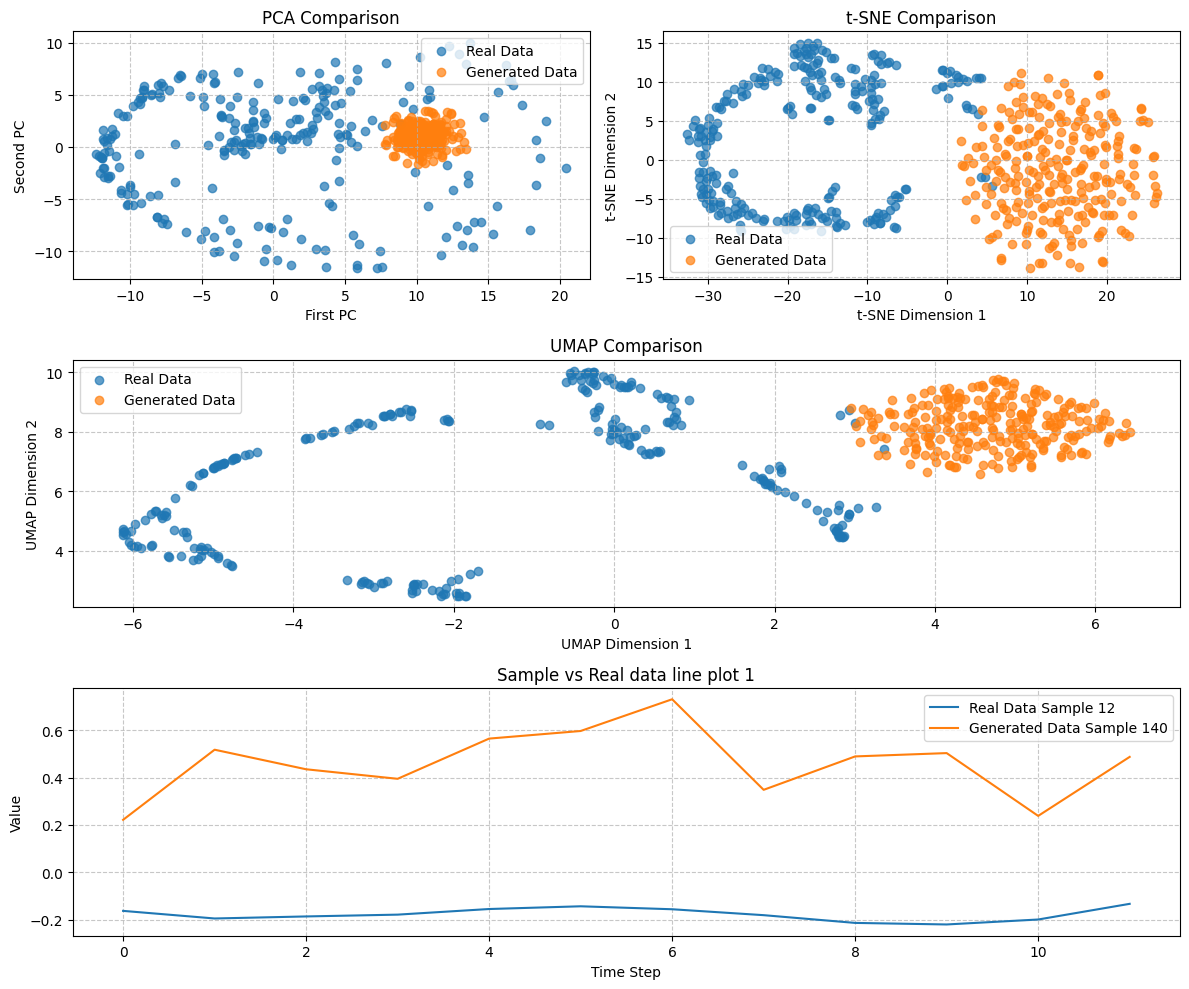

In [10]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


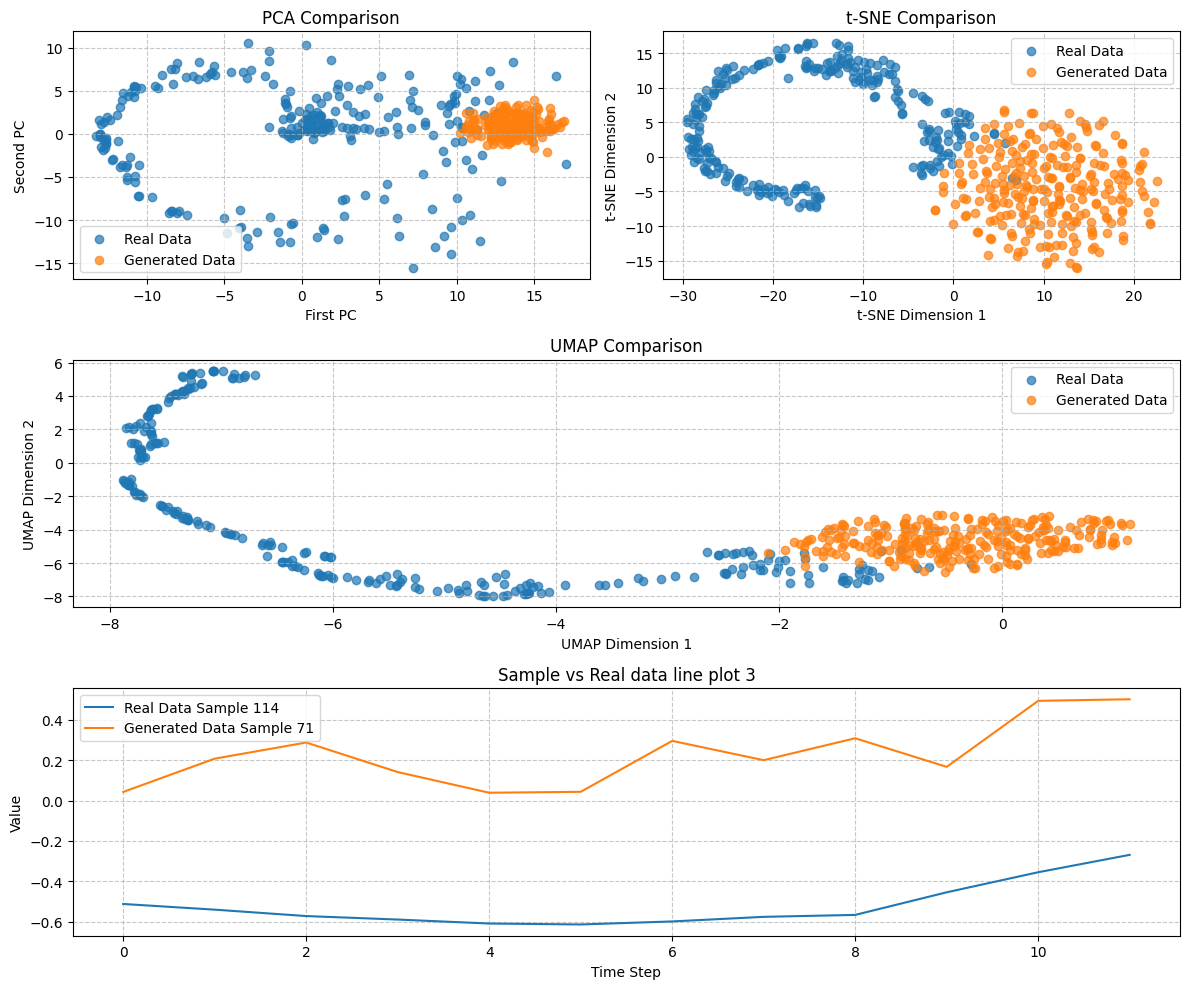

In [11]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

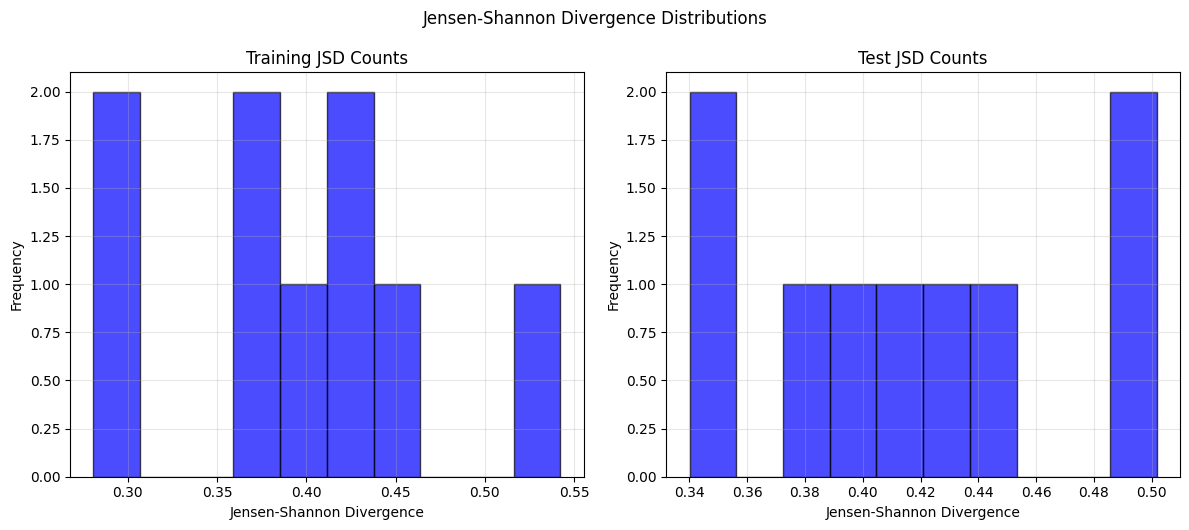

In [12]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

sampling loop time step: 100%|██████████| 500/500 [00:00<00:00, 837.18it/s]


Text(0.5, 1.0, 'Real Data')

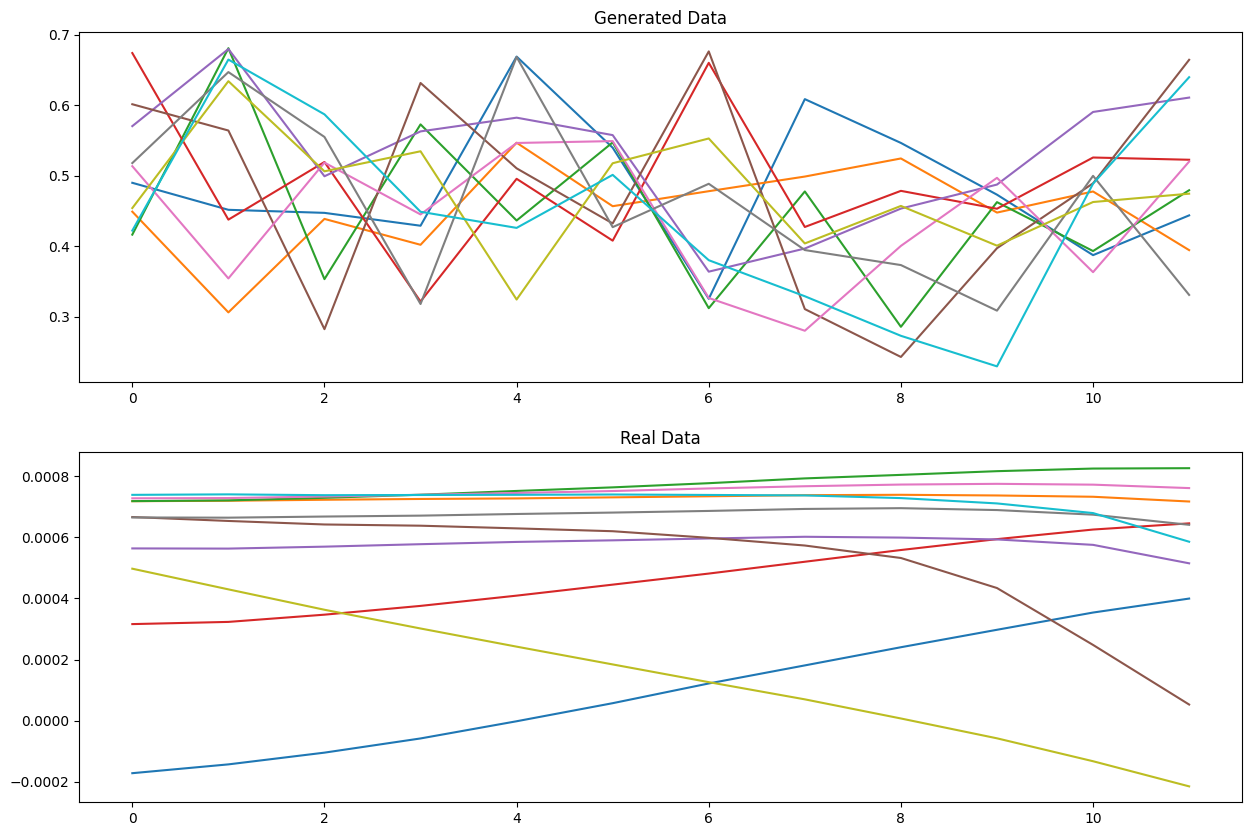

In [13]:
sample_list = []
for i in range(0, 10):
    with torch.no_grad():
        sample = ddpm.sample(1)
        sample = sample.cpu().numpy().squeeze()
    
    sample_list.append(sample)

sample_mean = np.mean(sample_list, axis=0)
gt_mean = test_data.mean(axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for i in range(0, sample_mean.shape[0]):
    axs[0].plot(range(0, sample_mean.shape[1]), sample_mean[i])
    axs[1].plot(range(0, gt_mean.shape[1]), gt_mean[i])

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")
